In [1]:
import torch
import torch.nn as nn
import torch.utils.data
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
#assert(torch.cuda.is_available()) # if this fails go to Runtime -> Change runtime type -> Set "Hardware Accelerator"
print("Torch version:", torch.__version__)

Torch version: 2.5.1+cu121


In [2]:
%load_ext Cython

In [3]:
%%cython

import numpy as np
np.get_include() # do we need this on colab?
cimport cython
cimport numpy as np

cdef dict bases={ 'A':<int>0, 'C':<int>1, 'G':<int>2, 'T':<int>3 }

@cython.boundscheck(False)
def one_hot( str string ):
    cdef np.ndarray[np.float32_t, ndim=2] res = np.zeros( (4,len(string)), dtype=np.float32 )
    cdef int j
    for j in range(len(string)):
        if string[j] in bases: # bases can be 'N' signifying missing: this corresponds to all 0 in the encoding
            res[ bases[ string[j] ], j ]=float(1.0)
    return(res)


Content of stderr:
In file included from /usr/local/lib/python3.10/dist-packages/numpy/core/include/numpy/ndarraytypes.h:1929,
                 from /usr/local/lib/python3.10/dist-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /usr/local/lib/python3.10/dist-packages/numpy/core/include/numpy/arrayobject.h:5,
                 from /root/.cache/ipython/cython/_cython_magic_4bd861d19ade608789bf2e789005c68fe289f9ad.c:1250:
/usr/local/lib/python3.10/dist-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~

In [204]:
# Loading noise data from Jariani's 6 hour glucose dataset since that has the most no. of cells
# 5795 genes in dataset - length of all upstream sequences is 1000 bp
df = pd.read_csv('/content/glu6hr_CNNdata.csv')
df = df.drop(columns=['Unnamed: 0'])
df.columns = ['Gene', 'Noise', 'Promoter']
# Add a column with value 1 if noise > 0.01, else 0
df['high_noise'] = (df['Noise'] > 0.01).astype(int)
print(df.head())

    Gene     Noise                                           Promoter  \
0   ICR1  0.014871  TTTATCCAAATGAAGACACATTAGCGGGTCGATGTCATTATCGAAG...   
1   LSR1  0.064179  CTGATCAAGACTAGAAGAGCTCGGCAAGCTGAGGAAGAATATGCGA...   
2   NME1  0.024116  GAATAAACATGCAACAGCGATAATATGAGGAGGGTAAAGCAAATGA...   
3   RPR1  0.013956  GGATTGGGCTCGGATATGCTCTTGCATGCAAGGCATCTCATCCGGA...   
4  RUF20 -0.004345  CGTAGACCAACACGGGAAGATGTCTCAAGATTCTTGTTTTGACCTC...   

   high_noise  
0           1  
1           1  
2           1  
3           1  
4           0  


In [ ]:
df['high_noise'].sum() / len(df) #30 % of genes have high noise

0.3002588438308887

In [ ]:
df.shape

(5795, 4)

# Noise data statistics

In [4]:
noise = pd.read_csv('/content/RNA_noise_complete.csv')
noise = noise.drop(columns=['Unnamed: 0'])
noise.filter(like="DM_").corr()

DM_DMSO    DM_gua    DM_MPA  DM_guaMPA  DM_stressed  \
DM_DMSO        1.000000  0.544109  0.506847   0.558230     0.085920   
DM_gua         0.544109  1.000000  0.498760   0.543501     0.065621   
DM_MPA         0.506847  0.498760  1.000000   0.498815     0.061306   
DM_guaMPA      0.558230  0.543501  0.498815   1.000000     0.108043   
DM_stressed    0.085920  0.065621  0.061306   0.108043     1.000000   
DM_unstressed  0.097382  0.085232  0.082705   0.103702     0.599456   
DM_2hr         0.040052  0.031866  0.088175   0.029364     0.419352   
DM_16hr        0.086247  0.075233  0.090908   0.090342     0.447784   
DM_36hr        0.083745  0.091029  0.096074   0.090770     0.455144   
DM_glu6hr      0.223055  0.325844  0.195763   0.204903     0.055875   
DM_glu12hr     0.193475  0.312963  0.185921   0.194700     0.035478   
DM_lag1hr      0.166626  0.250501  0.163257   0.134045     0.035422   
DM_lag3hr      0.184189  0.287589  0.157601   0.141229     0.098970   
DM_glumal      0.209337  0.320066  0.186298   0.177799     0.055173   
DM_YPD         0.244250  0.355049  0.234181   0.182714     0.118727   
DM_YJM         0.161800  0.181976  0.140784   0.147641     0.112160   

               DM_unstressed    DM_2hr   DM_16hr   DM_36hr  DM_glu6hr  \
DM_DMSO             0.097382  0.040052  0.086247  0.083745   0.223055   
DM_gua              0.085232  0.031866  0.075233  0.091029   0.325844   
DM_MPA              0.082705  0.088175  0.090908  0.096074   0.195763   
DM_guaMPA           0.103702  0.029364  0.090342  0.090770   0.204903   
DM_stressed         0.599456  0.419352  0.447784  0.455144   0.055875   
DM_unstressed       1.000000  0.503930  0.527509  0.526235   0.099373   
DM_2hr              0.503930  1.000000  0.767383  0.698502   0.075528   
DM_16hr             0.527509  0.767383  1.000000  0.753664   0.097508   
DM_36hr             0.526235  0.698502  0.753664  1.000000   0.131817   
DM_glu6hr           0.099373  0.075528  0.097508  0.131817   1.000000   
DM_glu12hr          0.058857  0.022309  0.054689  0.100073   0.759161   
DM_lag1hr           0.071100  0.038286  0.060447  0.083940   0.461417   
DM_lag3hr           0.135776  0.108854  0.116068  0.124600   0.495136   
DM_glumal           0.087141  0.027548  0.069147  0.106833   0.746949   
DM_YPD              0.163347  0.169645  0.184664  0.181434   0.585115   
DM_YJM              0.135465  0.086917  0.107669  0.118181   0.217009   

               DM_glu12hr  DM_lag1hr  DM_lag3hr  DM_glumal    DM_YPD    DM_YJM  
DM_DMSO          0.193475   0.166626   0.184189   0.209337  0.244250  0.161800  
DM_gua           0.312963   0.250501   0.287589   0.320066  0.355049  0.181976  
DM_MPA           0.185921   0.163257   0.157601   0.186298  0.234181  0.140784  
DM_guaMPA        0.194700   0.134045   0.141229   0.177799  0.182714  0.147641  
DM_stressed      0.035478   0.035422   0.098970   0.055173  0.118727  0.112160  
DM_unstressed    0.058857   0.071100   0.135776   0.087141  0.163347  0.135465  
DM_2hr           0.022309   0.038286   0.108854   0.027548  0.169645  0.086917  
DM_16hr          0.054689   0.060447   0.116068   0.069147  0.184664  0.107669  
DM_36hr          0.100073   0.083940   0.124600   0.106833  0.181434  0.118181  
DM_glu6hr        0.759161   0.461417   0.495136   0.746949  0.585115  0.217009  
DM_glu12hr       1.000000   0.455826   0.432312   0.719034  0.543561  0.203925  
DM_lag1hr        0.455826   1.000000   0.491372   0.471410  0.362697  0.159056  
DM_lag3hr        0.432312   0.491372   1.000000   0.483718  0.460259  0.225133  
DM_glumal        0.719034   0.471410   0.483718   1.000000  0.504915  0.218981  
DM_YPD           0.543561   0.362697   0.460259   0.504915  1.000000  0.354745  
DM_YJM           0.203925   0.159056   0.225133   0.218981  0.354745  1.000000

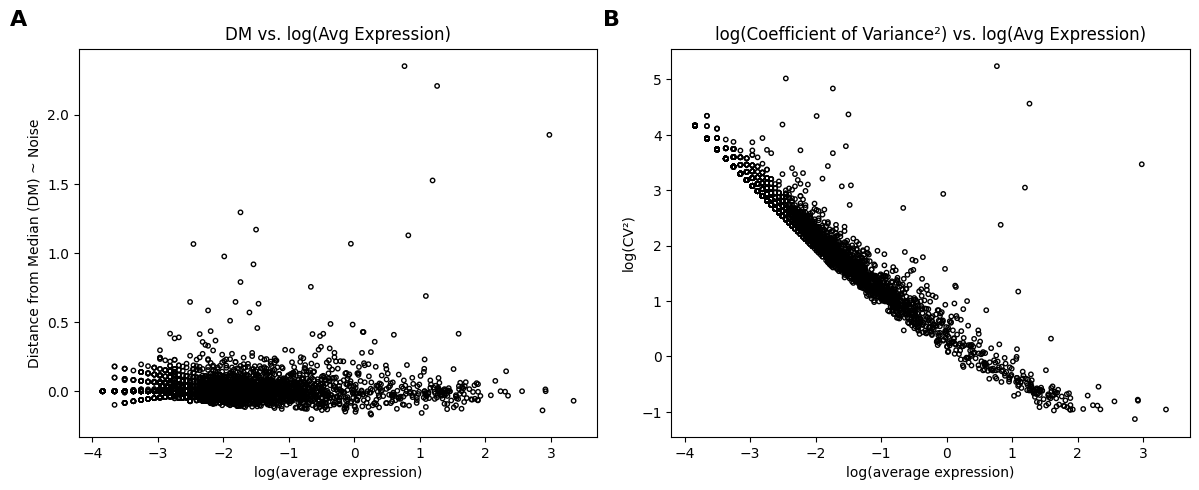

In [8]:
# Set up the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# First scatter plot
ax1.scatter(np.log(noise['AVGEXP_DMSO']), noise['DM_DMSO'], facecolors='none', edgecolors='black', s=10)
ax1.set_xlabel("log(average expression)")
ax1.set_ylabel("Distance from Median (DM) ~ Noise")
ax1.set_title("DM vs. log(Avg Expression)")

# Add label "A" in the top-left corner of the first subplot
ax1.text(-0.1, 1.1, 'A', transform=ax1.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

# Second scatter plot
#ax2.scatter(np.log(noise['AVGEXP_DMSO']), noise['CV_DMSO'], facecolors='none', edgecolors='black', s=10)
ax2.scatter(np.log(noise['AVGEXP_DMSO']), np.log(noise['CV_DMSO']*noise['CV_DMSO']), facecolors='none', edgecolors='black', s=10)
ax2.set_xlabel("log(average expression)")
ax2.set_ylabel("log(CV²)")
ax2.set_title("log(Coefficient of Variance²) vs. log(Avg Expression)")

# Add label "B" in the top-left corner of the second subplot
ax2.text(-0.1, 1.1, 'B', transform=ax2.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

# Display the plots
plt.tight_layout()
plt.show()

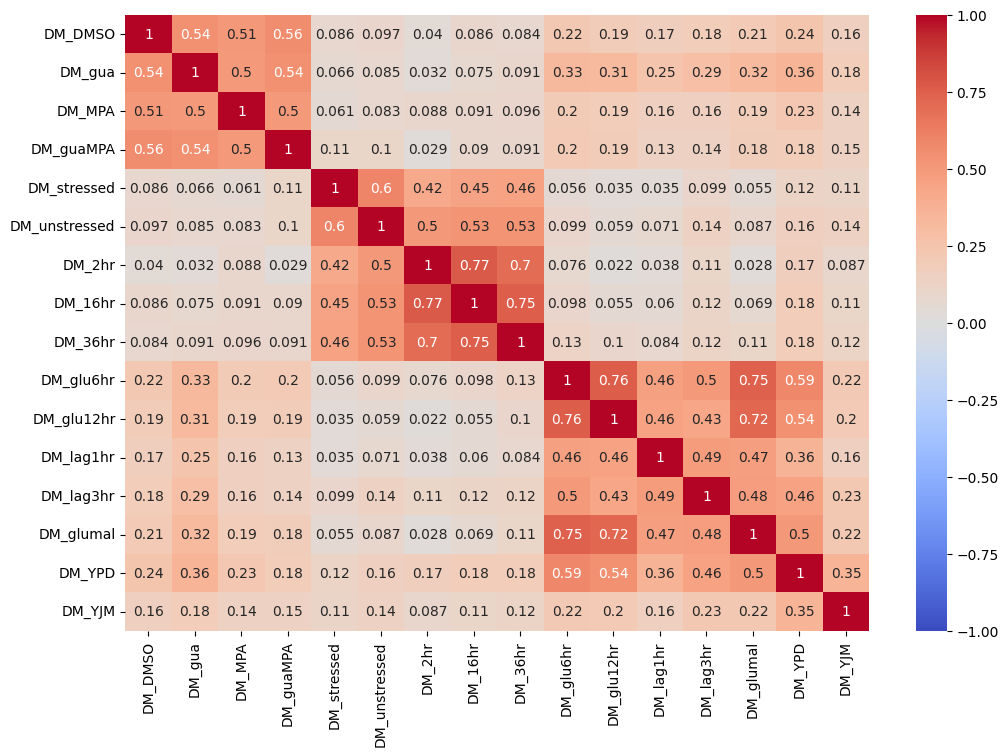

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(noise.filter(like="DM_").corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
            #xticklabels=new_labels, yticklabels=new_labels)
#plt.tight_layout()
plt.show()

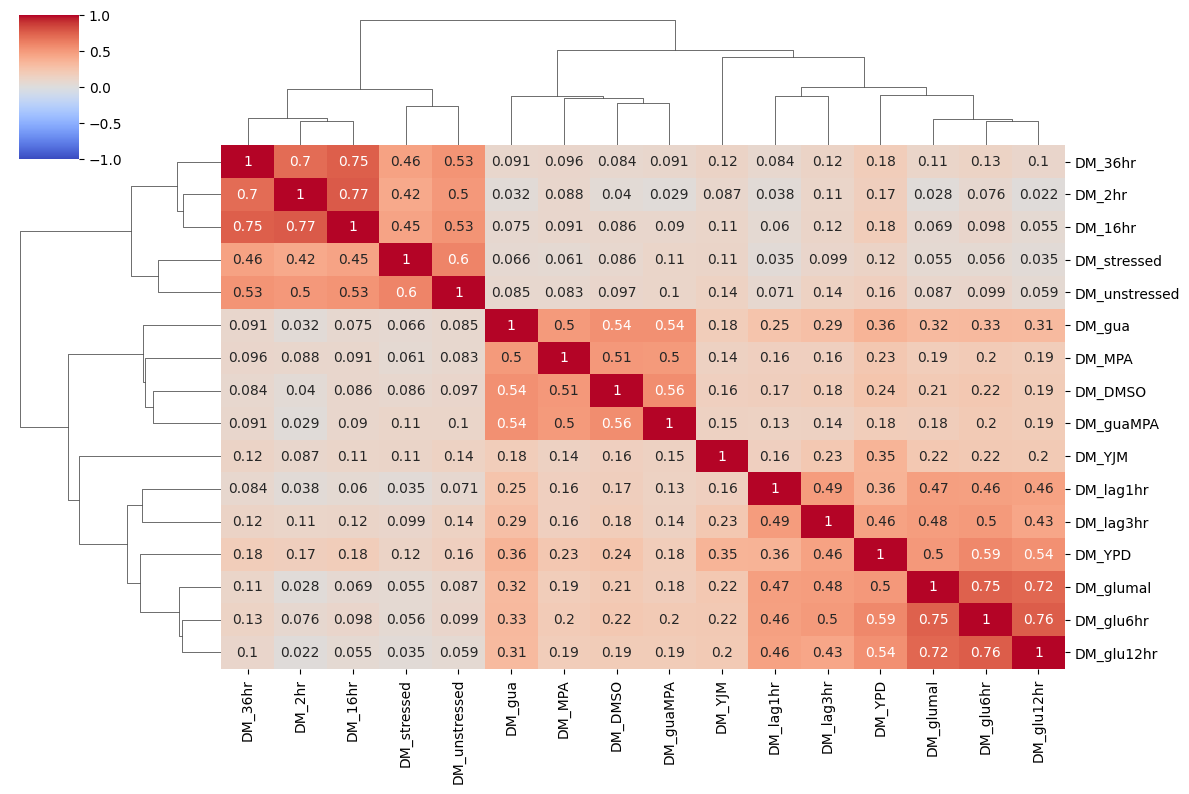

In [ ]:
# Create a heatmap with hierarchical clustering
sns.clustermap(noise.filter(like="DM_").corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1, figsize=(12, 8))

plt.show()

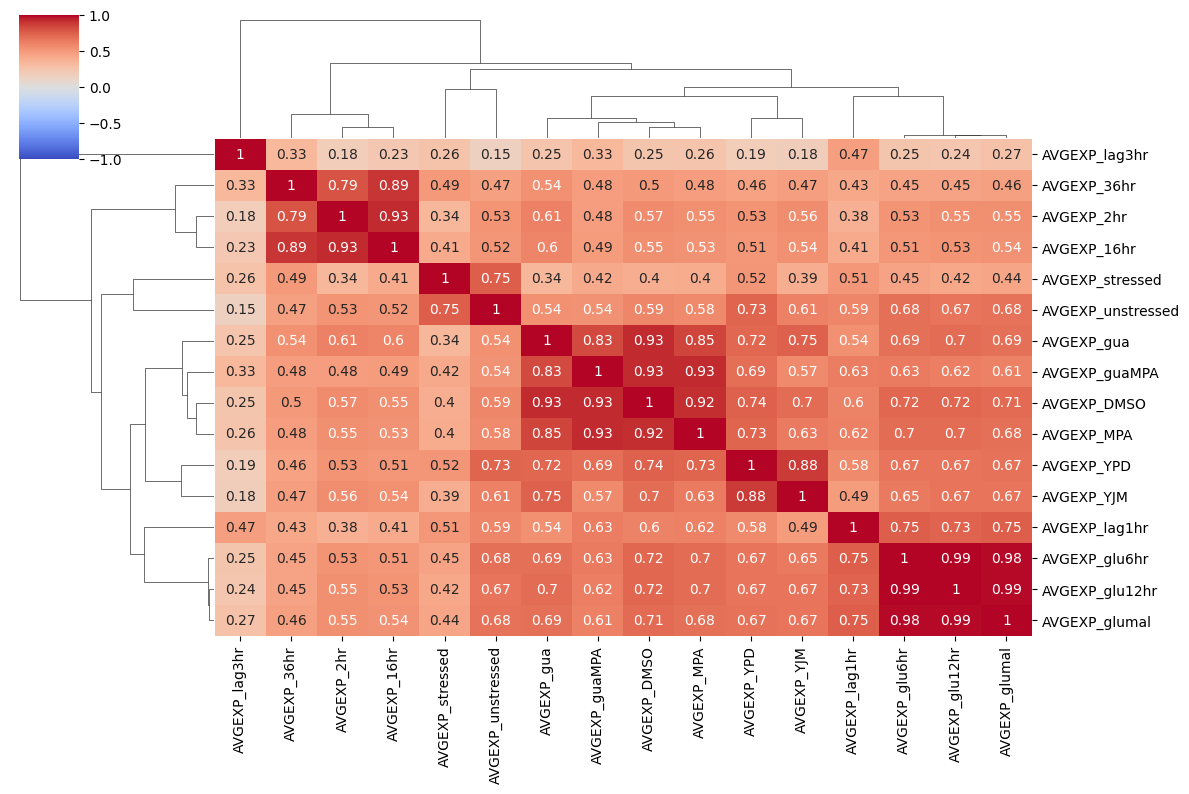

In [ ]:
# Create a heatmap with hierarchical clustering for correlation of average expression of genes across conditions
sns.clustermap(noise.filter(like="AVGEXP_").corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1, figsize=(12, 8))

plt.show()

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

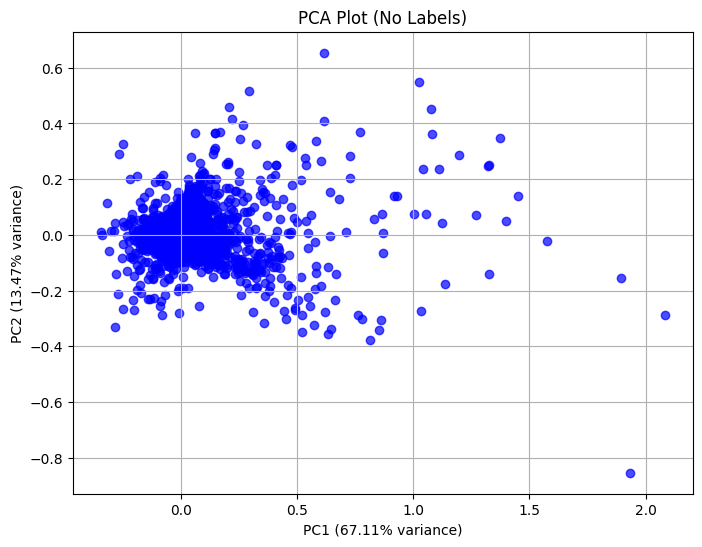

In [ ]:
from sklearn.decomposition import PCA

# Perform PCA
pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization
#pca_result = pca.fit_transform(noise.filter(like="DM_").dropna())
pca_result = pca.fit_transform(noise[['DM_glu6hr','DM_glu12hr','DM_glumal','DM_lag1hr','DM_lag3hr']].dropna())

# Create a DataFrame for easier plotting
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])

# Explained variance
explained_variance = pca.explained_variance_ratio_

# Plot PCA without labels
plt.figure(figsize=(8, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.7, color='blue')

plt.title('PCA Plot (No Labels)')
plt.xlabel(f'PC1 ({explained_variance[0]*100:.2f}% variance)')
plt.ylabel(f'PC2 ({explained_variance[1]*100:.2f}% variance)')
plt.grid()
plt.show()


In [ ]:
from sklearn.cluster import KMeans

def optimise_k(data, max_k=10):
    means = []
    inertia = []

    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        means.append(k)
        inertia.append(kmeans.inertia_)

    # Generate elbow plot
    plt.plot(means, inertia, marker='o')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Inertia')
    plt.title('Elbow Method')
    plt.show()

In [ ]:
noise.filter(like="DM_").dropna().shape

(1382, 16)

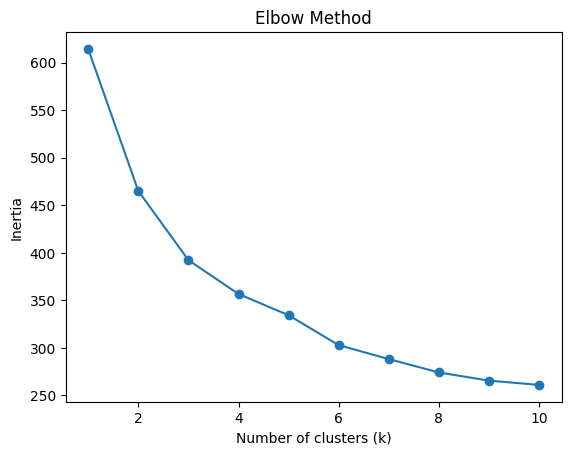

In [ ]:
optimise_k(noise.filter(like="DM_").dropna())

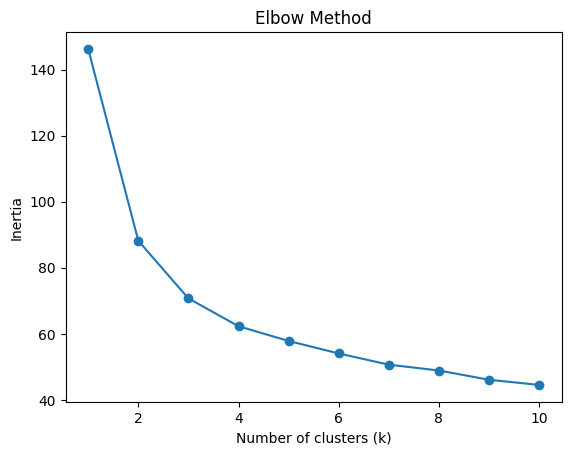

In [ ]:
optimise_k(noise[['DM_glu6hr','DM_glu12hr','DM_glumal','DM_lag1hr','DM_lag3hr']].dropna())

In [ ]:
data = noise[['DM_glu6hr','DM_glu12hr','DM_glumal','DM_lag1hr','DM_lag3hr']].dropna()
kmeans = KMeans(n_clusters=4)
kmeans.fit(data)
data['kmeans_4'] = kmeans.labels_

In [ ]:
data

DM_glu6hr    DM_glu12hr     DM_glumal     DM_lag1hr     DM_lag3hr  \
1     1.487144e-02  2.664535e-15  0.000000e+00  5.107026e-15 -5.822505e-03   
2     6.417852e-02 -2.364032e-02  8.246121e-02  7.759490e-02 -7.771561e-15   
3     3.552714e-15  6.217249e-15  1.554312e-15  9.635649e-02  2.516037e-01   
4     2.411647e-02  6.661338e-15  5.502960e-02  6.171229e-02  3.131480e-03   
9    -9.489313e-03 -3.704005e-02 -8.486018e-03 -1.172415e-02 -2.949086e-02   
...            ...           ...           ...           ...           ...   
7145 -2.764232e-02 -4.440892e-16  1.110223e-15  1.554312e-15 -1.609555e-02   
7147 -3.173792e-02  8.571852e-03 -1.622042e-02 -1.314615e-02  1.170446e-03   
7148 -2.270919e-03 -1.138629e-02  6.049491e-03  3.802812e-02  1.143449e-02   
7149 -1.665071e-02 -7.327472e-15 -1.995971e-02 -2.608821e-02  1.783504e-02   
7150  1.598721e-14  8.881784e-16 -4.440892e-16  3.996803e-15  5.773160e-15   

      kmeans_4  
1            0  
2            0  
3            3  
4            0  
9            0  
...        ...  
7145         0  
7147         0  
7148         0  
7149         0  
7150         0  

[5343 rows x 6 columns]

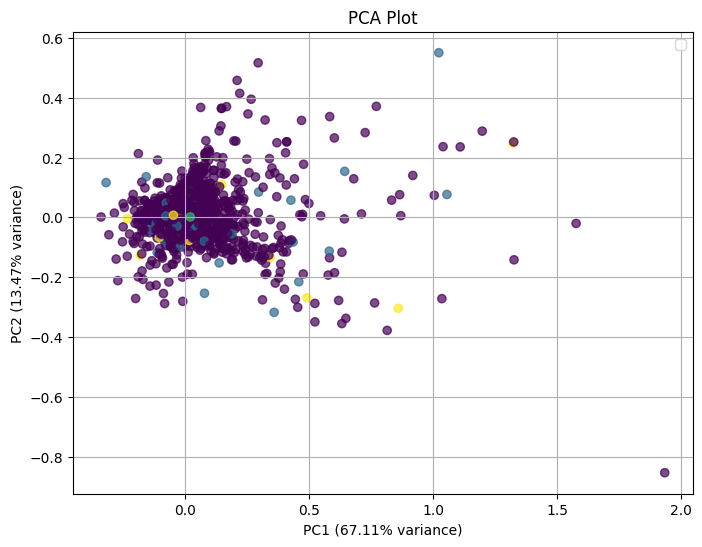

In [ ]:
# Perform PCA
pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization
pca_result = pca.fit_transform(data[['DM_glu6hr','DM_glu12hr','DM_glumal','DM_lag1hr','DM_lag3hr']])

# Create a DataFrame for easier plotting
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
pca_df['Label'] = data['kmeans_4']

# Explained variance
explained_variance = pca.explained_variance_ratio_

# Plot PCA
# Plot PCA without labels
plt.figure(figsize=(8, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.7, c=pca_df['Label'])

plt.title('PCA Plot')
plt.xlabel(f'PC1 ({explained_variance[0]*100:.2f}% variance)')
plt.ylabel(f'PC2 ({explained_variance[1]*100:.2f}% variance)')
plt.legend()
plt.grid()
plt.show()


In [ ]:
print(data.groupby('kmeans_4').mean())

          DM_glu6hr  DM_glu12hr  DM_glumal  DM_lag1hr  DM_lag3hr
kmeans_4                                                        
0         -0.000648   -0.000863  -0.000402   0.000991   0.000911
1          0.190951    0.174875   0.196732   0.050594   0.049887
2          0.627335    0.543239   0.627544   0.365667   0.431619
3          0.101732    0.088059   0.109002   0.165708   0.254505


In [ ]:
print(data.groupby('kmeans_4').median())

          DM_glu6hr    DM_glu12hr     DM_glumal     DM_lag1hr     DM_lag3hr
kmeans_4                                                                   
0         -0.001294 -5.773160e-15 -1.776357e-15 -2.220446e-15 -6.661338e-15
1          0.168674  1.501170e-01  1.724256e-01  3.904497e-02  3.457515e-02
2          0.591687  5.109630e-01  5.758737e-01  3.375446e-01  4.716675e-01
3          0.073083  5.669086e-02  7.973019e-02  1.509203e-01  2.184759e-01


In [ ]:
print(data.groupby('kmeans_4').std())

          DM_glu6hr  DM_glu12hr  DM_glumal  DM_lag1hr  DM_lag3hr
kmeans_4                                                        
0          0.028434    0.036064   0.040547   0.042877   0.037772
1          0.115620    0.119206   0.102298   0.075234   0.072517
2          0.302340    0.223614   0.240160   0.221122   0.264210
3          0.113162    0.105765   0.128061   0.153320   0.153193


In [ ]:
data['kmeans_4'].value_counts()

kmeans_4
0    4979
1     214
3     117
2      33
Name: count, dtype: int64

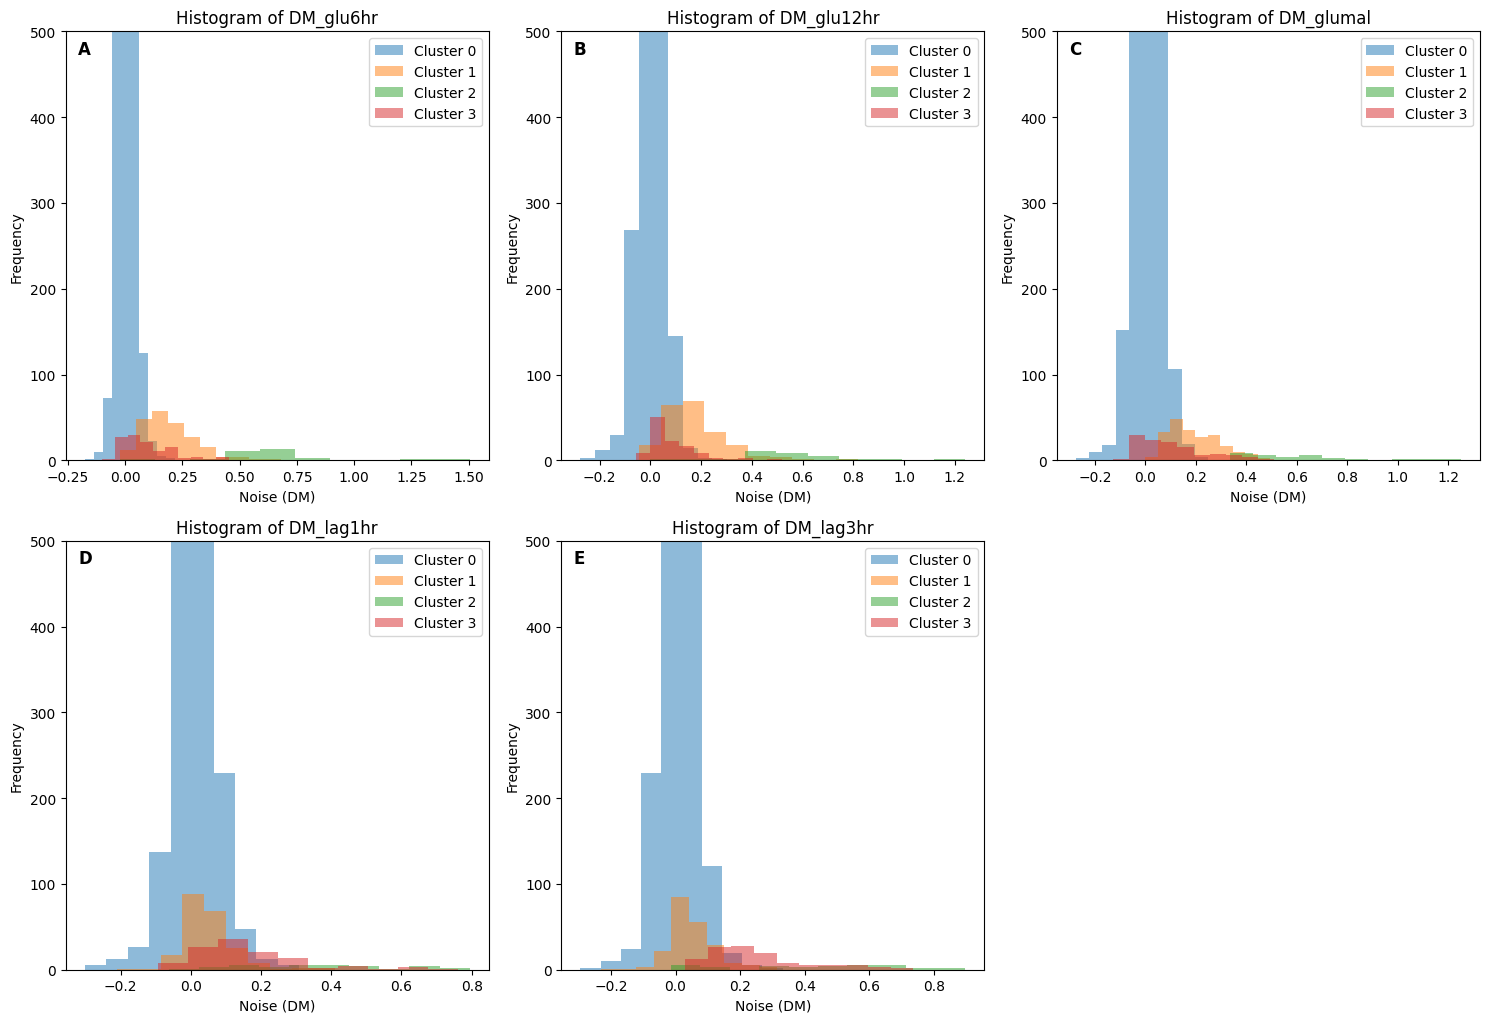

In [ ]:
# Get the list of features (excluding 'kmeans_4')
features = [col for col in data.columns if col != 'kmeans_4']

# Determine the number of rows and columns for the subplot grid
n_features = len(features)
n_cols = 3  # Number of columns per row
n_rows = (n_features // n_cols) + (n_features % n_cols)

# Create a figure to contain the subplots
plt.figure(figsize=(5 * n_cols, 5 * n_rows))

# Define subplot labels (a, b, c, d, e, etc.)
subplot_labels = ['A', 'B', 'C', 'D', 'E']

# Loop over features and plot each feature's histogram in the grid
for i, feature in enumerate(features, 1):
    ax = plt.subplot(n_rows, n_cols, i)
    plt.subplot(n_rows, n_cols, i)

    # Plot histograms for each cluster
    for label, group in data.groupby('kmeans_4'):
        plt.hist(
            group[feature],
            alpha=0.5,
            label=f'Cluster {label}',
            bins=10
        )

    # Set y-axis limits to 0, 500
    plt.ylim(0, 500)

    # Set title and labels
    plt.title(f'Histogram of {feature}')
    plt.xlabel('Noise (DM)')
    plt.ylabel('Frequency')
    plt.legend()

    # Add label to the top-left corner
    ax.text(0.03, 0.98, f'{subplot_labels[i-1]}', transform=ax.transAxes,
            fontsize=12, verticalalignment='top', horizontalalignment='left', fontweight='bold',
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


In [ ]:
!pip install gprofiler-official

In [ ]:
from gprofiler import GProfiler

noise_clustering = noise[['ORF','DM_glu6hr','DM_glu12hr','DM_glumal','DM_lag1hr','DM_lag3hr']].dropna()
noise_clustering['kmeans_4'] = data['kmeans_4']
noise_clustering.to_csv('noise_clustering.csv', index=False)

# Initialize g:Profiler
gp = GProfiler(return_dataframe=True)

# Group genes by 'group' column
gene_groups = noise_clustering.groupby('kmeans_4')['ORF'].apply(list).to_dict()

# Perform GO term enrichment for each group
for group, genes in gene_groups.items():
    print(f"Enrichment results for {group}")

    # Perform GO term enrichment
    results = gp.profile(
        organism="scerevisiae",  # Use "scerevisiae" for Saccharomyces cerevisiae
        query=genes,
        sources=["GO:BP", "GO:MF", "GO:CC"]  # Biological Process, Molecular Function, Cellular Component
    )
    print(results)

    # Save results to CSV file
    results.to_csv(f"{group}_GO_enrichment.csv", index=False)


Enrichment results for 0
    source      native                                               name  \
0    GO:CC  GO:0005622                 intracellular anatomical structure   
1    GO:BP  GO:0009987                                   cellular process   
2    GO:CC  GO:0043226                                          organelle   
3    GO:CC  GO:0043229                            intracellular organelle   
4    GO:CC  GO:0043227                         membrane-bounded organelle   
..     ...         ...                                                ...   
551  GO:BP  GO:0051983               regulation of chromosome segregation   
552  GO:BP  GO:0000077                    DNA damage checkpoint signaling   
553  GO:BP  GO:0042770      signal transduction in response to DNA damage   
554  GO:BP  GO:0000288  nuclear-transcribed mRNA catabolic process, de...   
555  GO:MF  GO:0004521                          RNA endonuclease activity   

           p_value  significant  \
0    7.076108e-

In [ ]:
noise_clustering.shape
data.shape

(5343, 6)

In [ ]:
results.head()

source      native                                 name       p_value  \
0  GO:BP  GO:0044283  small molecule biosynthetic process  5.575177e-09   
1  GO:BP  GO:0044281     small molecule metabolic process  1.757102e-08   
2  GO:BP  GO:0006094                      gluconeogenesis  3.734221e-08   
3  GO:BP  GO:0019319          hexose biosynthetic process  3.734221e-08   
4  GO:BP  GO:0005996     monosaccharide metabolic process  8.315181e-08   

   significant                                        description  term_size  \
0         True  "The chemical reactions and pathways resulting...        357   
1         True  "The chemical reactions and pathways involving...        775   
2         True  "The formation of glucose from noncarbohydrate...         33   
3         True  "The chemical reactions and pathways resulting...         33   
4         True  "The chemical reactions and pathways involving...         90   

   query_size  intersection_size  effective_domain_size  precision    recall  \
0         107                 27                   6518   0.252336  0.075630   
1         107                 39                   6518   0.364486  0.050323   
2         107                 10                   6518   0.093458  0.303030   
3         107                 10                   6518   0.093458  0.303030   
4         107                 14                   6518   0.130841  0.155556   

     query                   parents  
0  query_1  [GO:0009058, GO:0044281]  
1  query_1              [GO:0008152]  
2  query_1  [GO:0006006, GO:0019319]  
3  query_1  [GO:0019318, GO:0046364]  
4  query_1  [GO:0005975, GO:0044281]

from matplotlib import pyplot as plt
_df_0['p_value'].plot(kind='hist', bins=20, title='p_value')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['term_size'].plot(kind='hist', bins=20, title='term_size')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['intersection_size'].plot(kind='hist', bins=20, title='intersection_size')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['precision'].plot(kind='hist', bins=20, title='precision')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_4.groupby('native').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_5.groupby('name').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_6.groupby('description').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='p_value', y='term_size', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8.plot(kind='scatter', x='term_size', y='intersection_size', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_9.plot(kind='scatter', x='intersection_size', y='precision', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_10.plot(kind='scatter', x='precision', y='recall', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['p_value']
  ys = series['term_size']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('p_value', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('native')):
  _plot_series(series, series_name, i)
  fig.legend(title='native', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('p_value')
_ = plt.ylabel('term_size')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['p_value']
  ys = series['term_size']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_12.sort_values('p_value', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('name')):
  _plot_series(series, series_name, i)
  fig.legend(title='name', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('p_value')
_ = plt.ylabel('term_size')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['p_value']
  ys = series['term_size']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_13.sort_values('p_value', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('description')):
  _plot_series(series, series_name, i)
  fig.legend(title='description', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('p_value')
_ = plt.ylabel('term_size')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['p_value']
  ys = series['intersection_size']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_14.sort_values('p_value', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('native')):
  _plot_series(series, series_name, i)
  fig.legend(title='native', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('p_value')
_ = plt.ylabel('intersection_size')

from matplotlib import pyplot as plt
_df_15['p_value'].plot(kind='line', figsize=(8, 4), title='p_value')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_16['term_size'].plot(kind='line', figsize=(8, 4), title='term_size')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_17['intersection_size'].plot(kind='line', figsize=(8, 4), title='intersection_size')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_18['precision'].plot(kind='line', figsize=(8, 4), title='precision')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['name'].value_counts()
    for x_label, grp in _df_19.groupby('native')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('native')
_ = plt.ylabel('name')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['description'].value_counts()
    for x_label, grp in _df_20.groupby('name')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('name')
_ = plt.ylabel('description')

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_21['native'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_21, x='p_value', y='native', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_22['name'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_22, x='p_value', y='name', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_23['description'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_23, x='p_value', y='description', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_24['native'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_24, x='term_size', y='native', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
# Assuming `results` is a DataFrame from g:Profiler
top_terms = results.head(10)  # Get top 10 GO terms

# Plotting
sns.barplot(x="-log10(p_value)", y="name", data=top_terms, palette="viridis")
plt.title("Top 10 GO Enrichment Terms for Group1")
plt.xlabel("-log10(p-value)")
plt.ylabel("GO Term")
plt.show()

ValueError: Could not interpret value `-log10(p_value)` for `x`. An entry with this name does not appear in `data`.

# Noise Prediction by Gene Features

In [195]:
#feature selection
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, KFold, cross_validate, RepeatedKFold
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression, f_classif
from sklearn.metrics import mean_squared_error, r2_score, make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, roc_curve, auc, precision_recall_curve

## Linear Regression

In [179]:
feature_dataset = pd.read_csv('/content/JarianiNoise_GeneFeature_dataset.csv')
print(feature_dataset.shape)
feature_dataset = feature_dataset.dropna(subset=['DM_glu6hr'])
print(feature_dataset.shape)
X = feature_dataset.iloc[:, 2: 282]
y = feature_dataset['DM_glu6hr']

(4567, 307)
(4227, 307)


In [180]:
imputer = SimpleImputer(strategy="mean")  # You can also use "median" or "most_frequent"
X = imputer.fit_transform(X)
# Split the data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=40) #, random_state=42
X_test, X_val, y_test, y_val = train_test_split(X, y, test_size=0.5, random_state=40)

k=1, Mean Squared Error: 0.0064, R² Score: 0.1467
k=2, Mean Squared Error: 0.0062, R² Score: 0.1721
k=3, Mean Squared Error: 0.0062, R² Score: 0.1729
k=4, Mean Squared Error: 0.0062, R² Score: 0.1765
k=5, Mean Squared Error: 0.0062, R² Score: 0.1778
k=6, Mean Squared Error: 0.0061, R² Score: 0.1890
k=7, Mean Squared Error: 0.0058, R² Score: 0.2250
k=8, Mean Squared Error: 0.0058, R² Score: 0.2254
k=9, Mean Squared Error: 0.0058, R² Score: 0.2254
k=10, Mean Squared Error: 0.0056, R² Score: 0.2545
k=11, Mean Squared Error: 0.0057, R² Score: 0.2503
k=12, Mean Squared Error: 0.0056, R² Score: 0.2512
k=13, Mean Squared Error: 0.0056, R² Score: 0.2546
k=14, Mean Squared Error: 0.0055, R² Score: 0.2684
k=15, Mean Squared Error: 0.0055, R² Score: 0.2694
k=16, Mean Squared Error: 0.0054, R² Score: 0.2832
k=17, Mean Squared Error: 0.0054, R² Score: 0.2848
k=18, Mean Squared Error: 0.0054, R² Score: 0.2853
k=19, Mean Squared Error: 0.0054, R² Score: 0.2844
k=20, Mean Squared Error: 0.0054, R² Sco

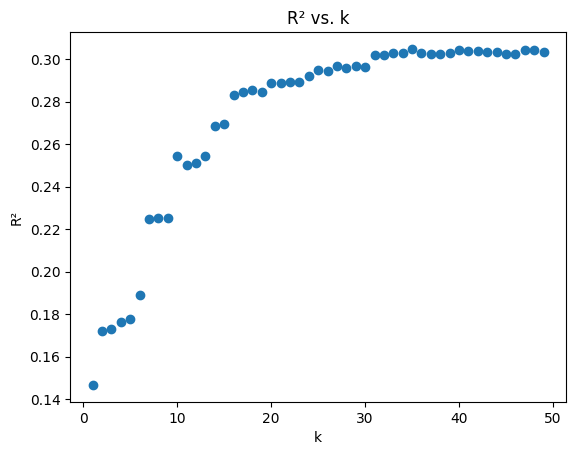

In [181]:
# Dictionary to store results for each k
results = []

for k in range(1,50):
    # Select the top k features
    selector = SelectKBest(score_func=f_regression, k=k)
    selector.fit(X_train, y_train)

    # Transform the datasets
    X_train_selected = selector.transform(X_train)
    X_test_selected = selector.transform(X_test)
    X_val_selected = selector.transform(X_val)

    # Train the linear regression model
    model = LinearRegression()
    model.fit(X_train_selected, y_train)

    # Predict on the validation set
    y_pred = model.predict(X_val_selected)

    # Calculate metrics
    mse = mean_squared_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)

    # Store results
    results.append((k, mse, r2))

    # Print the results for this k
    print(f"k={k}, Mean Squared Error: {mse:.4f}, R² Score: {r2:.4f}")

# Optionally, display the results as a DataFrame
results_df = pd.DataFrame(results, columns=["k", "MSE", "R2"])
#print("\nSummary of results:")
#print(results_df)

plt.scatter(results_df['k'], results_df['R2'])
plt.xlabel('k')
plt.ylabel('R²')
plt.title('R² vs. k')
plt.show()

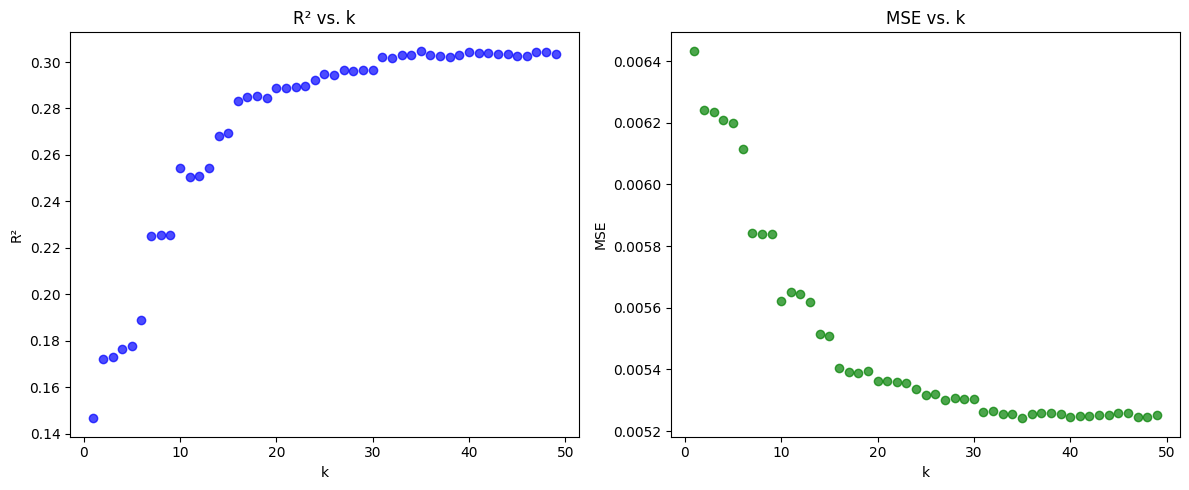

In [183]:
# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot R² vs. k
axes[0].scatter(results_df['k'], results_df['R2'], color='blue', alpha=0.7)
axes[0].set_xlabel('k')
axes[0].set_ylabel('R²')
axes[0].set_title('R² vs. k')

# Plot MSE vs. k
axes[1].scatter(results_df['k'], results_df['MSE'], color='green', alpha=0.7)
axes[1].set_xlabel('k')
axes[1].set_ylabel('MSE')
axes[1].set_title('MSE vs. k')

# Adjust layout
plt.tight_layout()
plt.show()

In [194]:
selector = SelectKBest(score_func=f_regression, k='all')
selector.fit(X_train, y_train)
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)
X_val_selected = selector.transform(X_val)
selected_features = feature_dataset.iloc[:, 2: 282].columns[selector.get_support()]
print(selected_features)

# Initialize the model
model = LinearRegression()
model.fit(X_train_selected, y_train)

y_pred = model.predict(X_test_selected)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R2 Score: {r2}")

Index(['STRE_elem', 'TATAbox', 'NumPromNucOcc', 'AvPromNucOcc',
       'LenAvgPromNucOcc', 'NumGeneNucOcc', 'AvGeneNucOcc', 'N_PrNO50',
       'N_PrNO100', 'N_PrNO150',
       ...
       'Succinylation', 'Oxidation', 'Nitration', 'NtAcetylation',
       'Glycosylation', 'Ca', 'Disulfide', 'Lipidation', 'ActiveSite',
       'Sumoylation'],
      dtype='object', length=280)
Mean Squared Error: 0.0021731103708720876
R2 Score: 0.34526970283465364


## Ridge Regression

Average R²: -0.004
Average MSE: 0.214

R² scores for each fold: [ 0.00454221  0.03469939  0.07313615 -0.01535841  0.0209738   0.01365398
  0.04790497  0.00290796 -0.25058463  0.08126403 -0.0060149  -0.0211252
  0.0552572   0.01263843 -0.04598568  0.0308173   0.09920325 -0.09293107
 -0.05983014 -0.00702811  0.00130096  0.07939207 -0.12602986  0.01762344
 -0.02169553 -0.02082245  0.03188378 -0.03909758  0.03682031 -0.0507014 ]
MSE scores for each fold: [0.20377026 0.20426261 0.20086846 0.21212016 0.19898761 0.20871593
 0.21298693 0.226228   0.265134   0.19477941 0.19841054 0.23271809
 0.20922879 0.20211297 0.22796175 0.21352417 0.19739885 0.23411398
 0.21110136 0.20798993 0.21885297 0.19836739 0.24540655 0.21043238
 0.22509346 0.22370105 0.20356562 0.21564453 0.19185012 0.21993194]
Average R²: 0.046
Average MSE: 0.203

R² scores for each fold: [ 0.04051187  0.08443607  0.09624012  0.04340268  0.02694878  0.03677295
  0.09554983  0.04540194 -0.01005982  0.10716077  0.0809582   0.00137607


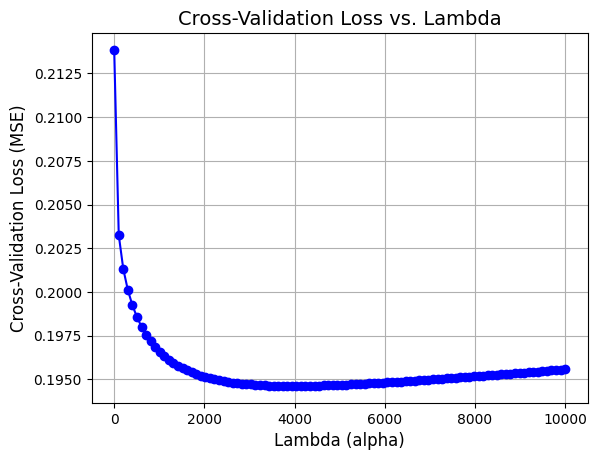

In [177]:
# Generate a range of values for alpha (lambda)
#alphas = np.logspace(-6, 6, 10000)  # Ranges from 10^-6 to 10^6
alphas = np.linspace(0.1, 10000, 100)

imputer = SimpleImputer(strategy="mean")  # You can also use "median" or "most_frequent"
X = imputer.fit_transform(X)

# Create a StandardScaler object
scaler = StandardScaler()

# Fit the scaler to the features and transform the data
X = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=40) #, random_state=42
X_test, X_val, y_test, y_val = train_test_split(X, y, test_size=0.5, random_state=40)

# Initialize lists to store cross-validation losses
cv_norm_losses = []
cv_norm_r2 = []

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

# Loop through each alpha value, perform cross-validation, and calculate the mean CV loss (MSE)
for alpha in alphas:
    model = Ridge(alpha=alpha)  # Define model with current alpha value
    # Define the scoring metrics: R² and negative MSE
    scoring = {'r2': 'r2', 'mse': 'neg_mean_squared_error'}
    # Perform cross-validation with both metrics
    results = cross_validate(model, X_train, y_train, scoring=scoring, cv=cv, return_train_score=False)

    # Extract R² and MSE values for each fold
    r2_scores = results['test_r2']
    mse_scores = -results['test_mse']  # Negate to make MSE positive


    # Mean squared error, so we negate to make it positive
    cv_norm_losses.append(mse_scores.mean())
    cv_norm_r2.append(r2_scores.mean())

    # Print average R² and MSE across all folds
    print(f"Average R²: {r2_scores.mean():.3f}")
    print(f"Average MSE: {mse_scores.mean():.3f}")

    # Optional: print R² and MSE for each fold
    print("\nR² scores for each fold:", r2_scores)
    print("MSE scores for each fold:", mse_scores)

plt.plot(alphas, cv_norm_losses, marker='o', linestyle='-', color='b')
#plt.xscale('log')  # Use a log scale for x-axis (since lambda often spans several orders of magnitude)
plt.xlabel('Lambda (alpha)', fontsize=12)
plt.ylabel('Cross-Validation Loss (MSE)', fontsize=12)
plt.title('Cross-Validation Loss vs. Lambda', fontsize=14)
plt.grid(True)
plt.show()

## Logistic Regression

In [197]:
feature_dataset = pd.read_csv('/content/JarianiNoise_GeneFeature_dataset.csv')
print(feature_dataset.shape)
feature_dataset['high_noise'] = (feature_dataset['DM_glu6hr'] > 0.01).astype(int)
feature_dataset = feature_dataset.dropna(subset=['DM_glu6hr'])
print(feature_dataset.shape)
X = feature_dataset.iloc[:, 2: 282]
y = feature_dataset['high_noise']
imputer = SimpleImputer(strategy="mean")  # You can also use "median" or "most_frequent"
X = imputer.fit_transform(X)
# Create a StandardScaler object
scaler = StandardScaler()
# Fit the scaler to the features and transform the data
X = scaler.fit_transform(X)
# Split the data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=40) #, random_state=42
X_test, X_val, y_test, y_val = train_test_split(X, y, test_size=0.5, random_state=40)
feature_dataset

(4567, 307)
(4227, 308)


Unnamed: 0      ORF  STRE_elem  TATAbox  NumPromNucOcc  AvPromNucOcc  \
0              1  YAL001C          0        1            102          0.70   
1              2  YAL002W          0        0            148          0.75   
2              3  YAL005C          1        1             85          0.45   
3              4  YAL007C          0        0            100          0.59   
4              5  YAL008W          0        0            105          0.76   
...          ...      ...        ...      ...            ...           ...   
4561        4562  YPR194C          0        1            118          0.62   
4563        4564  YPR198W          0        0             90          0.63   
4564        4565  YPR199C          0        0             99          0.71   
4565        4566  YPR200C          0        1            115          0.80   
4566        4567  YPR201W          0        1            110          0.71   

      LenAvgPromNucOcc  NumGeneNucOcc  AvGeneNucOcc  N_PrNO50  ...  FF_glu6hr  \
0                 0.07            374          0.82         4  ...   1.125668   
1                 0.11            364          0.82         6  ...   1.044933   
2                 0.04            150          0.85         1  ...   7.399504   
3                 0.06             64          0.85         0  ...   2.064952   
4                 0.08             69          0.78         5  ...   1.056609   
...                ...            ...           ...       ...  ...        ...   
4561              0.07            260          0.84         4  ...   1.246015   
4563              0.06            185          0.84         8  ...   1.061756   
4564              0.07            101          0.81        11  ...   1.081330   
4565              0.09             38          0.77         5  ...   0.984652   
4566              0.08            147          0.82         2  ...   0.997048   

        DM_glu12hr  FF_glu12hr     DM_lag1hr  FF_lag1hr     DM_lag3hr  \
0    -1.097811e-02    1.062776  2.688869e-02   1.178147  1.220763e-02   
1    -4.425408e-03    0.993589  3.436348e-02   1.149787  6.220734e-03   
2     2.872370e-01    6.387801 -2.095052e-02  12.607731  3.794759e-01   
3     6.536763e-02    2.236477  2.674863e-02   1.251601  5.014790e-02   
4    -4.759545e-03    1.066303 -2.692211e-02   1.082830 -5.985792e-02   
...            ...         ...           ...        ...           ...   
4561  8.881784e-16    0.999087  1.972425e-01   1.566793  2.220446e-15   
4563  8.571852e-03    1.152048 -1.314615e-02   1.087158  1.170446e-03   
4564 -1.138629e-02    1.079037  3.802812e-02   1.223773  1.143449e-02   
4565 -7.327472e-15    0.989954 -2.608821e-02   0.989752  1.783504e-02   
4566  8.881784e-16    0.997260  3.996803e-15   0.992314  5.773160e-15   

      FF_lag3hr     DM_glumal  FF_glumal  high_noise  
0      1.181958  3.444945e-02   1.157777           1  
1      1.071757  2.341096e-02   1.060178           0  
2      7.847228  1.589178e-01   7.071575           1  
3      1.321475  6.754969e-02   1.846353           1  
4      1.172957 -5.956485e-02   0.966311           0  
...         ...           ...        ...         ...  
4561   0.996594  8.881784e-16   0.997080           1  
4563   1.116076 -1.622042e-02   1.072390           0  
4564   1.190469  6.049491e-03   1.095793           0  
4565   1.076666 -1.995971e-02   0.967883           0  
4566   0.997275 -4.440892e-16   0.998540           0  

[4227 rows x 308 columns]

k=1, Accuracy: 0.7157, Precision: 0.6872, Recall: 0.1841, F1 Score: 0.2904
k=2, Accuracy: 0.7167, Precision: 0.6927, Recall: 0.1856, F1 Score: 0.2928
k=3, Accuracy: 0.7185, Precision: 0.6995, Recall: 0.1916, F1 Score: 0.3008
k=4, Accuracy: 0.7223, Precision: 0.7098, Recall: 0.2051, F1 Score: 0.3182
k=5, Accuracy: 0.7242, Precision: 0.7179, Recall: 0.2096, F1 Score: 0.3244
k=6, Accuracy: 0.7237, Precision: 0.7211, Recall: 0.2051, F1 Score: 0.3193
k=7, Accuracy: 0.7261, Precision: 0.7306, Recall: 0.2111, F1 Score: 0.3275
k=8, Accuracy: 0.7285, Precision: 0.7327, Recall: 0.2216, F1 Score: 0.3402
k=9, Accuracy: 0.7299, Precision: 0.7195, Recall: 0.2380, F1 Score: 0.3577
k=10, Accuracy: 0.7280, Precision: 0.6867, Recall: 0.2560, F1 Score: 0.3730
k=11, Accuracy: 0.7289, Precision: 0.6908, Recall: 0.2575, F1 Score: 0.3751
k=12, Accuracy: 0.7285, Precision: 0.6895, Recall: 0.2560, F1 Score: 0.3734
k=13, Accuracy: 0.7247, Precision: 0.6822, Recall: 0.2410, F1 Score: 0.3562
k=14, Accuracy: 0.724

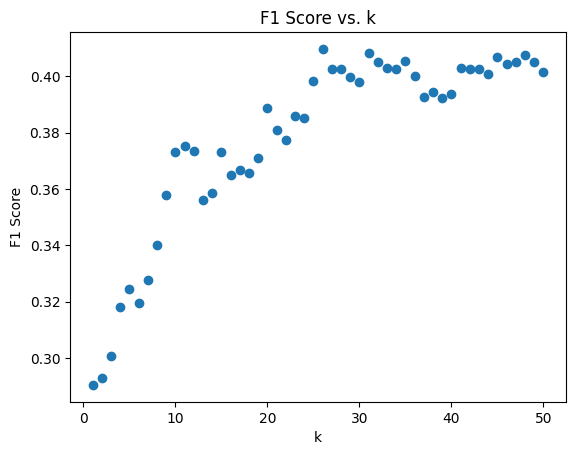

In [171]:
# Define the range of k values to test
k_values = range(1, 51)  # Adjust range as needed

# Dictionary to store results for each k
results = []

for k in k_values:
    # Select the top k features
    selector = SelectKBest(score_func=f_classif, k=k)
    selector.fit(X_train, y_train)

    # Transform the datasets
    X_train_selected = selector.transform(X_train)
    X_test_selected = selector.transform(X_test)
    X_val_selected = selector.transform(X_val)

    # Train the logistic regression model
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train_selected, y_train)

    # Predict on the validation set
    y_pred = model.predict(X_val_selected)

    # Calculate metrics
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, zero_division=0)
    recall = recall_score(y_val, y_pred, zero_division=0)
    f1 = f1_score(y_val, y_pred, zero_division=0)

    # Store results
    results.append((k, accuracy, precision, recall, f1))

    # Print the results for this k
    print(f"k={k}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

# Optionally, display the results as a DataFrame
results_df = pd.DataFrame(results, columns=["k", "Accuracy", "Precision", "Recall", "F1 Score"])
#print("\nSummary of results:")
#print(results_df)
plt.scatter(results_df['k'], results_df['F1 Score'])
plt.xlabel('k')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. k')
plt.show()

In [198]:
selector = SelectKBest(score_func=f_classif, k=31)
selector.fit(X_train, y_train)
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)
X_val_selected = selector.transform(X_val)
selected_features = feature_dataset.iloc[:, 2: 282].columns[selector.get_support()]
print(selected_features)

# Train the logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_selected, y_train)

y_pred = model.predict(X_test_selected)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

y_pred = model.predict(X_val_selected)

mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

# Calculate metrics
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, zero_division=0)
recall = recall_score(y_val, y_pred, zero_division=0)
f1 = f1_score(y_val, y_pred, zero_division=0)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Index(['TATAbox', 'AvPromNucOcc', 'V_PrNO300', 'Num_RegTF_YeastractYT',
       'maxDM_TFYT', 'NegCorTF_YT', 'PercNegCorTF_YT', 'MeanStrPosCorTF',
       'MeanCorNegCorTF', 'SdCorNegCorTF', 'NumPosCor_withinTFs',
       'NumNegCor_withinTFs', 'PercPosCor_withinTFs', 'PercNegCor_withinTFs',
       'PercPosCorWN_OVsites', 'N_TFSites400', 'N_TFSites500', 'N_TFSites700',
       'N_TFSites800', 'N_TFSites900', 'NumSites', 'NumOverlaps',
       'RatOverlap.Numsites', 'NumCoopTF_Yang2010', 'NumCoopTF_Chen2012',
       'PercCoopTF_Yang2010', 'tAI_full', 'tAI_f50', 'Pugh2004_SAGA_Dominance',
       'Pugh2004_TFIID_Dominance', 'Acetylation'],
      dtype='object')
Accuracy: 0.7278750591575959
Precision: 0.6754385964912281
Recall: 0.23511450381679388
F1 Score: 0.3488108720271801
Accuracy: 0.7341532639545885
Precision: 0.6879432624113475
Recall: 0.2904191616766467
F1 Score: 0.40842105263157896


Index(['TATAbox', 'AvPromNucOcc', 'V_PrNO300', 'Num_RegTF_YeastractYT',
       'maxDM_TFYT', 'NegCorTF_YT', 'PercNegCorTF_YT', 'MeanStrPosCorTF',
       'MeanCorNegCorTF', 'SdCorNegCorTF', 'NumPosCor_withinTFs',
       'NumNegCor_withinTFs', 'PercPosCor_withinTFs', 'PercNegCor_withinTFs',
       'PercPosCorWN_OVsites', 'N_TFSites400', 'N_TFSites500', 'N_TFSites700',
       'N_TFSites800', 'N_TFSites900', 'NumSites', 'NumOverlaps',
       'RatOverlap.Numsites', 'NumCoopTF_Yang2010', 'NumCoopTF_Chen2012',
       'PercCoopTF_Yang2010', 'tAI_full', 'tAI_f50', 'Pugh2004_SAGA_Dominance',
       'Pugh2004_TFIID_Dominance', 'Acetylation'],
      dtype='object')
AUROC: 0.6792411028565276
AUPR: 0.5578808927208507


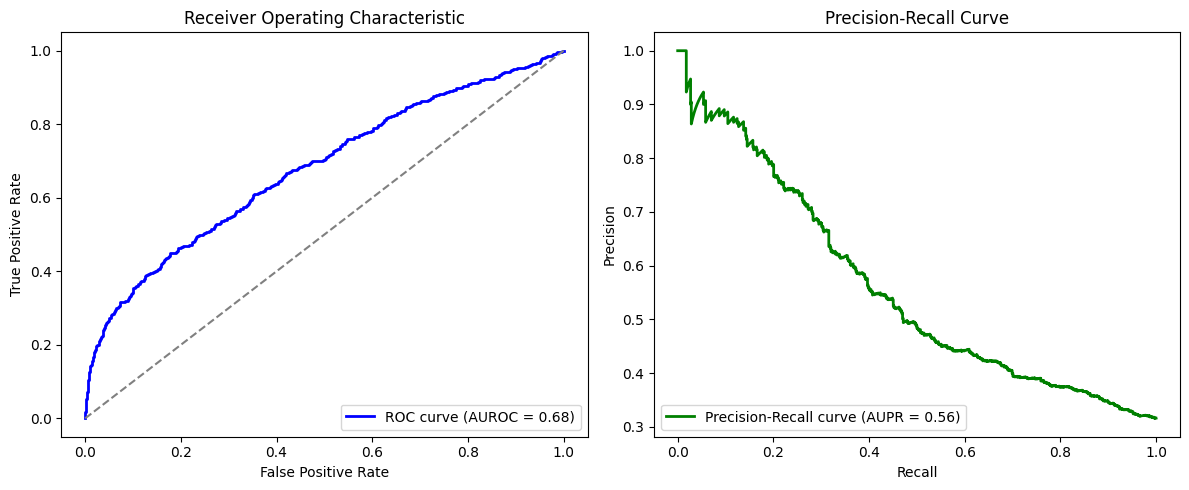

In [200]:
selector = SelectKBest(score_func=f_classif, k=31)
selector.fit(X_train, y_train)
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)
X_val_selected = selector.transform(X_val)
selected_features = feature_dataset.iloc[:, 2: 282].columns[selector.get_support()]
print(selected_features)

# Train Logistic Regression model
model = LogisticRegression()
model.fit(X_train_selected, y_train)  # X_train, y_train are your training features and target labels

# Get predicted probabilities
y_prob = model.predict_proba(X_val_selected)[:, 1]  # Get the probability for class 1 (positive class)

# Compute AUROC
auroc = roc_auc_score(y_val, y_prob)

# Compute AUPR
aupr = average_precision_score(y_val, y_prob)

# Print AUROC and AUPR
print(f"AUROC: {auroc}")
print(f"AUPR: {aupr}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_val, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(12, 5))

# Plot ROC curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUROC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

# Plot Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_val, y_prob)

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='green', lw=2, label=f'Precision-Recall curve (AUPR = {aupr:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')

# Show the plots
plt.tight_layout()
plt.show()

# Noise as a Regression Problem

In [ ]:
class PromoterNoiseDataset(torch.utils.data.IterableDataset):
    def __init__(self, promoter_data, context_length):
        """
        Initializes the dataset.
        Args:
            promoter_data (pd.DataFrame): A dataframe with columns 'promoter_sequence' and 'gene_noise'.
            context_length (int): Length of the context (fixed length for sequences).
        """
        super(PromoterNoiseDataset, self).__init__()
        self.promoter_data = promoter_data
        self.context_length = context_length

    def __iter__(self):
        """
        Generator for iterating over the dataset.
        Yields:
            Tuple (np.ndarray, float): One-hot encoded promoter sequence and its associated noise value.
        """
        for i, row in enumerate(self.promoter_data.itertuples()):
            seq = row.Promoter
            if len(seq) >= self.context_length:
                # Extract the last portion of the promoter sequence (end part) since that is the primary promoter i.e. closest to TSS
                seq = seq[-self.context_length:]  # Extract the last 'context_length' base pairs
            # One-hot encode the sequence
            seq_encoded = one_hot(seq)
            # Yield the one-hot encoded sequence and the gene noise as a tuple
            yield (seq_encoded, np.float32(row.Noise))

In [ ]:
from sklearn.model_selection import train_test_split

# Assuming df contains the 'Promoter' and 'Noise' columns
X = df[['Promoter', 'Noise']]

# Split the DataFrame into train and test sets
train_df, test_df = train_test_split(X, test_size=0.2, random_state=42)

In [ ]:
class CNN_1d(nn.Module):

    def __init__(self,
                 n_output_channels = 1,        # Predicting one value (gene noise)
                 filter_widths = [15,5],      # Size of convolutional filters
                 num_chunks = 120,               # Number of chunks in sequence context
                 max_pool_factor = 4,          # Max-pooling factor
                 nchannels = [4, 32],      # Number of channels at each layer (start with 4 for one-hot encoding)
                 n_hidden = 32,                # Hidden layer size
                 dropout = 0.2):               # Dropout for regularization

        super(CNN_1d, self).__init__()
        self.rf = 0  # Running estimate of the receptive field
        self.chunk_size = 1  # Running estimate of num basepairs corresponding to one position after convolutions

        # Define convolutional layers
        conv_layers = []
        for i in range(len(nchannels)-1):
            conv_layers += [ nn.Conv1d(nchannels[i], nchannels[i+1], filter_widths[i], padding = 0),
                             nn.BatchNorm1d(nchannels[i+1]),  # Batch normalization
                             nn.Dropout2d(dropout),          # Dropout regularization
                             nn.MaxPool1d(max_pool_factor),  # Max pooling
                             #nn.ELU(inplace=True)           # Activation function (ELU)
                            ]

            # Update receptive field
            self.rf += (filter_widths[i] - 1) * self.chunk_size
            self.chunk_size *= max_pool_factor

        # Sequence length
        self.seq_len = num_chunks * self.chunk_size + self.rf  # Amount of sequence context required

        print("Receptive field:", self.rf, "Chunk size:", self.chunk_size, "Number chunks:", num_chunks)
        print("Sequence length (seq_len):", self.seq_len)

        # Define dense layers
        self.conv_net = nn.Sequential(*conv_layers)

        # Final dense layers for regression
        self.dense_net = nn.Sequential(
            nn.Linear(nchannels[-1] * num_chunks, n_hidden),  # Flattening the output
            nn.Dropout(dropout),
            nn.ELU(inplace=True),
            nn.Linear(n_hidden, n_output_channels)  # Output layer for regression (1 value)
        )

    def forward(self, x):
        net = self.conv_net(x)  # Apply convolutional layers
        net = net.view(net.size(0), -1)  # Flatten the output
        net = self.dense_net(net)  # Apply fully connected layers
        return net  # Return the predicted gene noise value

# Create the model
cnn_1d = CNN_1d()

# Print input length to match sequence length in the dataset
print("Input length (seq_len):", cnn_1d.seq_len)

cnn_1d

Receptive field: 30 Chunk size: 16 Number chunks: 30
Sequence length (seq_len): 510
Input length (seq_len): 510


CNN_1d(
  (conv_net): Sequential(
    (0): Conv1d(4, 32, kernel_size=(15,), stride=(1,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout2d(p=0.2, inplace=False)
    (3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (4): Conv1d(32, 32, kernel_size=(5,), stride=(1,))
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout2d(p=0.2, inplace=False)
    (7): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (dense_net): Sequential(
    (0): Linear(in_features=960, out_features=32, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [ ]:
import torch.nn.functional as F

def run_one_epoch(train_flag, dataloader, cnn_1d, optimizer, device="cuda"):
    torch.set_grad_enabled(train_flag)
    cnn_1d.train() if train_flag else cnn_1d.eval()

    losses = []
    r2_scores = []  # We'll track R^2 score for regression

    for (x, y) in dataloader:  # Collection of tuples from the iterator
        (x, y) = (x.to(device), y.to(device))  # Transfer data to GPU

        output = cnn_1d(x)  # Forward pass
        output = output.squeeze()  # Remove spurious channel dimension

        # Calculate loss using MSE for regression
        loss = F.mse_loss(output, y)

        if train_flag:
            loss.backward()  # Backpropagation
            optimizer.step()
            optimizer.zero_grad()

        losses.append(loss.detach().cpu().numpy())

        # Calculate R^2 score
        r2 = 1 - (torch.sum((y - output) ** 2) / torch.sum((y - y.mean()) ** 2)).detach().cpu().numpy()
        r2_scores.append(r2)

    return np.mean(losses), np.mean(r2_scores)  # Return loss and R^2 score


In [ ]:
import timeit

def train_model(cnn_1d, train_data, validation_data, epochs=100, patience=10, verbose = True):
    """
    Train a 1D CNN model and record accuracy metrics.
    """
    # Move the model to the GPU here to make it runs there, and set "device" as above
    # TODO CODE
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    cnn_1d.to(device)
    print(device)

    # 1. Make new PromoterNoiseDataset and DataLoader objects for both training and validation data.
    # TODO CODE
    train_dataset = PromoterNoiseDataset(train_data, cnn_1d.seq_len)
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=256, num_workers = 0)
    validation_dataset = PromoterNoiseDataset(validation_data, cnn_1d.seq_len)
    validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=256)

    # 2. Instantiates an optimizer for the model.
    # TODO CODE
    optimizer = torch.optim.Adam(cnn_1d.parameters(), amsgrad=True)

    # 3. Run the training loop with early stopping.
    # TODO CODE
    train_r2 = []
    val_r2 = []
    patience_counter = patience
    best_val_loss = np.inf
    check_point_filename = 'cnn_1d_checkpoint.pt' # to save the best model fit to date
    for epoch in range(epochs):
        start_time = timeit.default_timer()
        train_loss, train_r2_epoch = run_one_epoch(True, train_dataloader, cnn_1d, optimizer, device)
        val_loss, val_r2_epoch = run_one_epoch(False, validation_dataloader, cnn_1d, optimizer, device)
        train_r2.append(train_r2_epoch)
        val_r2.append(val_r2_epoch)
        if val_loss < best_val_loss:
            torch.save(cnn_1d.state_dict(), check_point_filename)
            best_val_loss = val_loss
            patience_counter = patience
        else:
            patience_counter -= 1
            if patience_counter <= 0:
                cnn_1d.load_state_dict(torch.load(check_point_filename)) # recover the best model so far
                break
        if verbose:
            elapsed = float(timeit.default_timer() - start_time)
            print("Epoch %i took %.2fs. Train loss: %.4f R2: %.4f. Val loss: %.4f R2: %.4f. Patience left: %i" %
                  (epoch+1, elapsed, train_loss, train_r2_epoch, val_loss, val_r2_epoch, patience_counter ))

    # 4. Return the fitted model (not strictly necessary since this happens "in place"), train and validation r2.
    # TODO CODE
    return cnn_1d, train_r2, val_r2

In [ ]:
my_cnn1d = CNN_1d()
print(my_cnn1d.seq_len)
my_cnn1d
my_cnn1d, train_r2, val_r2 = train_model(my_cnn1d, train_df, test_df,patience=25)

Receptive field: 14 Chunk size: 4 Number chunks: 120
Sequence length (seq_len): 494
494
cpu
Epoch 1 took 4.34s. Train loss: 15.6357 R2: -3318.4998. Val loss: 0.5989 R2: -172.8198. Patience left: 25
Epoch 2 took 3.20s. Train loss: 1.5268 R2: -315.7073. Val loss: 0.7420 R2: -220.3382. Patience left: 24
Epoch 3 took 3.21s. Train loss: 0.2976 R2: -64.1507. Val loss: 0.1270 R2: -34.5869. Patience left: 25
Epoch 4 took 3.24s. Train loss: 0.1076 R2: -23.3936. Val loss: 0.0414 R2: -10.6336. Patience left: 25
Epoch 5 took 4.24s. Train loss: 0.0639 R2: -14.8788. Val loss: 0.0419 R2: -10.3227. Patience left: 24
Epoch 6 took 3.22s. Train loss: 0.0593 R2: -13.9987. Val loss: 0.0338 R2: -8.1263. Patience left: 25
Epoch 7 took 3.08s. Train loss: 0.0525 R2: -11.8526. Val loss: 0.0322 R2: -7.6057. Patience left: 25
Epoch 8 took 3.24s. Train loss: 0.0500 R2: -11.5537. Val loss: 0.0327 R2: -7.6358. Patience left: 24
Epoch 9 took 4.23s. Train loss: 0.0491 R2: -10.9236. Val loss: 0.0301 R2: -6.8739. Patien

# Noise as a classification problem

In [205]:
class PromoterNoiseClassificationDataset(torch.utils.data.IterableDataset):
    def __init__(self, promoter_data, context_length):
        """
        Initializes the dataset.
        Args:
            promoter_data (pd.DataFrame): A dataframe with columns 'promoter_sequence' and 'gene_noise'.
            context_length (int): Length of the context (fixed length for sequences).
        """
        super(PromoterNoiseClassificationDataset, self).__init__()
        self.promoter_data = promoter_data
        self.context_length = context_length

    def __iter__(self):
        """
        Generator for iterating over the dataset.
        Yields:
            Tuple (np.ndarray, float): One-hot encoded promoter sequence and its associated classification of whether the gene is noisy (1) or not (0).
        """
        for i, row in enumerate(self.promoter_data.itertuples()):
            seq = row.Promoter
            if len(seq) >= self.context_length:
                # Extract the last portion of the promoter sequence (end part) since that is the primary promoter i.e. closest to TSS
                seq = seq[-self.context_length:]  # Extract the last 'context_length' base pairs
            # One-hot encode the sequence
            seq_encoded = one_hot(seq)
            # Yield the one-hot encoded sequence and the gene noise as a tuple
            yield (seq_encoded, np.float32(row.high_noise))

In [217]:
from sklearn.model_selection import train_test_split

# Assuming df contains the 'Promoter' and 'high_noise' columns
X_classification = df[['Promoter', 'high_noise']]

# Step 1: Split the data into 70% training and 30% temporary (to be split into validation and test)
train_classification_df, temp_classification_df = train_test_split(X_classification, test_size=0.3, random_state=40) #random_state=42

# Step 2: Split the temporary data into 50% validation and 50% test
val_classification_df, test_classification_df = train_test_split(temp_classification_df, test_size=0.5, random_state=40) #random_state=42

# Check the sizes of the resulting datasets
print(f"Training data size: {len(train_classification_df)}")  # 70%
print(f"Validation data size: {len(val_classification_df)}")  # 15%
print(f"Test data size: {len(test_classification_df)}") # 15%

print(train_classification_df.head())
print(train_classification_df['high_noise'].sum() / len(train_classification_df))
print(val_classification_df['high_noise'].sum() / len(val_classification_df))
print(test_classification_df['high_noise'].sum() / len(test_classification_df))

Training data size: 4056
Validation data size: 869
Test data size: 870
                                               Promoter  high_noise
540   GTTCCTGATCAATGGGGGATTCAACAAATCTCCAAACACCGCCACC...           1
4183  AACTTCAACAACTCTTGATGTCTAGCCTGTACTTCGGCCAATGCTG...           1
1488  GGATCCAGACCCAGACCCGTTTCCAGATCCGGATCCGTATTCGTTC...           1
3775  GGCGAAAGAGCTGTGTATGAGAATAACGAGACCGGTGTCATTAAGA...           0
3835  CTGACTTACAGGGTTCTGAAGACCACTCTTTCAGAAAAATCAAATT...           0
0.29561143984220906
0.30264672036823936
0.3195402298850575


In [207]:
class CNN_classification_1d(nn.Module):

    def __init__(self,
                 n_output_channels = 1,
                 filter_widths = [15, 5],
                 num_chunks = 30,
                 max_pool_factor = 4,
                 nchannels = [4, 32, 32],
                 n_hidden = 32,
                 dropout = 0.2):

        super(CNN_classification_1d, self).__init__()
        self.rf = 0 # running estimate of the receptive field
        self.chunk_size = 1 # running estimate of num basepairs corresponding to one position after convolutions

        conv_layers = []

        for i in range(len(nchannels)-1):
            conv_layers += [ nn.Conv1d(nchannels[i], nchannels[i+1], filter_widths[i], padding=0),
                        nn.BatchNorm1d(nchannels[i+1]), # tends to help give faster convergence: https://arxiv.org/abs/1502.03167
                        nn.Dropout1d(dropout), # popular form of regularization: https://jmlr.org/papers/v15/srivastava14a.html #updated to dropout1D function
                        nn.MaxPool1d(max_pool_factor),
                        nn.ELU(inplace=True)  ] # popular alternative to ReLU: https://arxiv.org/abs/1511.07289
            assert(filter_widths[i] % 2 == 1) # assume this
            self.rf += (filter_widths[i] - 1) * self.chunk_size
            self.chunk_size *= max_pool_factor

        # If you have a model with lots of layers, you can create a list first and
        # then use the * operator to expand the list into positional arguments, like this:
        self.conv_net = nn.Sequential(*conv_layers)

        self.seq_len = num_chunks * self.chunk_size + self.rf # amount of sequence context required

        print("Receptive field:", self.rf, "Chunk size:", self.chunk_size, "Number chunks:", num_chunks)

        self.dense_net = nn.Sequential( nn.Linear(nchannels[-1] * num_chunks, n_hidden),
                                        nn.Dropout1d(dropout),
                                        nn.ELU(inplace=True),
                                        nn.Linear(n_hidden, n_output_channels) )

    def forward(self, x):
        net = self.conv_net(x)
        net = net.view(net.size(0), -1)
        net = self.dense_net(net)
        return(net)

cnn_classification_1d = CNN_classification_1d()

print("Input length:", cnn_classification_1d.seq_len)

cnn_classification_1d

Receptive field: 30 Chunk size: 16 Number chunks: 30
Input length: 510


CNN_classification_1d(
  (conv_net): Sequential(
    (0): Conv1d(4, 32, kernel_size=(15,), stride=(1,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout1d(p=0.2, inplace=False)
    (3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (4): ELU(alpha=1.0, inplace=True)
    (5): Conv1d(32, 32, kernel_size=(5,), stride=(1,))
    (6): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout1d(p=0.2, inplace=False)
    (8): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (9): ELU(alpha=1.0, inplace=True)
  )
  (dense_net): Sequential(
    (0): Linear(in_features=960, out_features=32, bias=True)
    (1): Dropout1d(p=0.2, inplace=False)
    (2): ELU(alpha=1.0, inplace=True)
    (3): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [208]:
import torch.nn.functional as F
from sklearn.metrics import precision_recall_fscore_support
def run_one_classification_epoch(train_flag, dataloader, cnn_1d, optimizer, device="cuda"):

    torch.set_grad_enabled(train_flag)
    cnn_1d.train() if train_flag else cnn_1d.eval()
    pos_weight = torch.tensor([0.7 / 0.3], device=device)
    #pos_weight = torch.tensor([5], device=device)

    losses = []
    accuracies = []
    all_preds = []  # To store all predictions for F1 score
    all_labels = []  # To store all true labels for F1 score

    for (x,y) in dataloader: # collection of tuples with iterator

        (x, y) = ( x.to(device), y.to(device) ) # transfer data to GPU

        output = cnn_1d(x) # forward pass
        output = output.squeeze() # remove spurious channel dimension
        #loss = F.binary_cross_entropy_with_logits( output, y ) # numerically stable
        loss = F.binary_cross_entropy_with_logits( output, y , pos_weight=pos_weight) # numerically stable

        if train_flag:
            loss.backward() # back propagation
            optimizer.step()
            optimizer.zero_grad()

        losses.append(loss.detach().cpu().numpy())
        accuracy = torch.mean( ( (output > 0.0) == (y > 0.5) ).float() ) # output is in logit space so threshold is 0.
        accuracies.append(accuracy.detach().cpu().numpy())

        # Convert logits to binary predictions using threshold 0.0
        preds = (output > 0.0).float()
        all_preds.append(preds.detach().cpu().numpy())
        all_labels.append(y.detach().cpu().numpy())

    # Compute overall precision, recall, F1-score
    #print(all_preds[1])
    #print(all_labels[1])
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='binary', zero_division=0
    )

    return( np.mean(losses), np.mean(accuracies), precision, recall, f1 )

In [209]:
import timeit

def train_classification_model(cnn_classification_1d, train_data, validation_data, epochs=100, patience=10, verbose = True, plot = True):
    """
    Train a 1D CNN model and record accuracy metrics.
    """
    # Move the model to the GPU here to make it runs there, and set "device" as above
    # TODO CODE
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    cnn_classification_1d.to(device)
    print(device)

    # 1. Make new BedPeakDataset and DataLoader objects for both training and validation data.
    # TODO CODE
    train_dataset = PromoterNoiseClassificationDataset(train_data, cnn_classification_1d.seq_len)
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=256, num_workers = 0)
    validation_dataset = PromoterNoiseClassificationDataset(validation_data, cnn_classification_1d.seq_len)
    validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=256)

    # 2. Instantiates an optimizer for the model.
    # TODO CODE
    optimizer = torch.optim.Adam(cnn_classification_1d.parameters(), amsgrad=True)

    # 3. Run the training loop with early stopping.
    # TODO CODE
    train_accs = []
    val_accs = []
    train_f1s = []
    val_f1s = []
    train_precisions = []
    val_precisions = []
    train_recalls = []
    val_recalls = []

    patience_counter = patience
    best_val_loss = np.inf
    check_point_filename = 'cnn_classification_1d_checkpoint.pt' # to save the best model fit to date
    for epoch in range(epochs):
        start_time = timeit.default_timer()
        train_loss, train_acc, train_precision, train_recall, train_f1 = run_one_classification_epoch(True, train_dataloader, cnn_classification_1d, optimizer, device)
        val_loss, val_acc, val_precision, val_recall, val_f1 = run_one_classification_epoch(False, validation_dataloader, cnn_classification_1d, optimizer, device)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        train_f1s.append(train_f1)
        val_f1s.append(val_f1)
        train_precisions.append(train_precision)
        val_precisions.append(val_precision)
        train_recalls.append(train_recall)
        val_recalls.append(val_recall)
        if val_loss < best_val_loss:
            torch.save(cnn_classification_1d.state_dict(), check_point_filename)
            best_val_loss = val_loss
            patience_counter = patience
        else:
            patience_counter -= 1
            if patience_counter <= 0:
                cnn_classification_1d.load_state_dict(torch.load(check_point_filename)) # recover the best model so far
                break
        if verbose:
            elapsed = float(timeit.default_timer() - start_time)
            print("Epoch %i took %.2fs. "
            "Train loss: %.4f, Train acc: %.4f, Train F1: %.4f, Train Precision: %.4f, Train Recall: %.4f. "
            "Val loss: %.4f, Val acc: %.4f, Val F1: %.4f, Val Precision: %.4f, Val Recall: %.4f. "
            "Patience left: %i" %
            (epoch+1, elapsed,
            train_loss, train_acc, train_f1, train_precision, train_recall,
            val_loss, val_acc, val_f1, val_precision, val_recall,
            patience_counter))
    if plot:
        # Plot the metrics
        epochs = range(1, len(train_accs) + 1)

        plt.figure(figsize=(12, 8))

        # Plot accuracy
        plt.subplot(2, 2, 1)
        plt.plot(epochs, train_accs, label="Train Accuracy")
        plt.plot(epochs, val_accs, label="Validation Accuracy")
        plt.title("Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()

        # Plot F1 Score
        plt.subplot(2, 2, 2)
        plt.plot(epochs, train_f1s, label="Train F1 Score")
        plt.plot(epochs, val_f1s, label="Validation F1 Score")
        plt.title("F1 Score")
        plt.xlabel("Epoch")
        plt.ylabel("F1 Score")
        plt.legend()

        # Plot Precision
        plt.subplot(2, 2, 3)
        plt.plot(epochs, train_precisions, label="Train Precision")
        plt.plot(epochs, val_precisions, label="Validation Precision")
        plt.title("Precision")
        plt.xlabel("Epoch")
        plt.ylabel("Precision")
        plt.legend()

        # Plot Recall
        plt.subplot(2, 2, 4)
        plt.plot(epochs, train_recalls, label="Train Recall")
        plt.plot(epochs, val_recalls, label="Validation Recall")
        plt.title("Recall")
        plt.xlabel("Epoch")
        plt.ylabel("Recall")
        plt.legend()

        plt.tight_layout()
        plt.show()
    # 4. Return the fitted model (not strictly necessary since this happens "in place"), train and validation accuracies.
    # TODO CODE
    return cnn_classification_1d, train_accs, val_accs, train_f1s, val_f1s, train_precisions, val_precisions, train_recalls, val_recalls

Receptive field: 6 Chunk size: 3 Number chunks: 170
516
cpu
Epoch 1 took 1.45s. Train loss: 1.0037, Train acc: 0.5485, Train F1: 0.3140, Train Precision: 0.2846, Train Recall: 0.3503. Val loss: 0.9818, Val acc: 0.6687, Val F1: 0.0719, Val Precision: 0.2558, Val Recall: 0.0418. Patience left: 10
Epoch 2 took 1.40s. Train loss: 0.9700, Train acc: 0.6010, Train F1: 0.2902, Train Precision: 0.3059, Train Recall: 0.2761. Val loss: 0.9827, Val acc: 0.6535, Val F1: 0.1595, Val Precision: 0.3182, Val Recall: 0.1065. Patience left: 9
Epoch 3 took 1.35s. Train loss: 0.9619, Train acc: 0.5880, Train F1: 0.3513, Train Precision: 0.3283, Train Recall: 0.3778. Val loss: 0.9840, Val acc: 0.6490, Val F1: 0.1534, Val Precision: 0.3034, Val Recall: 0.1027. Patience left: 8
Epoch 4 took 1.43s. Train loss: 0.9573, Train acc: 0.6206, Train F1: 0.3608, Train Precision: 0.3589, Train Recall: 0.3628. Val loss: 0.9804, Val acc: 0.5932, Val F1: 0.3116, Val Precision: 0.3238, Val Recall: 0.3004. Patience left: 1

<ipython-input-209-e0dbe18e07b9>:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_classification_1d.load_state_dict(torch.load(check_point_filename)) # recover the best

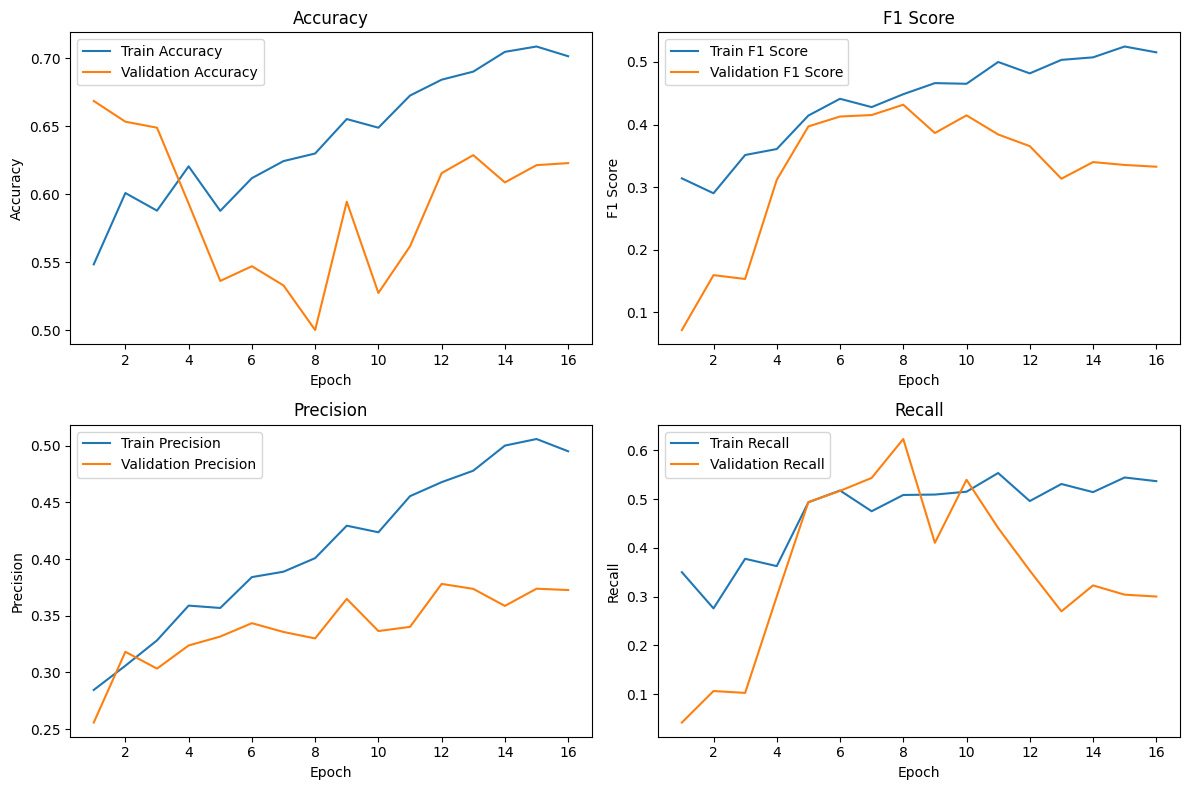

In [218]:
# reducing to single layer
my_classification_cnn1d = CNN_classification_1d(filter_widths = [7],#[3], #tested 3 (0.23), 5 (0.396) , 7 (0.38), 9 (0.31)
                 #strides = [2],
                 #conv_strides = [2],
                 #pool_strides = [1],
                 num_chunks = 170, #250, #170
                 max_pool_factor = 3, #2, # tried 2 (0.33- 0.4 with 160 num_chunks (reduces when num_chunks increased) ), 4 (0.2-0.36), 3 (0.38)
                 nchannels = [4, 10], # 10 (0.39), 16(0.25)
                 n_hidden= 8, #4, # 16 (0.4), 8 (0.38), 10 (0.33-0.41), 20 (0.35), 9 (0.38-0.41)
                 dropout=0.2) #0.3
print(my_classification_cnn1d.seq_len)
my_classification_cnn1d
my_classification_cnn1d, train_accs, val_accs, train_f1s, val_f1s, train_precisions, val_precisions, train_recalls, val_recalls = train_classification_model(my_classification_cnn1d, train_classification_df, val_classification_df, patience = 10)

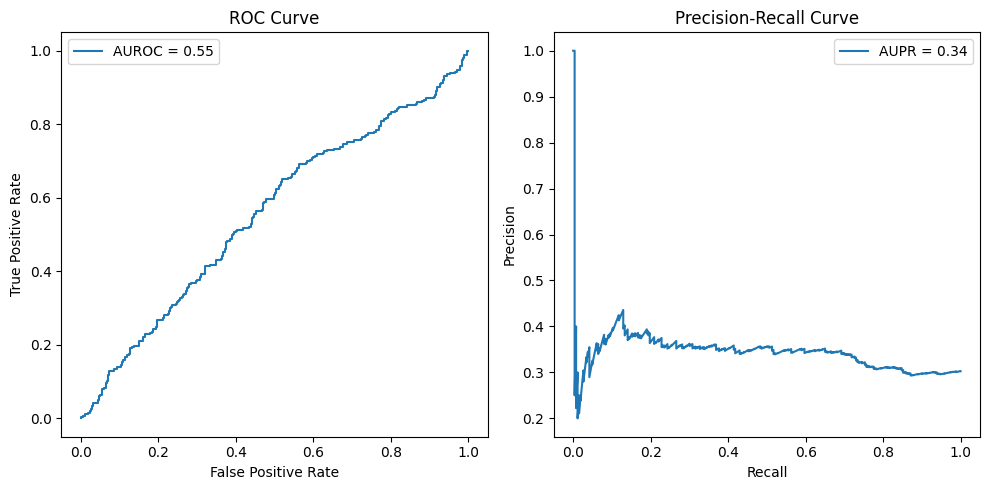

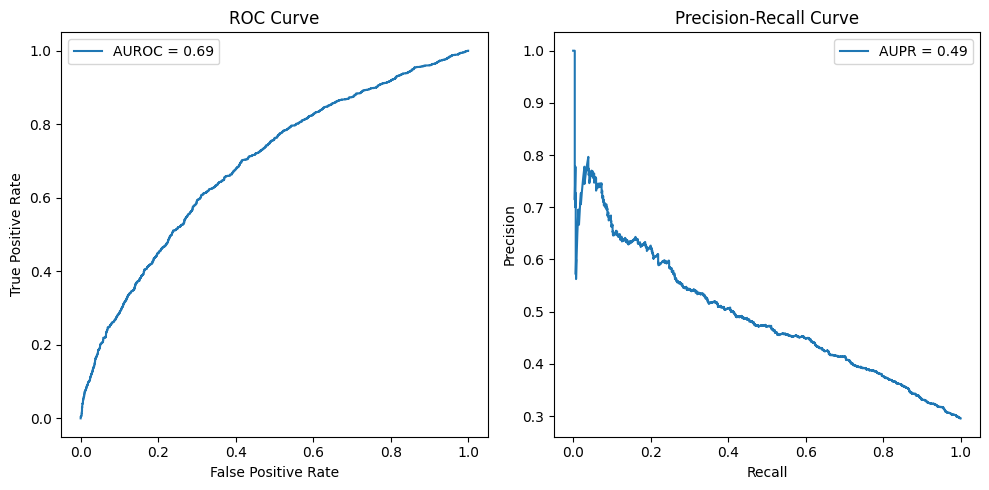

AUROC: 0.6896
AUPR: 0.4908


In [219]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, roc_curve
import matplotlib.pyplot as plt

def evaluate_model(cnn_1d, dataloader, device="cuda"):
    cnn_1d.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for (x, y) in dataloader:
            x, y = x.to(device), y.to(device)
            output = cnn_1d(x)  # Forward pass
            output = cnn_1d(x).squeeze()  # Get logits
            all_preds.append(output.cpu().numpy())
            all_labels.append(y.cpu().numpy())

    # Concatenate all predictions and labels
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    # Compute AUROC
    auroc = roc_auc_score(all_labels, all_preds)

    # Compute Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(all_labels, all_preds)
    aupr = auc(recall, precision)

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(all_labels, all_preds)
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f"AUROC = {auroc:.2f}")
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()

    # Plot Precision-Recall Curve
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label=f"AUPR = {aupr:.2f}")
    plt.title("Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()

    plt.tight_layout()
    plt.show()

    return auroc, aupr

# Call the function with your trained model and test dataloader
validation_dataset = PromoterNoiseClassificationDataset(val_classification_df, my_classification_cnn1d.seq_len)
validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=256)
#auroc, aupr = evaluate_model(cnn_classification_1d, validation_dataloader, "cpu")
auroc, aupr = evaluate_model(my_classification_cnn1d, validation_dataloader, "cpu")

train_dataset = PromoterNoiseClassificationDataset(train_classification_df, my_classification_cnn1d.seq_len)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=256)
#auroc, aupr = evaluate_model(cnn_classification_1d, train_dataloader, "cpu")
auroc, aupr = evaluate_model(my_classification_cnn1d, train_dataloader, "cpu")

print(f"AUROC: {auroc:.4f}")
print(f"AUPR: {aupr:.4f}")

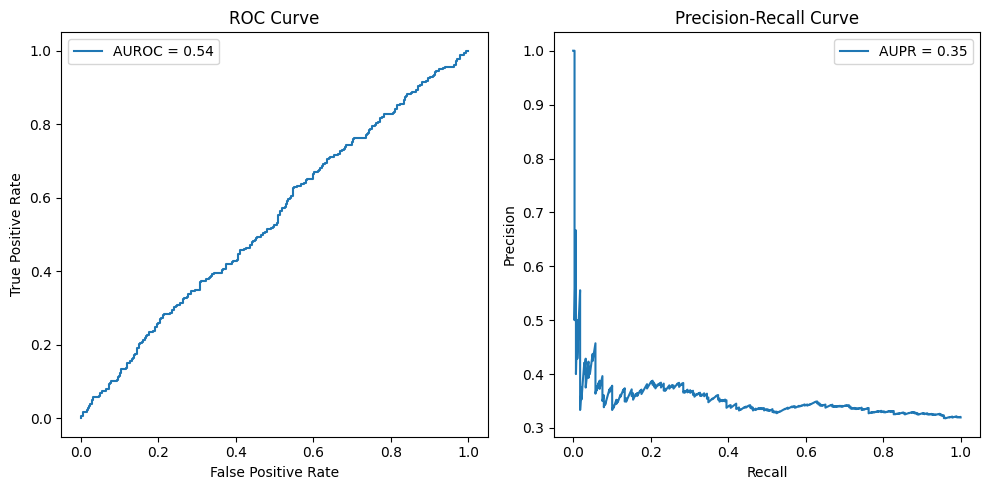

AUROC: 0.5379
AUPR: 0.3522


In [220]:
test_dataset = PromoterNoiseClassificationDataset(test_classification_df, my_classification_cnn1d.seq_len)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=256)
#auroc, aupr = evaluate_model(cnn_classification_1d, test_dataloader, "cpu")
auroc, aupr = evaluate_model(my_classification_cnn1d, test_dataloader, "cpu")

print(f"AUROC: {auroc:.4f}")
print(f"AUPR: {aupr:.4f}")

Receptive field: 0 Chunk size: 2 Number chunks: 250
500
cpu


<ipython-input-12-e0dbe18e07b9>:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_classification_1d.load_state_dict(torch.load(check_point_filename)) # recover the best 

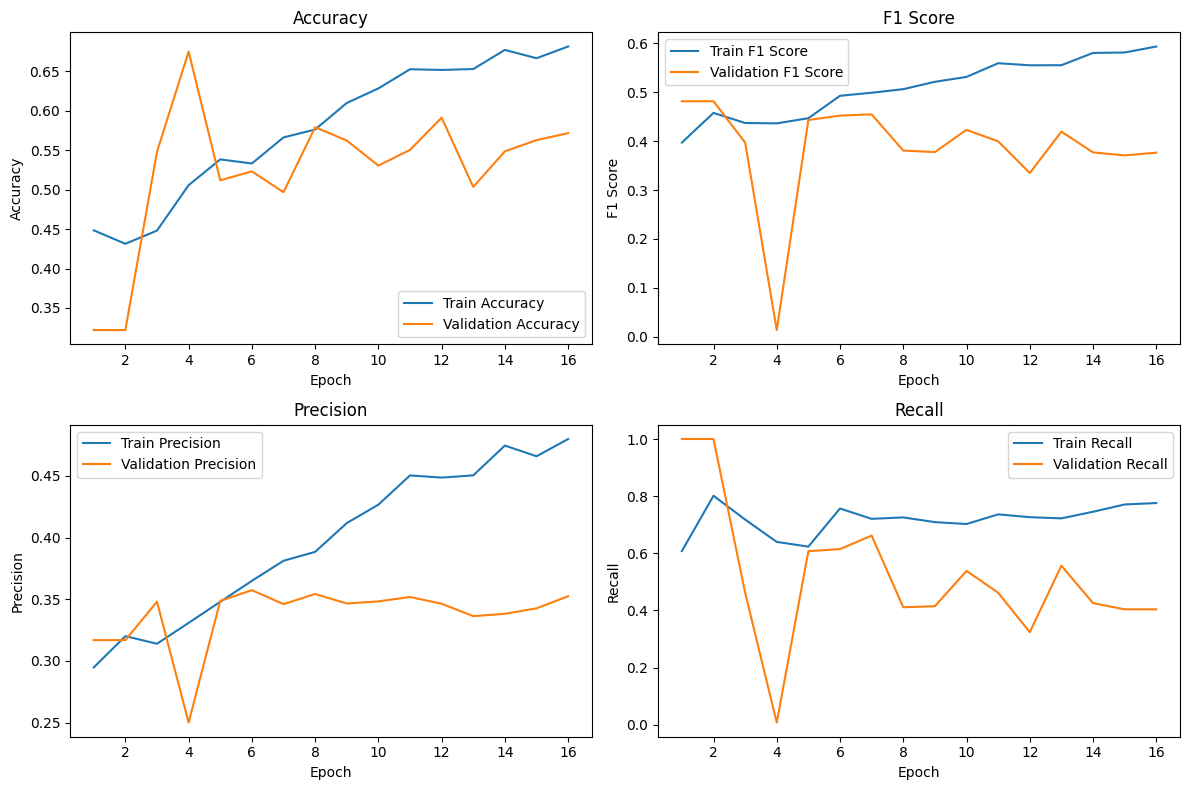

Receptive field: 2 Chunk size: 2 Number chunks: 250
502
cpu


<ipython-input-12-e0dbe18e07b9>:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_classification_1d.load_state_dict(torch.load(check_point_filename)) # recover the best 

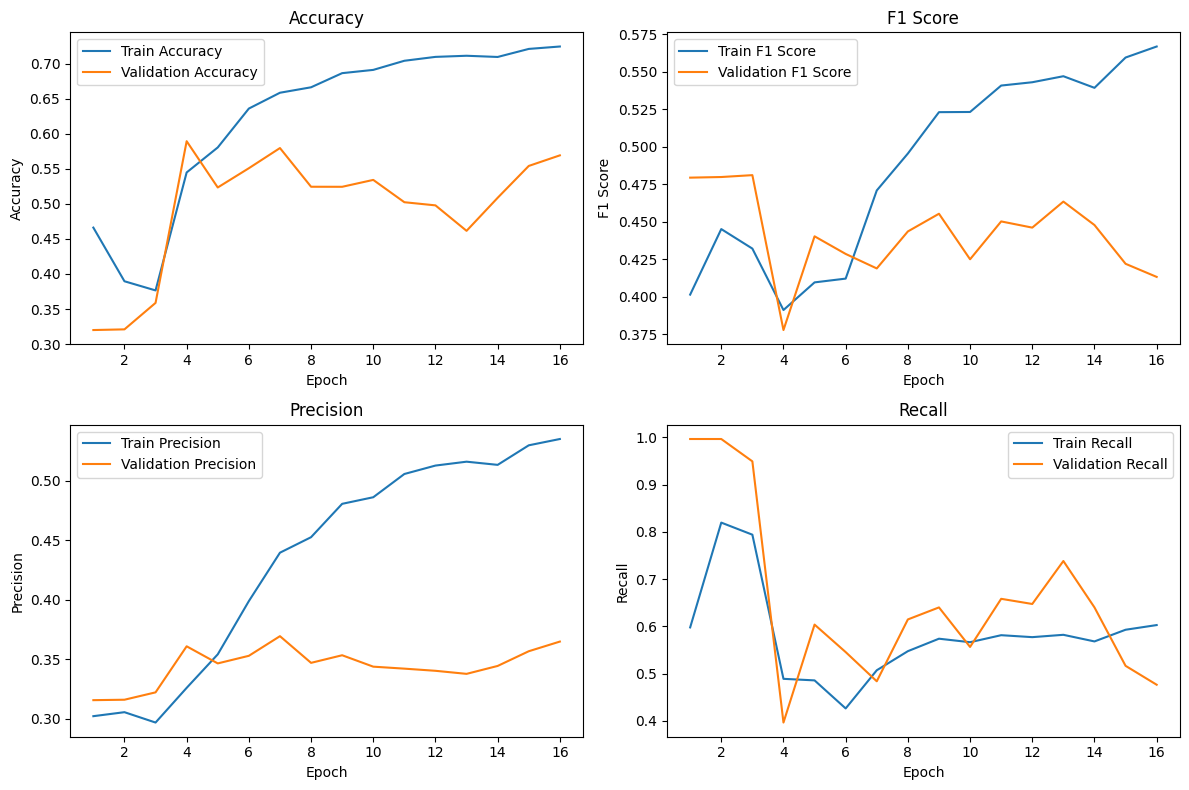

Receptive field: 4 Chunk size: 2 Number chunks: 250
504
cpu


<ipython-input-12-e0dbe18e07b9>:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_classification_1d.load_state_dict(torch.load(check_point_filename)) # recover the best 

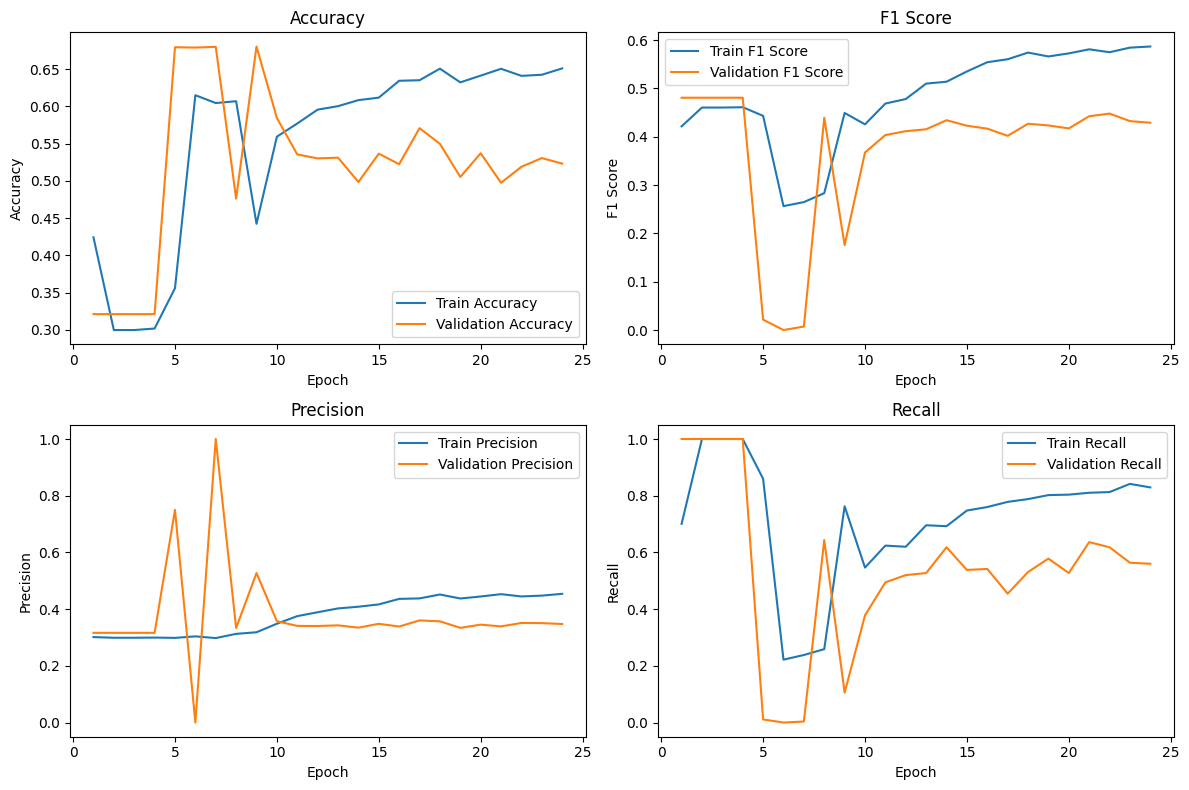

Receptive field: 6 Chunk size: 2 Number chunks: 250
506
cpu


<ipython-input-12-e0dbe18e07b9>:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_classification_1d.load_state_dict(torch.load(check_point_filename)) # recover the best 

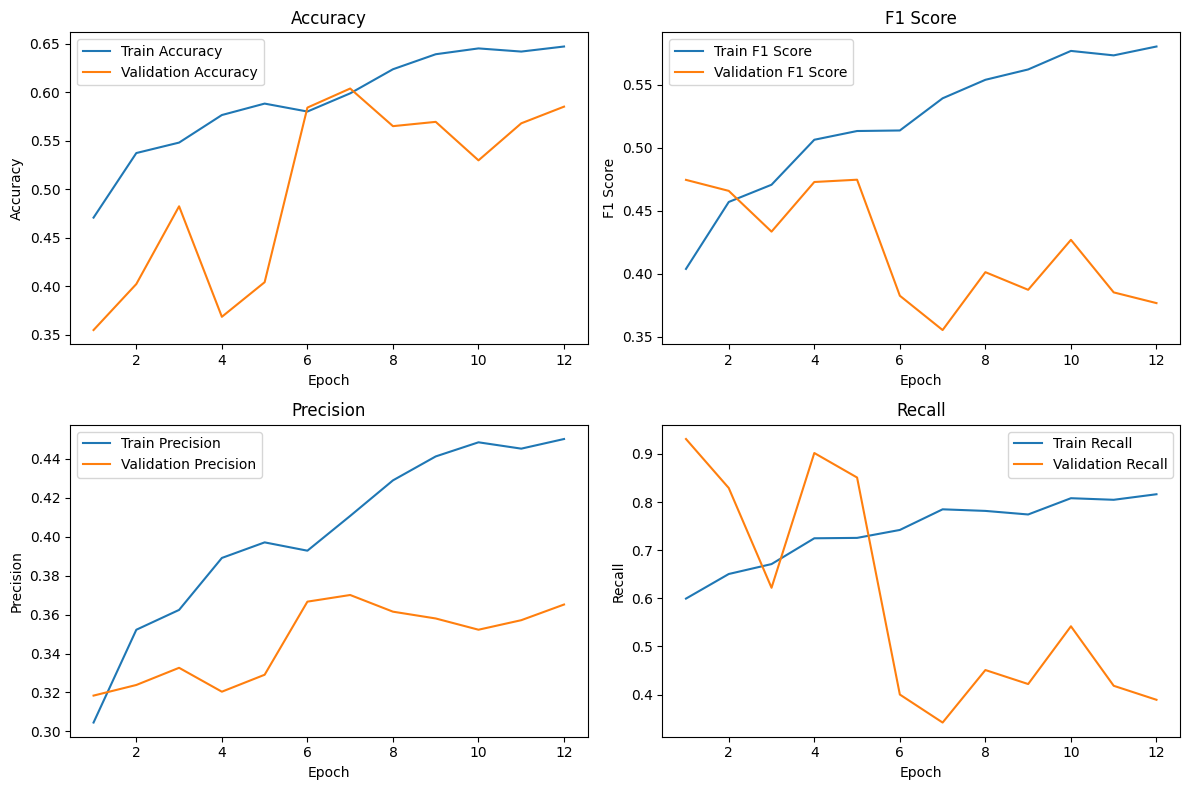

Receptive field: 8 Chunk size: 2 Number chunks: 250
508
cpu


<ipython-input-12-e0dbe18e07b9>:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_classification_1d.load_state_dict(torch.load(check_point_filename)) # recover the best 

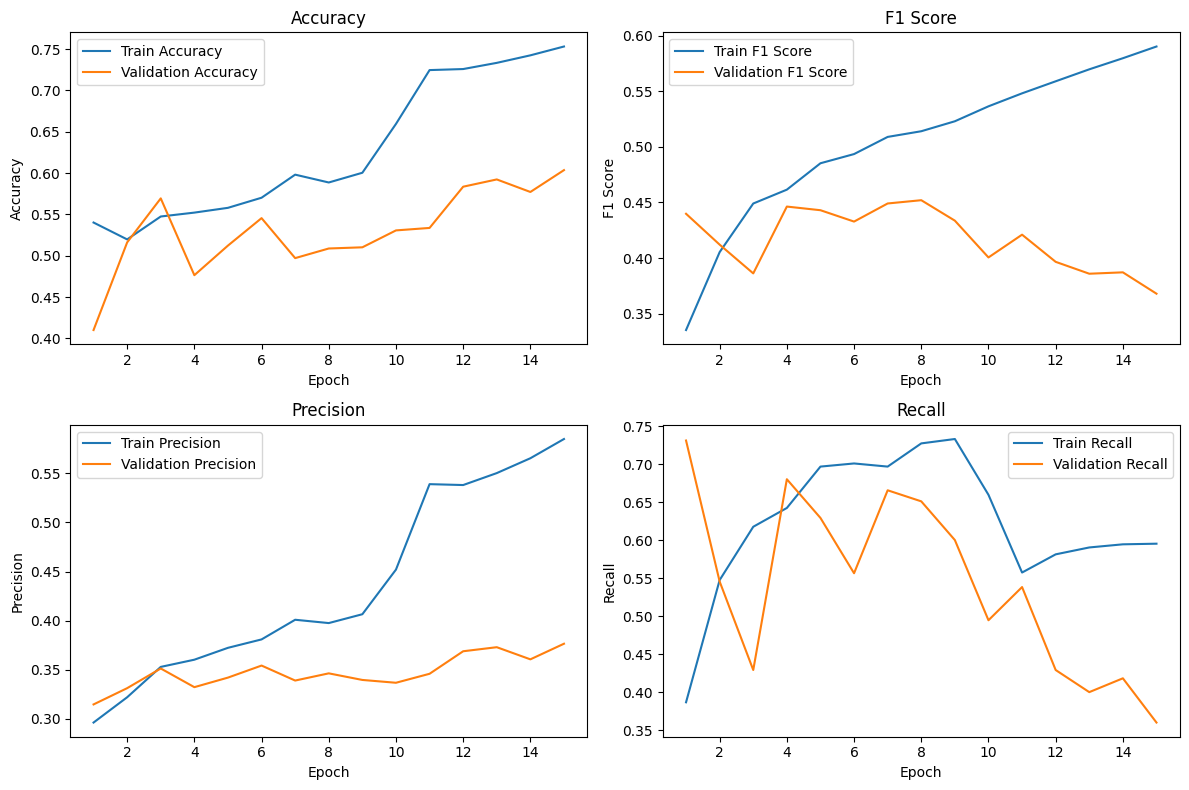

Receptive field: 10 Chunk size: 2 Number chunks: 250
510
cpu


<ipython-input-12-e0dbe18e07b9>:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_classification_1d.load_state_dict(torch.load(check_point_filename)) # recover the best 

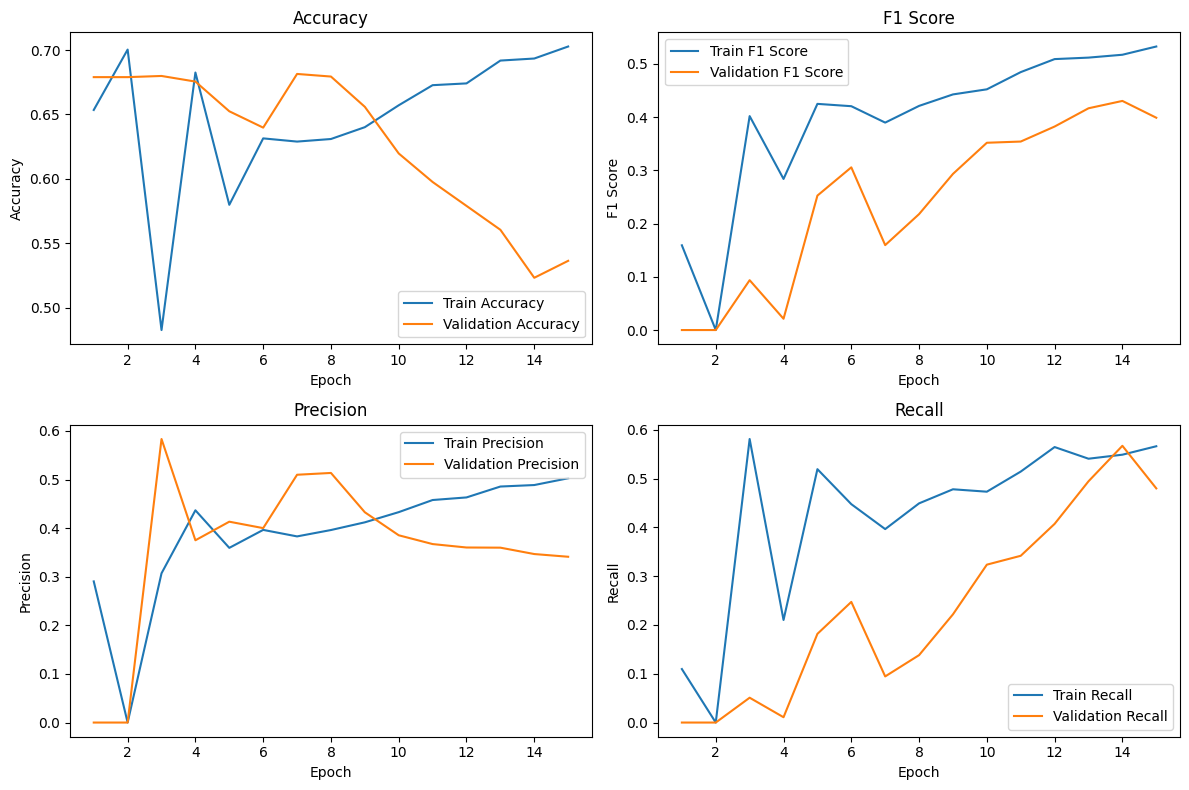

Receptive field: 12 Chunk size: 2 Number chunks: 250
512
cpu


<ipython-input-12-e0dbe18e07b9>:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_classification_1d.load_state_dict(torch.load(check_point_filename)) # recover the best 

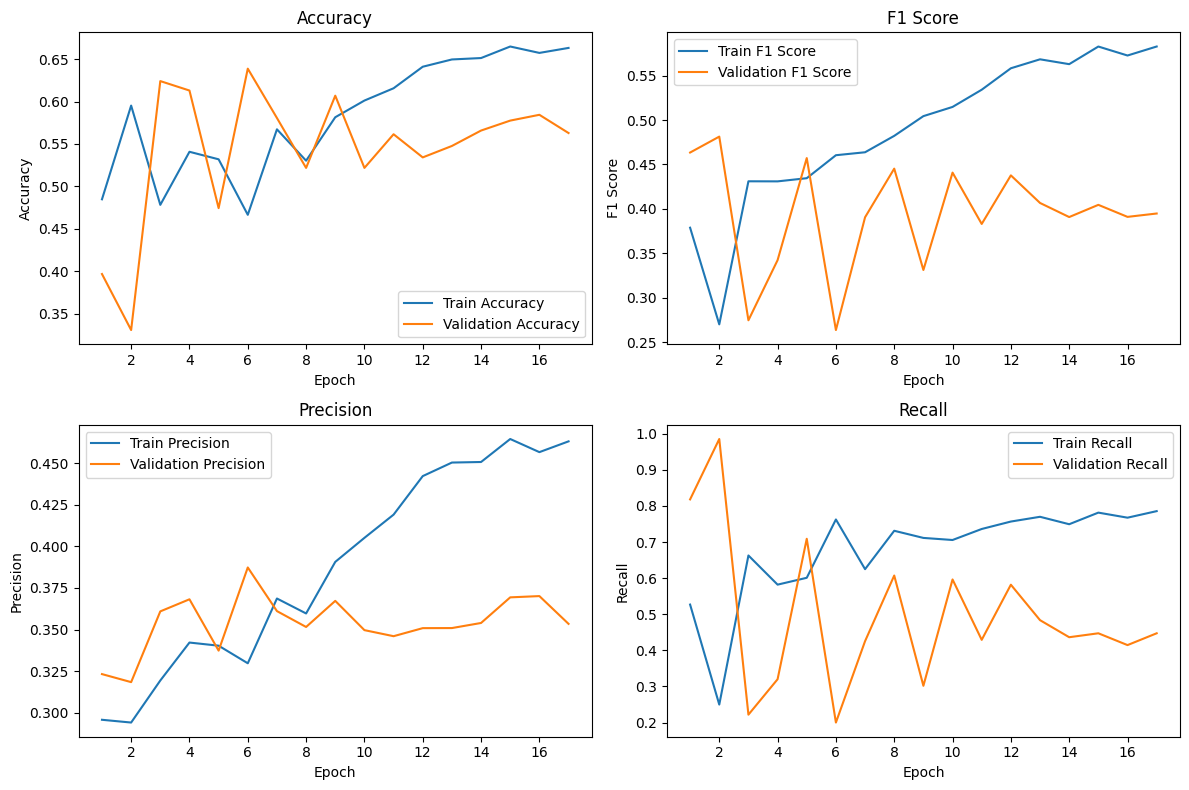

Receptive field: 14 Chunk size: 2 Number chunks: 250
514
cpu


<ipython-input-12-e0dbe18e07b9>:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_classification_1d.load_state_dict(torch.load(check_point_filename)) # recover the best 

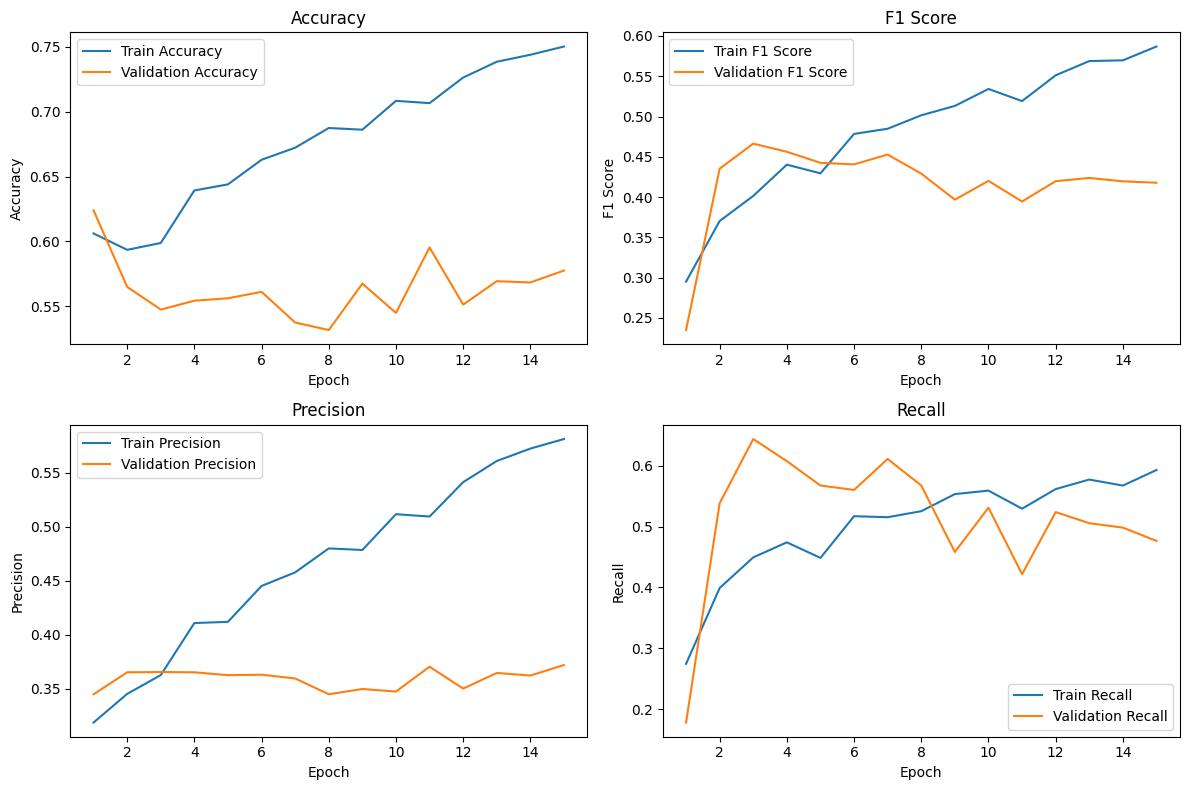

In [ ]:
# reducing to single layer

for filter_width in range(1,17,2):
  my_classification_cnn1d = CNN_classification_1d(filter_widths = [filter_width], #tested 3 (0.23), 5 (0.396) , 7 (0.38), 9 (0.31)
                  #strides = [2],
                  #conv_strides = [2],
                  #pool_strides = [1],
                  num_chunks = 250, #170
                  max_pool_factor = 2, # tried 2 (0.33- 0.4 with 160 num_chunks (reduces when num_chunks increased) ), 4 (0.2-0.36), 3 (0.38)
                  nchannels = [4, 10], # 10 (0.39), 16(0.25)
                  n_hidden=8, # 16 (0.4), 8 (0.38), 10 (0.33-0.41), 20 (0.35), 9 (0.38-0.41)
                  dropout=0.2)
  print(my_classification_cnn1d.seq_len)
  my_classification_cnn1d
  my_classification_cnn1d, train_accs, val_accs, train_f1s, val_f1s, train_precisions, val_precisions, train_recalls, val_recalls = train_classification_model(my_classification_cnn1d, train_classification_df, val_classification_df, patience = 10, verbose=False)

Receptive field: 24 Chunk size: 16 Number chunks: 30
504
cpu
Epoch 1 took 2.32s. Train loss: 0.9960, Train acc: 0.4531, Train F1: 0.4022, Train Precision: 0.2986, Train Recall: 0.6158. Val loss: 0.9913, Val acc: 0.3210, Val F1: 0.4808, Val Precision: 0.3165, Val Recall: 1.0000. Patience left: 10
Epoch 2 took 2.35s. Train loss: 0.9749, Train acc: 0.4855, Train F1: 0.4136, Train Precision: 0.3135, Train Recall: 0.6076. Val loss: 0.9877, Val acc: 0.3269, Val F1: 0.4815, Val Precision: 0.3178, Val Recall: 0.9927. Patience left: 10
Epoch 3 took 2.53s. Train loss: 0.9693, Train acc: 0.4638, Train F1: 0.4336, Train Precision: 0.3166, Train Recall: 0.6876. Val loss: 0.9855, Val acc: 0.4982, Val F1: 0.4510, Val Precision: 0.3471, Val Recall: 0.6436. Patience left: 10
Epoch 4 took 2.60s. Train loss: 0.9627, Train acc: 0.4766, Train F1: 0.4393, Train Precision: 0.3228, Train Recall: 0.6876. Val loss: 0.9857, Val acc: 0.5395, Val F1: 0.4296, Val Precision: 0.3528, Val Recall: 0.5491. Patience left

<ipython-input-12-e0dbe18e07b9>:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_classification_1d.load_state_dict(torch.load(check_point_filename)) # recover the best 

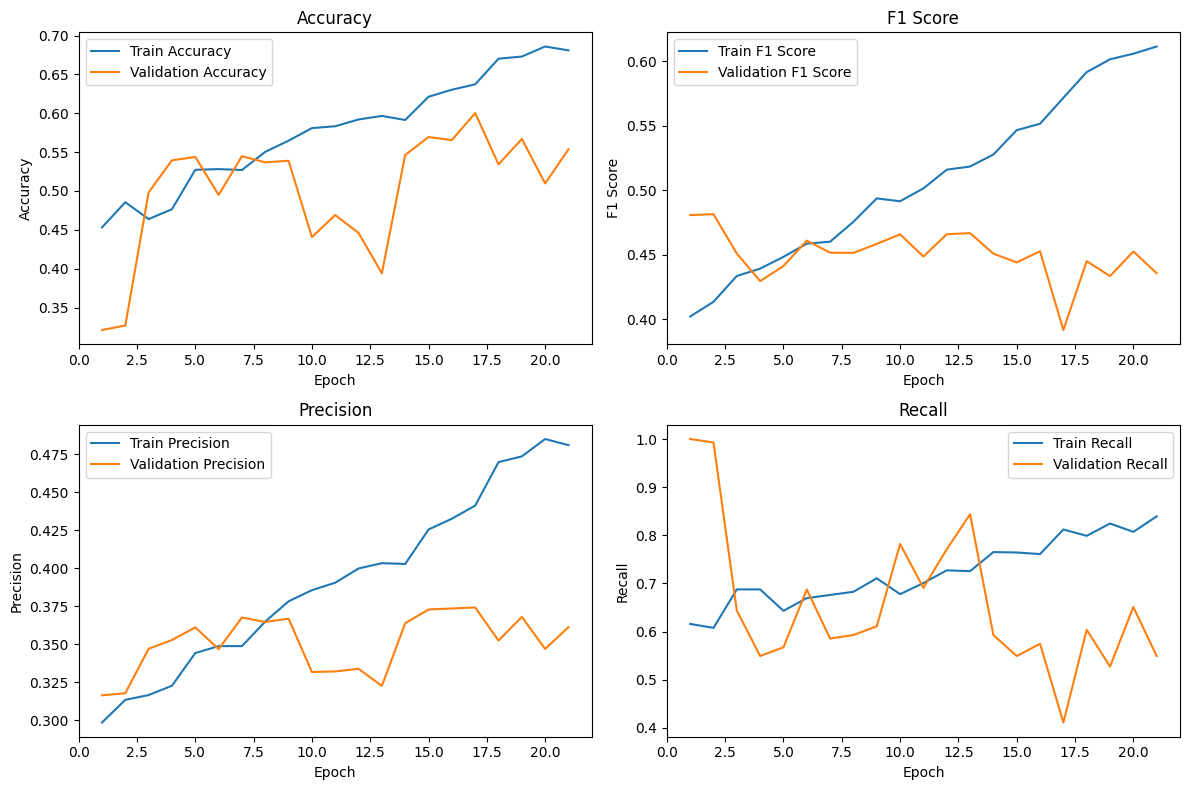

In [ ]:
# increasing to two layers
my_classification_cnn1d = CNN_classification_1d(filter_widths = [9,5], #tested 3 (0.23), 5 (0.396) , 7 (0.38), 9 (0.31)
                 #strides = [2],
                 #conv_strides = [2],
                 #pool_strides = [1],
                 num_chunks = 30, #170
                 max_pool_factor = 4, # tried 2 (0.33- 0.4 with 160 num_chunks (reduces when num_chunks increased) ), 4 (0.2-0.36), 3 (0.38)
                 nchannels = [4, 32,32], # 10 (0.39), 16(0.25)
                 n_hidden=8, # 16 (0.4), 8 (0.38), 10 (0.33-0.41), 20 (0.35), 9 (0.38-0.41)
                 dropout=0.2)
print(my_classification_cnn1d.seq_len)
my_classification_cnn1d
my_classification_cnn1d, train_accs, val_accs, train_f1s, val_f1s, train_precisions, val_precisions, train_recalls, val_recalls = train_classification_model(my_classification_cnn1d, train_classification_df, val_classification_df, patience = 10)

Receptive field: 0 Chunk size: 3 Number chunks: 170
510
cpu


/usr/local/lib/python3.10/dist-packages/torch/nn/init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
<ipython-input-12-e0dbe18e07b9>:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded

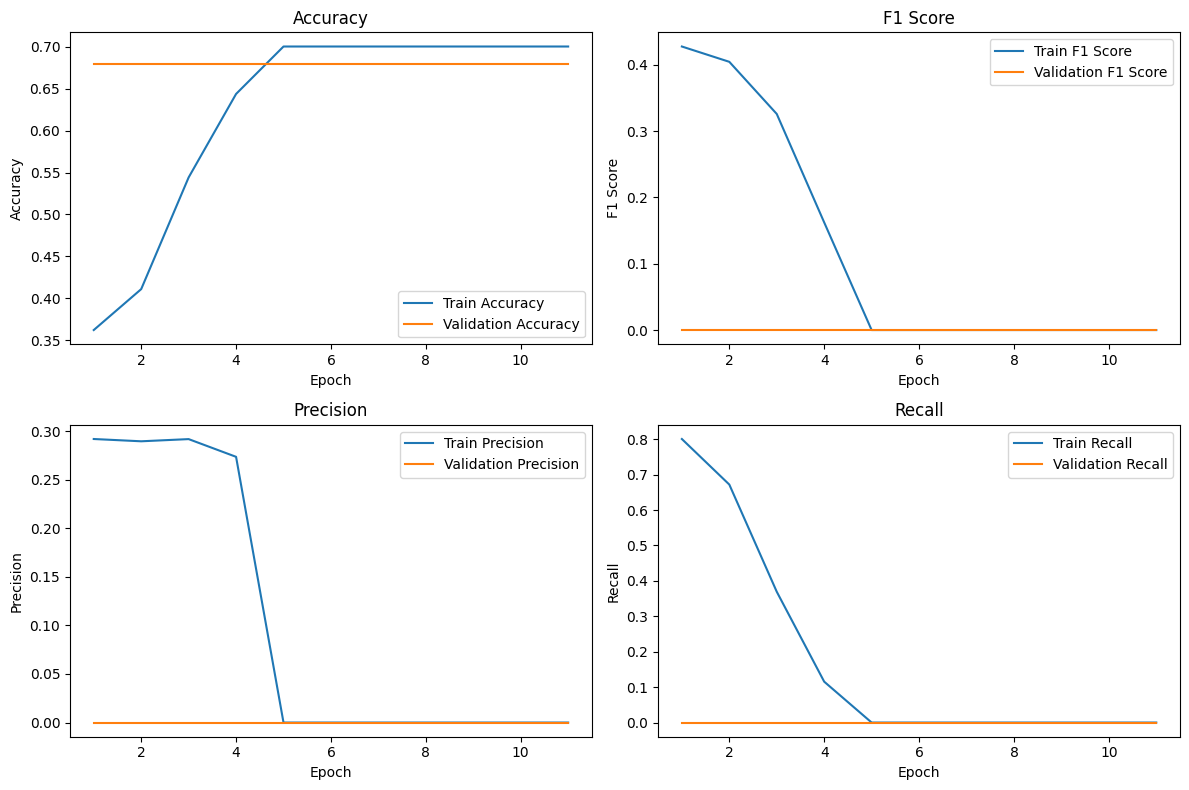

Receptive field: 2 Chunk size: 3 Number chunks: 170
512
cpu


/usr/local/lib/python3.10/dist-packages/torch/nn/init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
<ipython-input-12-e0dbe18e07b9>:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded

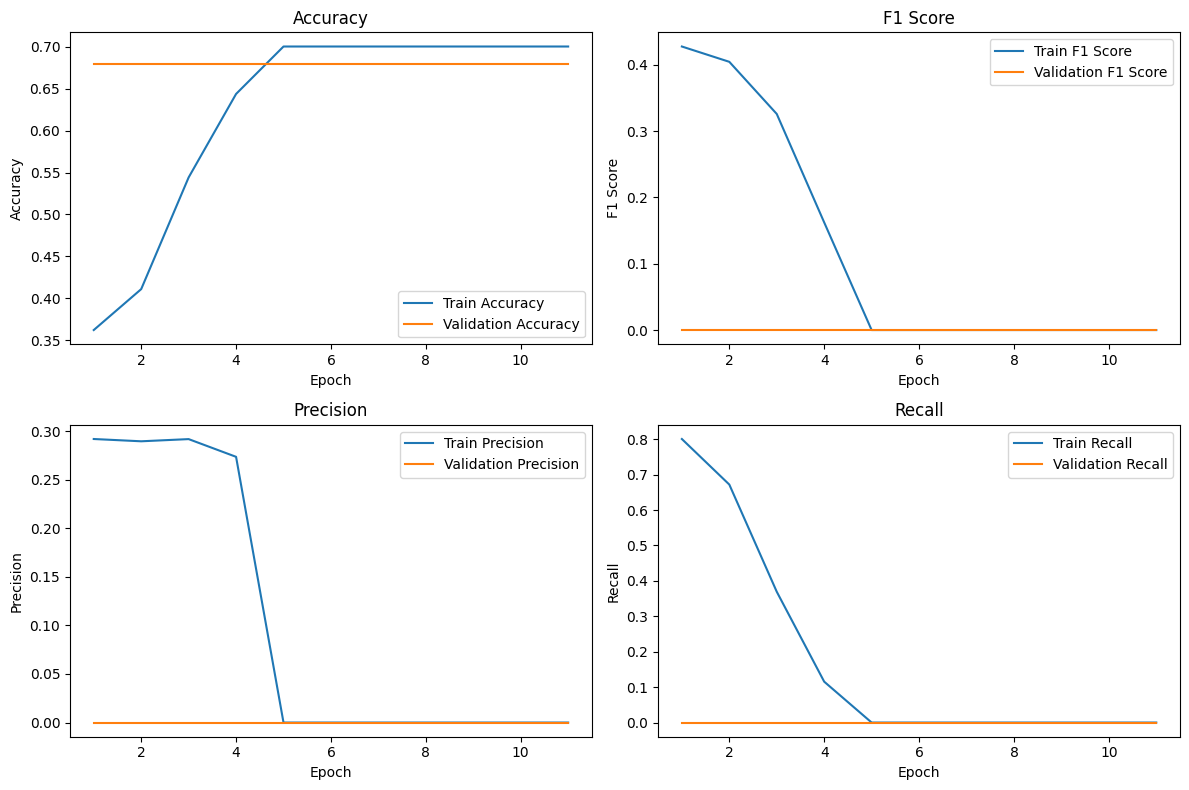

Receptive field: 4 Chunk size: 3 Number chunks: 170
514
cpu


/usr/local/lib/python3.10/dist-packages/torch/nn/init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


KeyboardInterrupt: 

In [ ]:
# reducing to single layer

for filter_width in range(1,17,2):
  my_classification_cnn1d = CNN_classification_1d(filter_widths = [filter_width], #tested 3 (0.23), 5 (0.396) , 7 (0.38), 9 (0.31)
                  #strides = [2],
                  #conv_strides = [2],
                  #pool_strides = [1],
                  num_chunks = 170, #170
                  max_pool_factor = 3, # tried 2 (0.33- 0.4 with 160 num_chunks (reduces when num_chunks increased) ), 4 (0.2-0.36), 3 (0.38)
                  nchannels = [4, 10], # 10 (0.39), 16(0.25)
                  n_hidden=8, # 16 (0.4), 8 (0.38), 10 (0.33-0.41), 20 (0.35), 9 (0.38-0.41)
                  dropout=0.2)
  print(my_classification_cnn1d.seq_len)
  my_classification_cnn1d
  my_classification_cnn1d, train_accs, val_accs, train_f1s, val_f1s, train_precisions, val_precisions, train_recalls, val_recalls = train_classification_model(my_classification_cnn1d, train_classification_df, val_classification_df, patience = 10, verbose=False)

Receptive field: 0 Chunk size: 4 Number chunks: 130
520
cpu


<ipython-input-12-e0dbe18e07b9>:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_classification_1d.load_state_dict(torch.load(check_point_filename)) # recover the best 

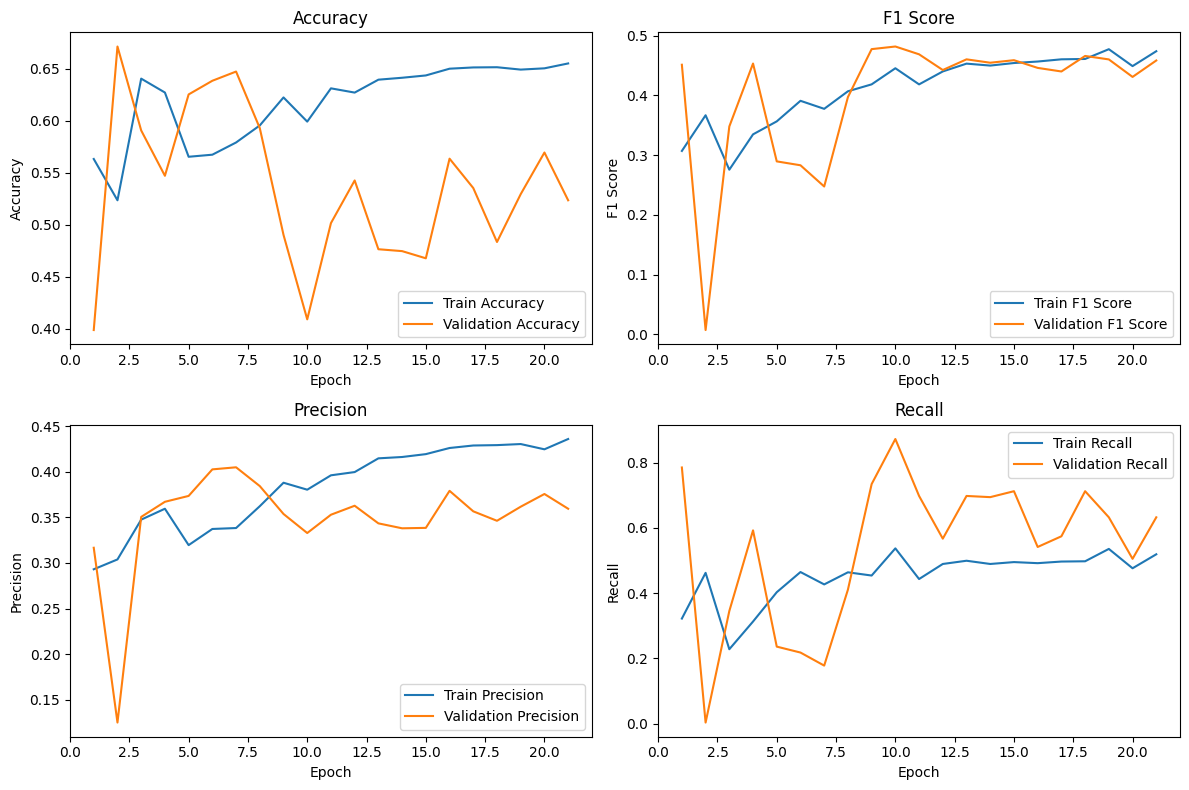

Receptive field: 2 Chunk size: 4 Number chunks: 130
522
cpu


<ipython-input-12-e0dbe18e07b9>:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_classification_1d.load_state_dict(torch.load(check_point_filename)) # recover the best 

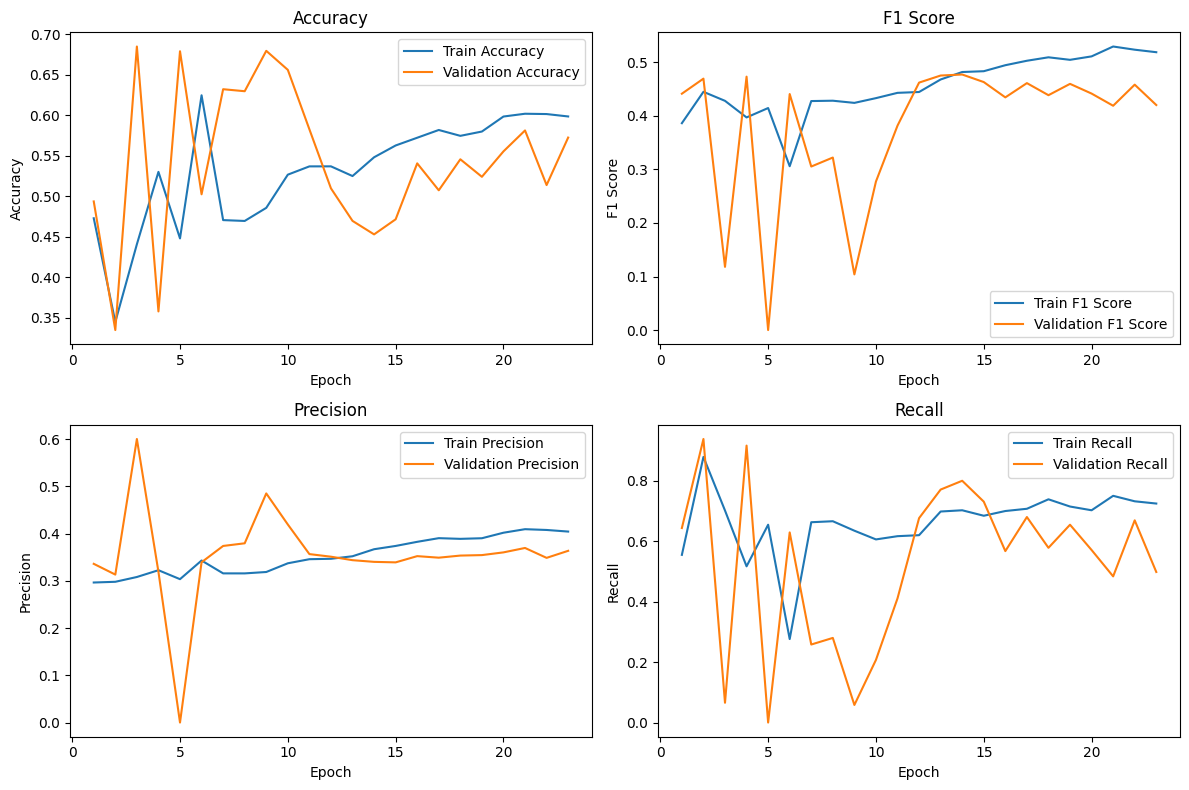

Receptive field: 4 Chunk size: 4 Number chunks: 130
524
cpu


<ipython-input-12-e0dbe18e07b9>:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_classification_1d.load_state_dict(torch.load(check_point_filename)) # recover the best 

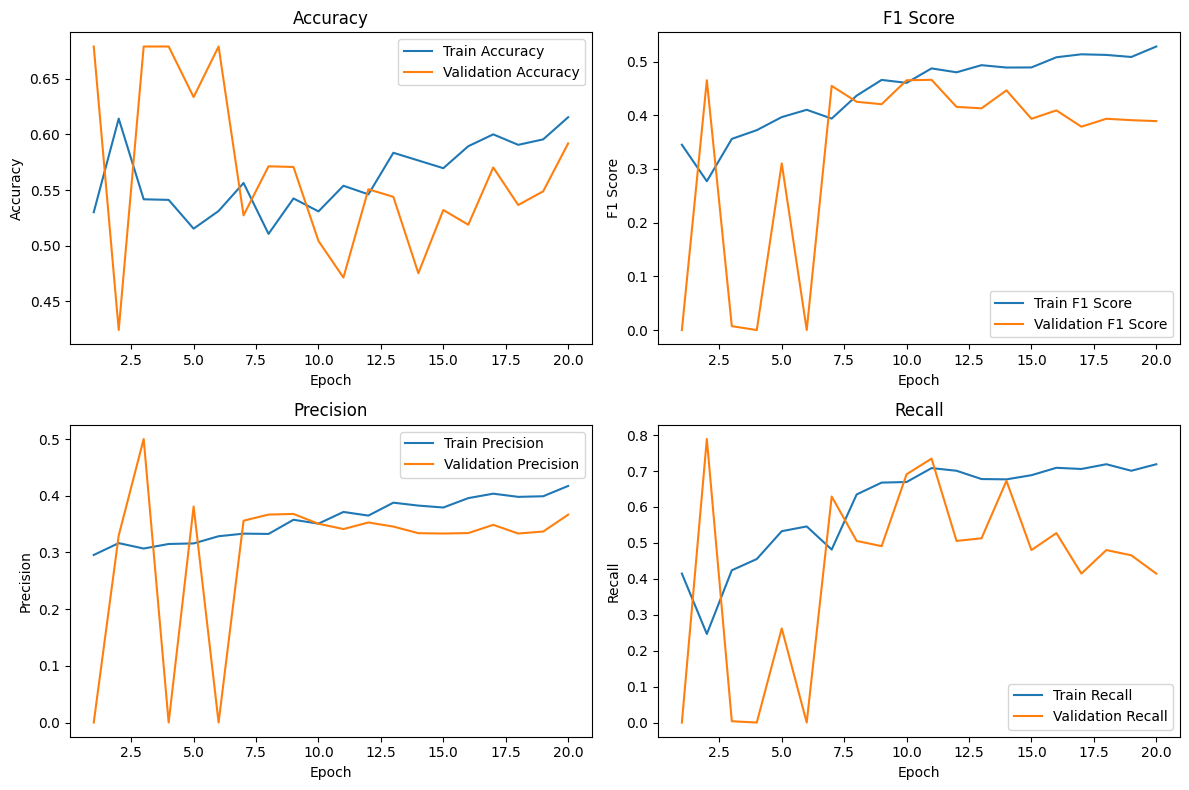

Receptive field: 6 Chunk size: 4 Number chunks: 130
526
cpu


<ipython-input-12-e0dbe18e07b9>:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_classification_1d.load_state_dict(torch.load(check_point_filename)) # recover the best 

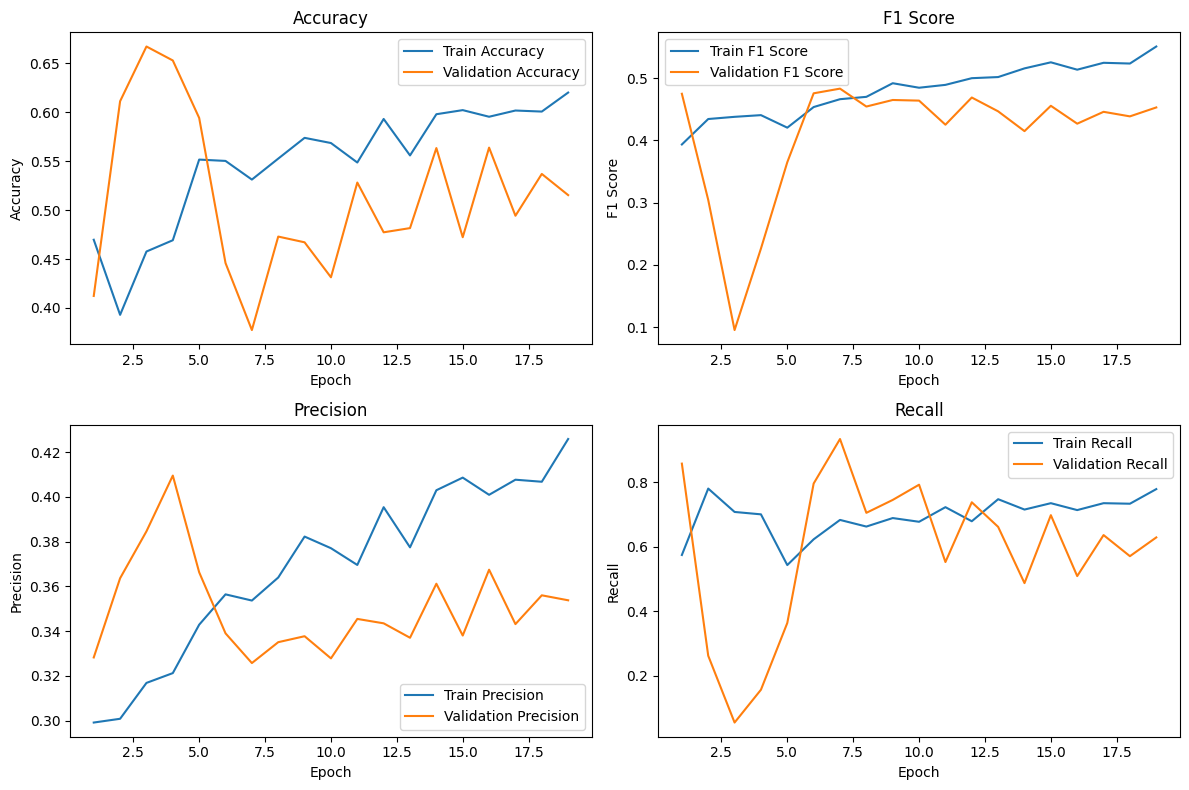

Receptive field: 8 Chunk size: 4 Number chunks: 130
528
cpu


<ipython-input-12-e0dbe18e07b9>:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_classification_1d.load_state_dict(torch.load(check_point_filename)) # recover the best 

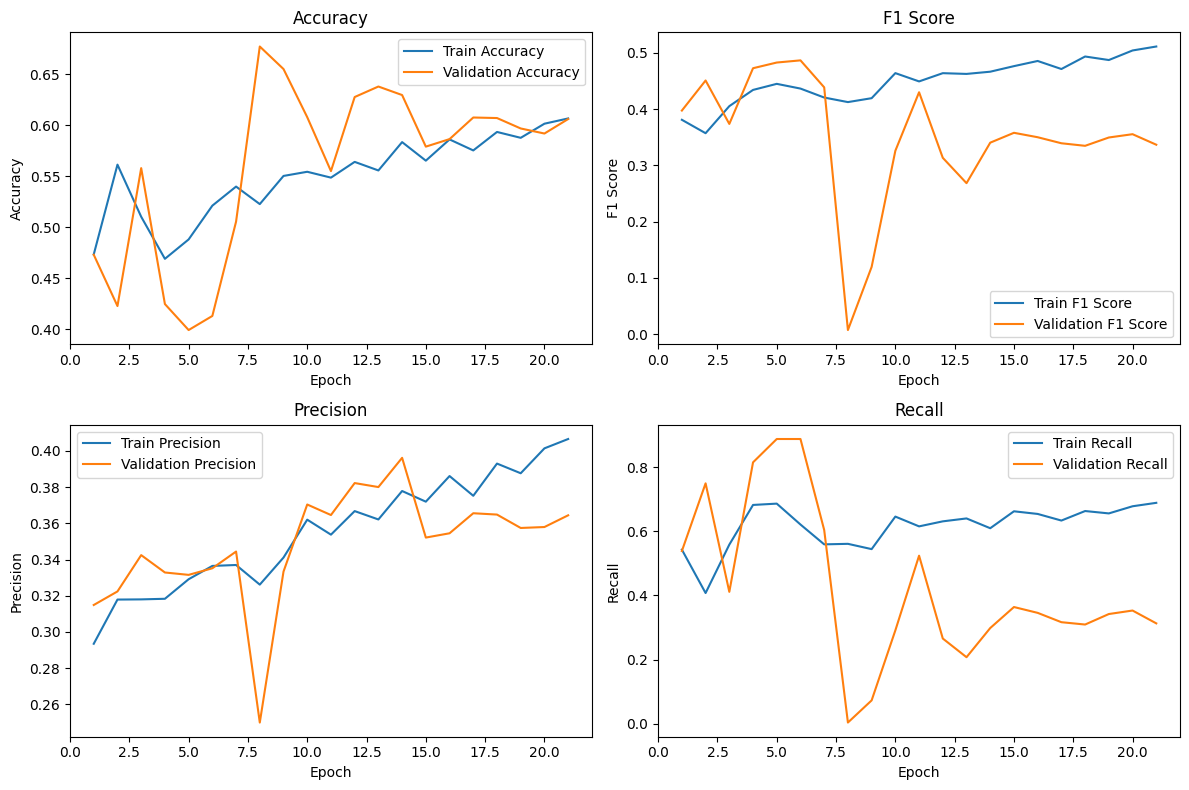

Receptive field: 10 Chunk size: 4 Number chunks: 130
530
cpu


<ipython-input-12-e0dbe18e07b9>:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_classification_1d.load_state_dict(torch.load(check_point_filename)) # recover the best 

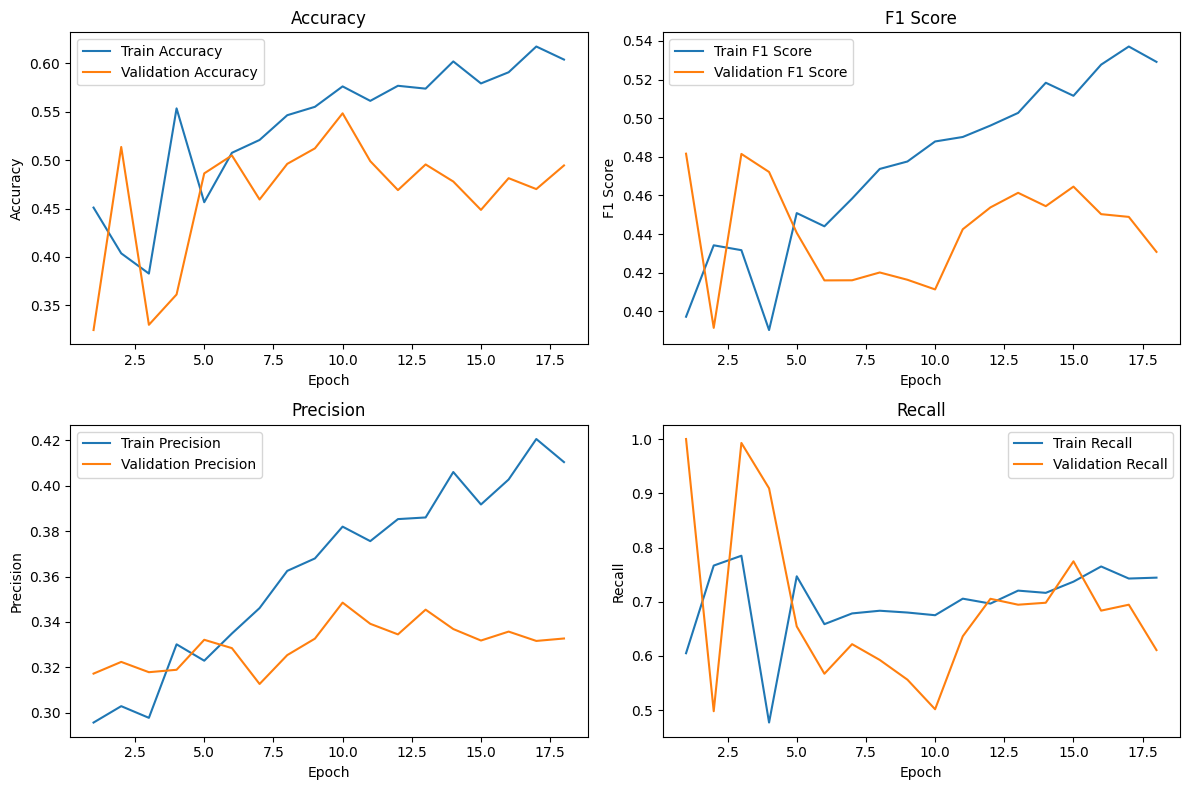

Receptive field: 12 Chunk size: 4 Number chunks: 130
532
cpu


<ipython-input-12-e0dbe18e07b9>:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_classification_1d.load_state_dict(torch.load(check_point_filename)) # recover the best 

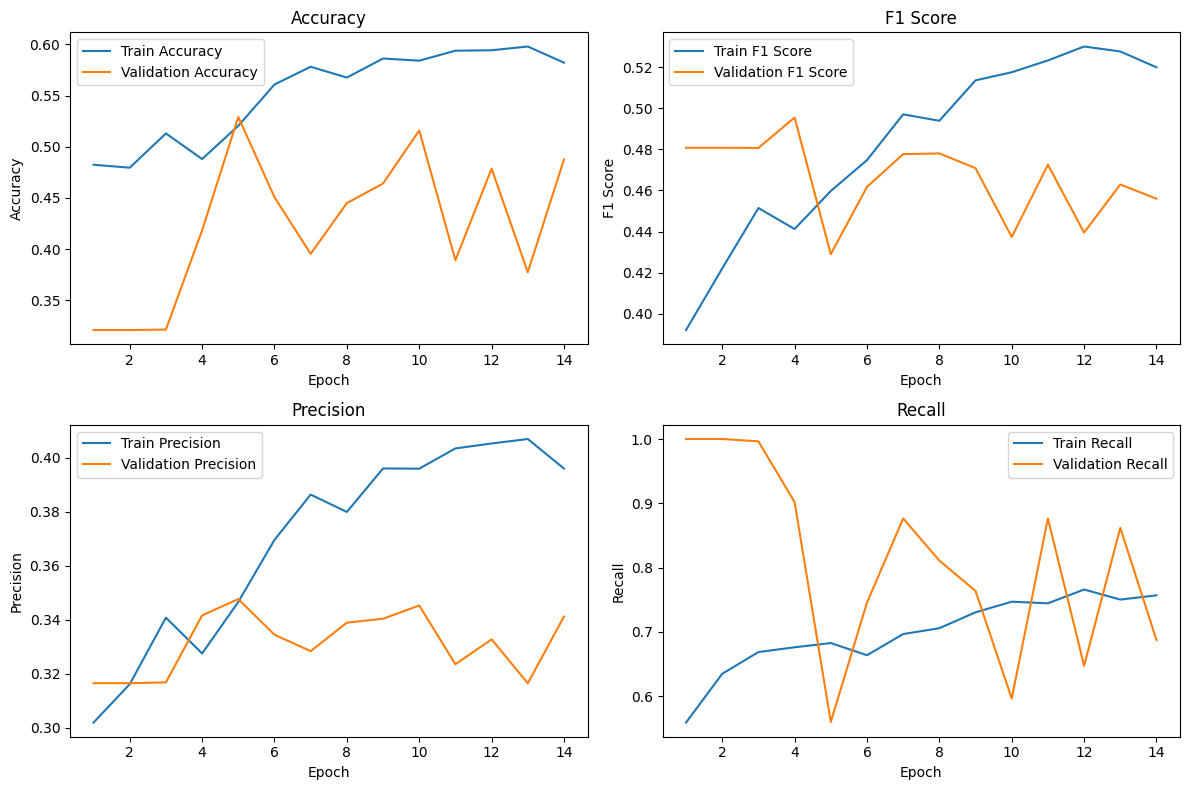

Receptive field: 14 Chunk size: 4 Number chunks: 130
534
cpu


<ipython-input-12-e0dbe18e07b9>:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_classification_1d.load_state_dict(torch.load(check_point_filename)) # recover the best 

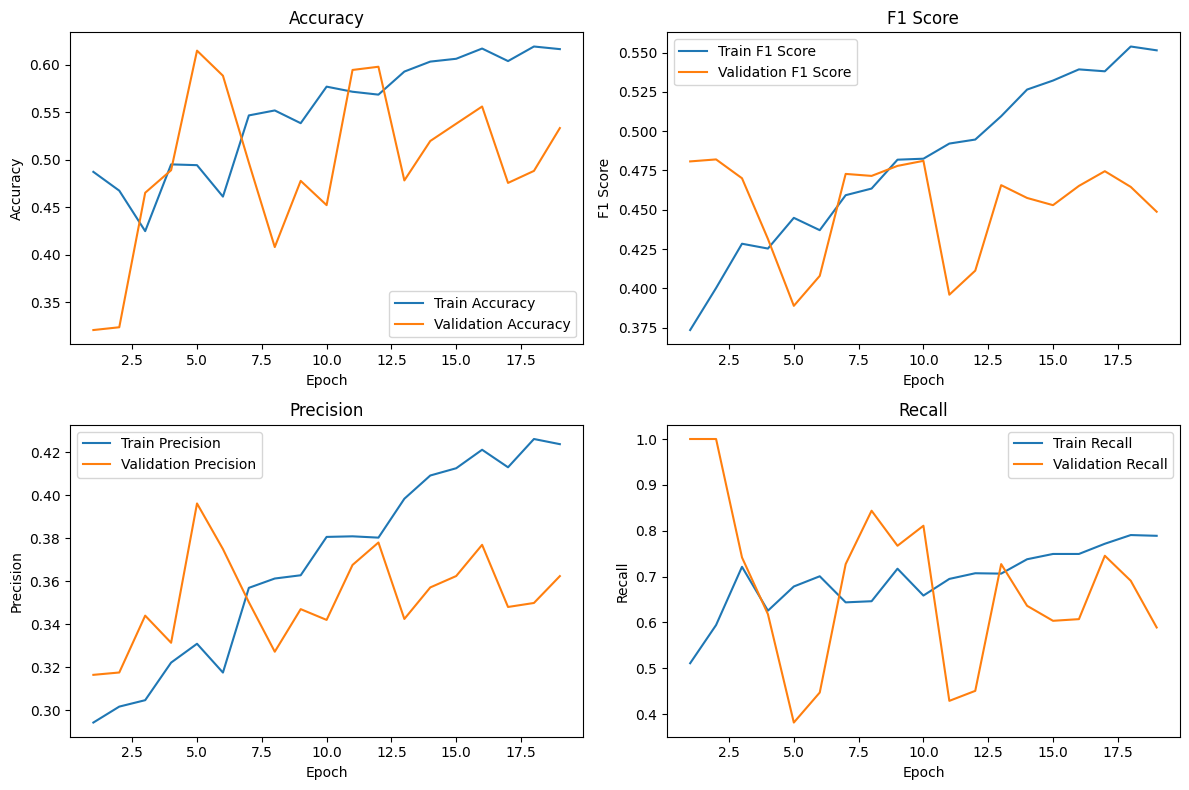

In [ ]:
# reducing to single layer

for filter_width in range(1,17,2):
  my_classification_cnn1d = CNN_classification_1d(filter_widths = [filter_width], #tested 3 (0.23), 5 (0.396) , 7 (0.38), 9 (0.31)
                  #strides = [2],
                  #conv_strides = [2],
                  #pool_strides = [1],
                  num_chunks = 130, #170
                  max_pool_factor = 4, # tried 2 (0.33- 0.4 with 160 num_chunks (reduces when num_chunks increased) ), 4 (0.2-0.36), 3 (0.38)
                  nchannels = [4, 10], # 10 (0.39), 16(0.25)
                  n_hidden=8, # 16 (0.4), 8 (0.38), 10 (0.33-0.41), 20 (0.35), 9 (0.38-0.41)
                  dropout=0.2)
  print(my_classification_cnn1d.seq_len)
  my_classification_cnn1d
  my_classification_cnn1d, train_accs, val_accs, train_f1s, val_f1s, train_precisions, val_precisions, train_recalls, val_recalls = train_classification_model(my_classification_cnn1d, train_classification_df, val_classification_df, patience = 10, verbose=False)

Receptive field: 6 Chunk size: 4 Number chunks: 130
526
1
cpu


<ipython-input-12-e0dbe18e07b9>:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_classification_1d.load_state_dict(torch.load(check_point_filename)) # recover the best 

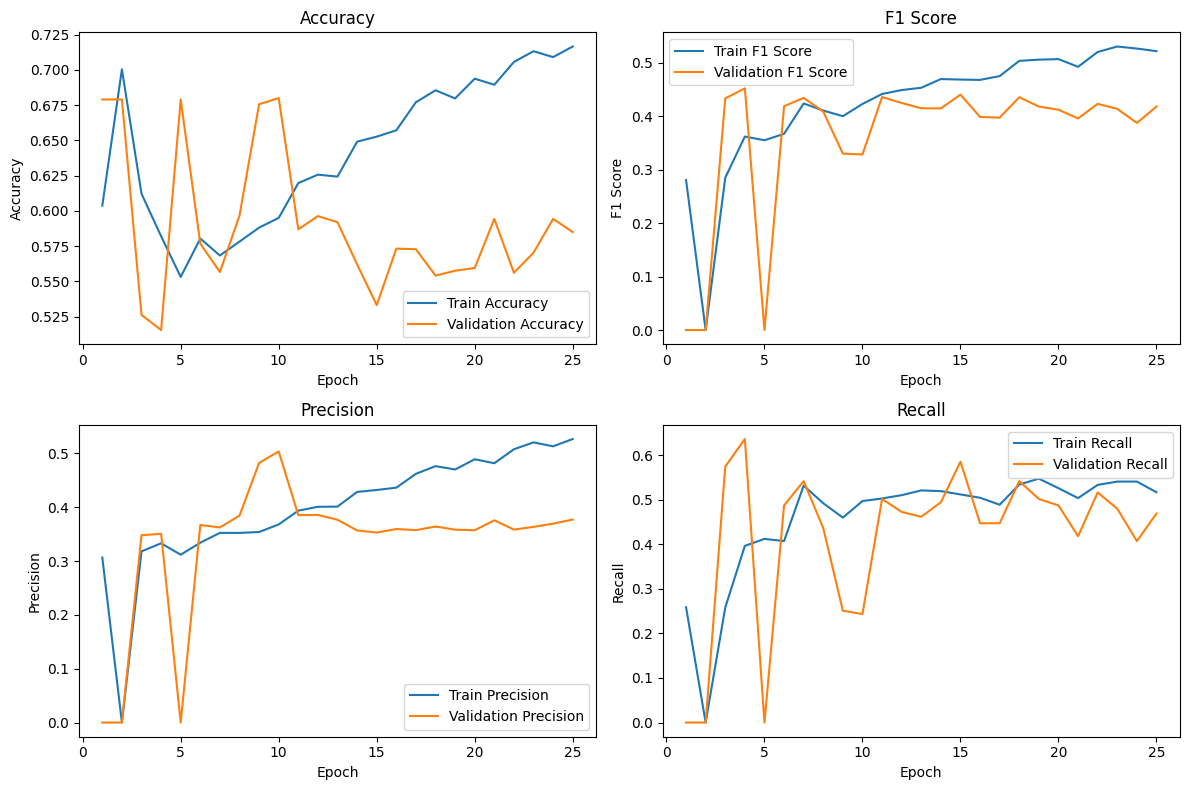

Receptive field: 6 Chunk size: 4 Number chunks: 130
526
5
cpu


<ipython-input-12-e0dbe18e07b9>:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_classification_1d.load_state_dict(torch.load(check_point_filename)) # recover the best 

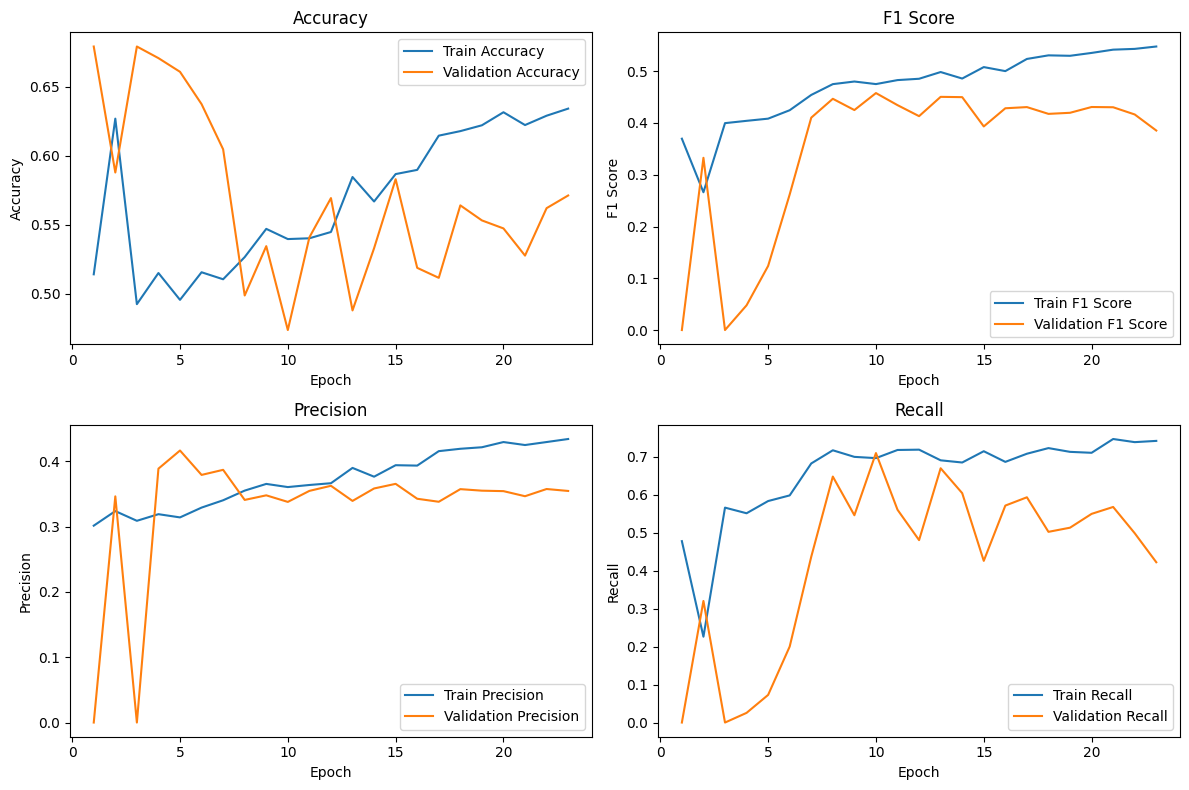

Receptive field: 6 Chunk size: 4 Number chunks: 130
526
9
cpu


<ipython-input-12-e0dbe18e07b9>:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_classification_1d.load_state_dict(torch.load(check_point_filename)) # recover the best 

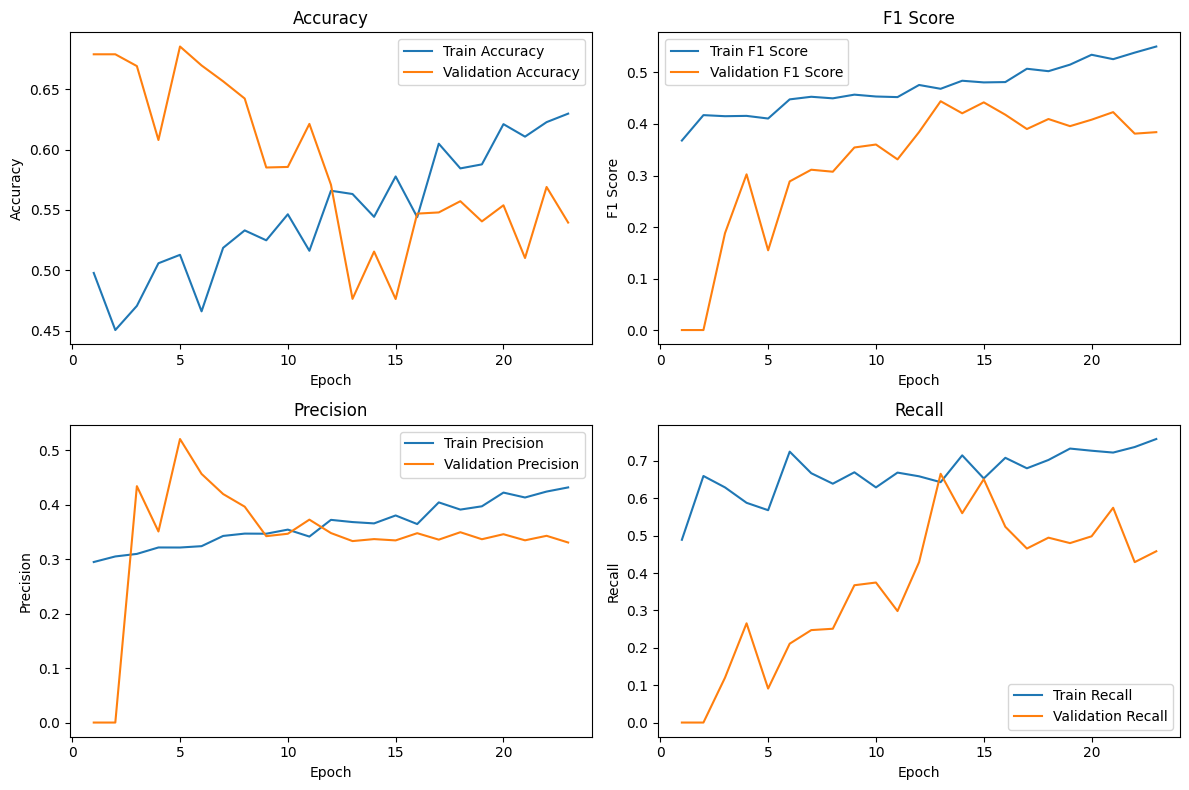

Receptive field: 6 Chunk size: 4 Number chunks: 130
526
13
cpu


<ipython-input-12-e0dbe18e07b9>:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_classification_1d.load_state_dict(torch.load(check_point_filename)) # recover the best 

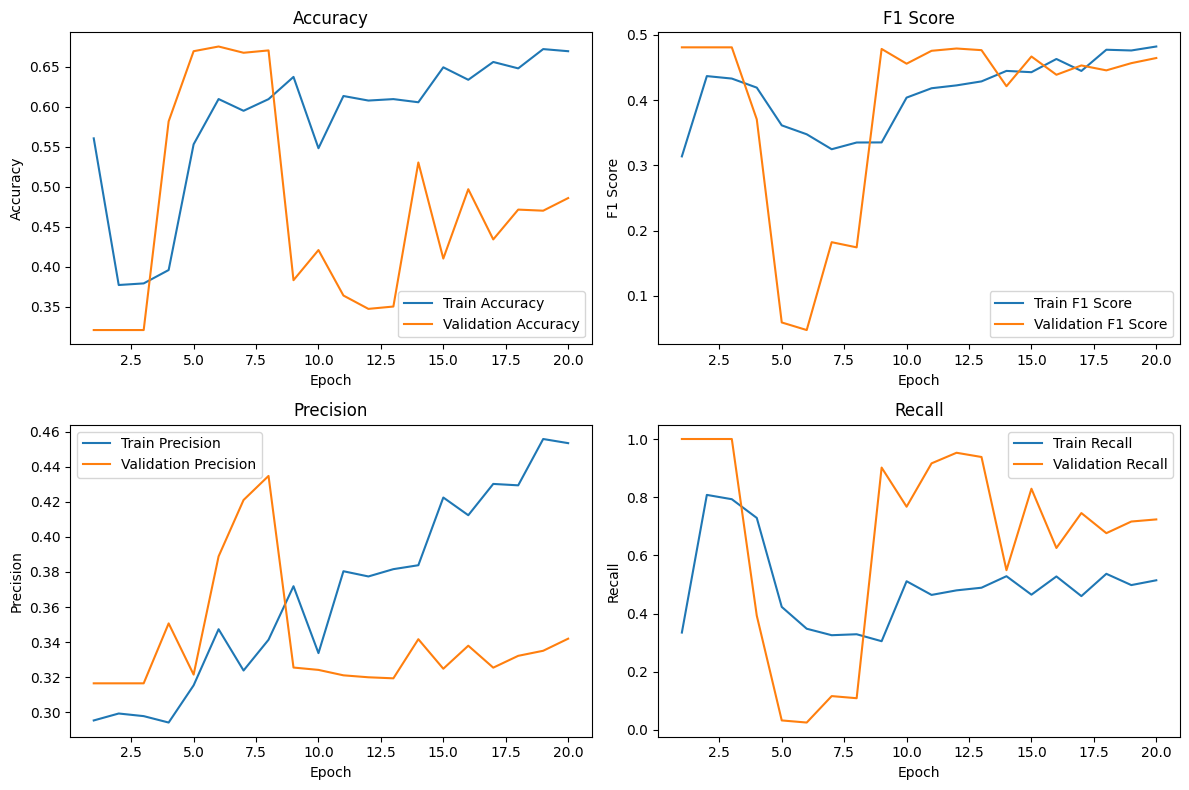

Receptive field: 6 Chunk size: 4 Number chunks: 130
526
17
cpu


<ipython-input-12-e0dbe18e07b9>:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_classification_1d.load_state_dict(torch.load(check_point_filename)) # recover the best 

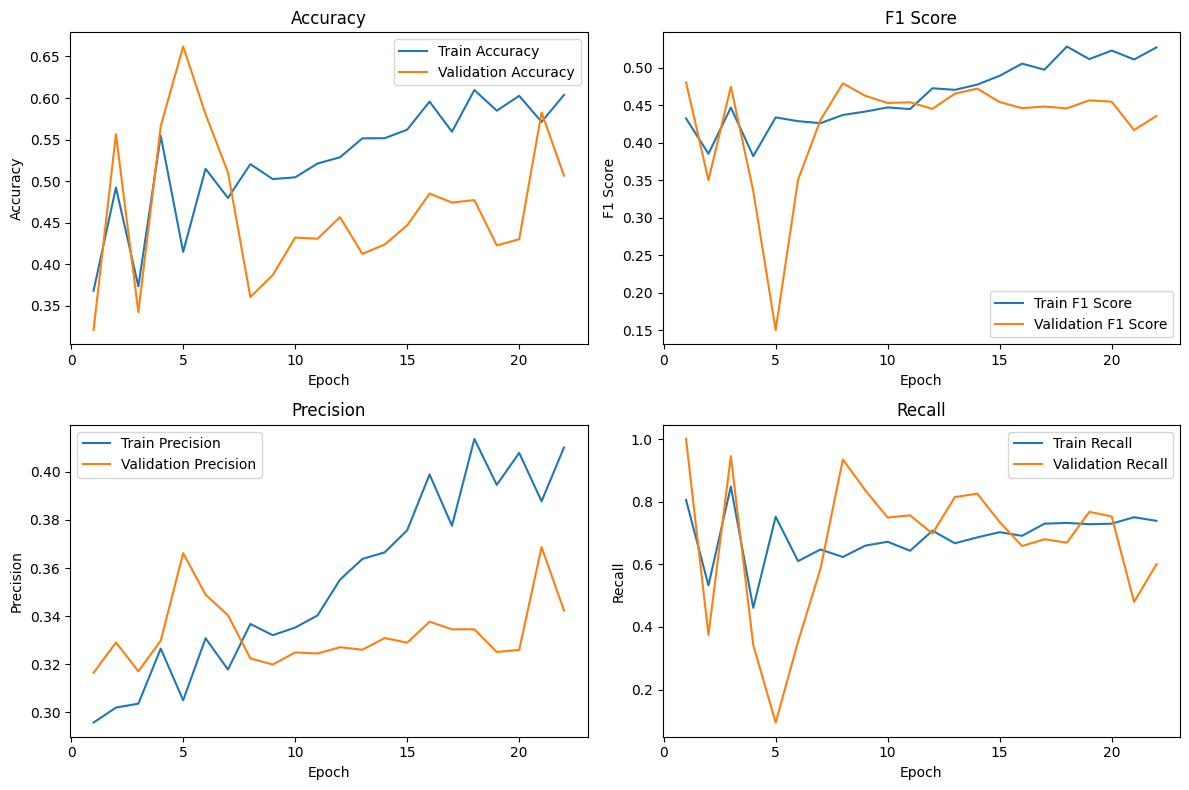

In [ ]:
# reducing to single layer

for n_hidden in range(1,21,4):
  my_classification_cnn1d = CNN_classification_1d(filter_widths = [7], #tested 3 (0.23), 5 (0.396) , 7 (0.38), 9 (0.31)
                  #strides = [2],
                  #conv_strides = [2],
                  #pool_strides = [1],
                  num_chunks = 130, #170
                  max_pool_factor = 4, # tried 2 (0.33- 0.4 with 160 num_chunks (reduces when num_chunks increased) ), 4 (0.2-0.36), 3 (0.38)
                  nchannels = [4, 10], # 10 (0.39), 16(0.25)
                  n_hidden=n_hidden, # 16 (0.4), 8 (0.38), 10 (0.33-0.41), 20 (0.35), 9 (0.38-0.41)
                  dropout=0.2)
  print(my_classification_cnn1d.seq_len)
  print(n_hidden)
  my_classification_cnn1d
  my_classification_cnn1d, train_accs, val_accs, train_f1s, val_f1s, train_precisions, val_precisions, train_recalls, val_recalls = train_classification_model(my_classification_cnn1d, train_classification_df, val_classification_df, patience = 10, verbose=False)

Receptive field: 30 Chunk size: 16 Number chunks: 30
cpu


<ipython-input-27-cda7b4e91609>:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_classification_1d.load_state_dict(torch.load(check_point_filename)) # recover the best 

nchannels: [4, 4, 4], Train accuracy: 0.7086, Validation accuracy: 0.7107, Train F1: 0.1362, Validation F1: 0.0375
Receptive field: 30 Chunk size: 16 Number chunks: 30
cpu


<ipython-input-27-cda7b4e91609>:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_classification_1d.load_state_dict(torch.load(check_point_filename)) # recover the best 

nchannels: [4, 8, 8], Train accuracy: 0.7238, Validation accuracy: 0.6706, Train F1: 0.2852, Validation F1: 0.2396
Receptive field: 30 Chunk size: 16 Number chunks: 30
cpu


<ipython-input-27-cda7b4e91609>:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_classification_1d.load_state_dict(torch.load(check_point_filename)) # recover the best 

nchannels: [4, 12, 12], Train accuracy: 0.7460, Validation accuracy: 0.6721, Train F1: 0.4349, Validation F1: 0.2757
Receptive field: 30 Chunk size: 16 Number chunks: 30
cpu


<ipython-input-27-cda7b4e91609>:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_classification_1d.load_state_dict(torch.load(check_point_filename)) # recover the best 

nchannels: [4, 16, 16], Train accuracy: 0.7719, Validation accuracy: 0.6125, Train F1: 0.5212, Validation F1: 0.2356
Receptive field: 30 Chunk size: 16 Number chunks: 30
cpu


<ipython-input-27-cda7b4e91609>:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_classification_1d.load_state_dict(torch.load(check_point_filename)) # recover the best 

nchannels: [4, 20, 20], Train accuracy: 0.7823, Validation accuracy: 0.5870, Train F1: 0.5379, Validation F1: 0.3538
Receptive field: 30 Chunk size: 16 Number chunks: 30
cpu


<ipython-input-27-cda7b4e91609>:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_classification_1d.load_state_dict(torch.load(check_point_filename)) # recover the best 

nchannels: [4, 24, 24], Train accuracy: 0.7972, Validation accuracy: 0.7048, Train F1: 0.6016, Validation F1: 0.1419
Receptive field: 30 Chunk size: 16 Number chunks: 30
cpu


<ipython-input-27-cda7b4e91609>:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_classification_1d.load_state_dict(torch.load(check_point_filename)) # recover the best 

nchannels: [4, 28, 28], Train accuracy: 0.7713, Validation accuracy: 0.6784, Train F1: 0.5694, Validation F1: 0.1584
Receptive field: 30 Chunk size: 16 Number chunks: 30
cpu


<ipython-input-27-cda7b4e91609>:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_classification_1d.load_state_dict(torch.load(check_point_filename)) # recover the best 

nchannels: [4, 32, 32], Train accuracy: 0.8455, Validation accuracy: 0.6305, Train F1: 0.7037, Validation F1: 0.2685
Receptive field: 30 Chunk size: 16 Number chunks: 30
cpu


<ipython-input-27-cda7b4e91609>:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_classification_1d.load_state_dict(torch.load(check_point_filename)) # recover the best 

nchannels: [4, 36, 36], Train accuracy: 0.8463, Validation accuracy: 0.6946, Train F1: 0.7085, Validation F1: 0.1758
Receptive field: 30 Chunk size: 16 Number chunks: 30
cpu


<ipython-input-27-cda7b4e91609>:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_classification_1d.load_state_dict(torch.load(check_point_filename)) # recover the best 

nchannels: [4, 40, 40], Train accuracy: 0.8723, Validation accuracy: 0.6609, Train F1: 0.7586, Validation F1: 0.2790
Receptive field: 30 Chunk size: 16 Number chunks: 30
cpu


<ipython-input-27-cda7b4e91609>:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_classification_1d.load_state_dict(torch.load(check_point_filename)) # recover the best 

nchannels: [4, 44, 44], Train accuracy: 0.8430, Validation accuracy: 0.7058, Train F1: 0.7065, Validation F1: 0.0956
Receptive field: 30 Chunk size: 16 Number chunks: 30
cpu


<ipython-input-27-cda7b4e91609>:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_classification_1d.load_state_dict(torch.load(check_point_filename)) # recover the best 

nchannels: [4, 48, 48], Train accuracy: 0.8847, Validation accuracy: 0.5107, Train F1: 0.7849, Validation F1: 0.3837
Receptive field: 30 Chunk size: 16 Number chunks: 30
cpu


<ipython-input-27-cda7b4e91609>:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_classification_1d.load_state_dict(torch.load(check_point_filename)) # recover the best 

nchannels: [4, 52, 52], Train accuracy: 0.8807, Validation accuracy: 0.6643, Train F1: 0.7678, Validation F1: 0.2611
Receptive field: 30 Chunk size: 16 Number chunks: 30
cpu


<ipython-input-27-cda7b4e91609>:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_classification_1d.load_state_dict(torch.load(check_point_filename)) # recover the best 

nchannels: [4, 56, 56], Train accuracy: 0.9077, Validation accuracy: 0.5910, Train F1: 0.8270, Validation F1: 0.3315
Receptive field: 30 Chunk size: 16 Number chunks: 30
cpu


<ipython-input-27-cda7b4e91609>:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_classification_1d.load_state_dict(torch.load(check_point_filename)) # recover the best 

nchannels: [4, 60, 60], Train accuracy: 0.8893, Validation accuracy: 0.6105, Train F1: 0.7911, Validation F1: 0.2857


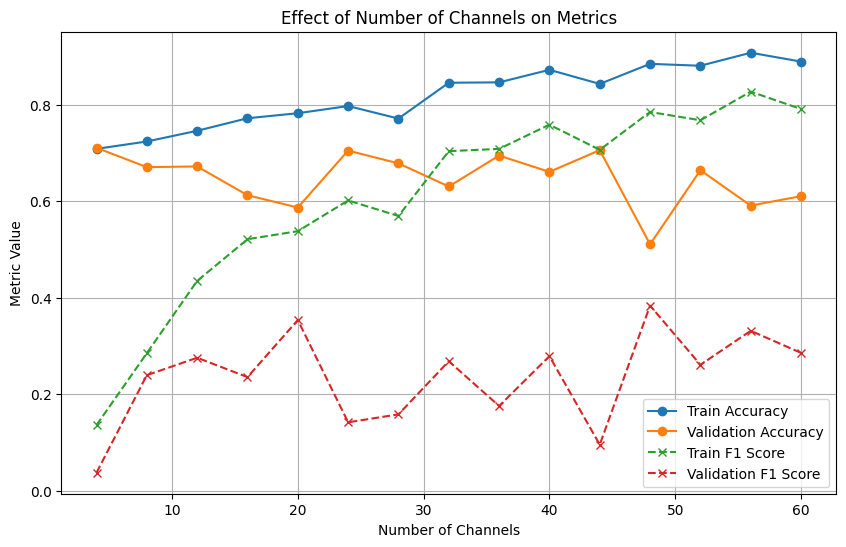

In [ ]:
final_train_acc = []
final_val_acc = []
final_train_f1 = []
final_val_f1 = []

for nchannels in range(4, 64, 4):
    my_classification_cnn1d = CNN_classification_1d(nchannels=[4, nchannels, nchannels])
    my_classification_cnn1d, train_accs, val_accs, train_f1s, val_f1s, _, _, _, _ = train_classification_model(
        my_classification_cnn1d, train_classification_df, test_classification_df, patience=25, verbose=False, plot=False
    )
    final_train_acc.append(train_accs[-1])
    final_val_acc.append(val_accs[-1])
    final_train_f1.append(train_f1s[-1])
    final_val_f1.append(val_f1s[-1])
    print(
        f"nchannels: [4, {nchannels}, {nchannels}], "
        f"Train accuracy: {train_accs[-1]:.4f}, Validation accuracy: {val_accs[-1]:.4f}, "
        f"Train F1: {train_f1s[-1]:.4f}, Validation F1: {val_f1s[-1]:.4f}"
    )

# Plotting
plt.figure(figsize=(10, 6))

# Plot accuracy
plt.plot(range(4, 64, 4), final_train_acc, label="Train Accuracy", marker="o")
plt.plot(range(4, 64, 4), final_val_acc, label="Validation Accuracy", marker="o")

# Plot F1 score
plt.plot(range(4, 64, 4), final_train_f1, label="Train F1 Score", linestyle="--", marker="x")
plt.plot(range(4, 64, 4), final_val_f1, label="Validation F1 Score", linestyle="--", marker="x")

plt.xlabel("Number of Channels")
plt.ylabel("Metric Value")
plt.title("Effect of Number of Channels on Metrics")
plt.legend()
plt.grid(which="both")
plt.show()

Receptive field: 30 Chunk size: 16 Number chunks: 30
cpu


<ipython-input-27-cda7b4e91609>:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_classification_1d.load_state_dict(torch.load(check_point_filename)) # recover the best 

Dropout: 0.0, Train accuracy: 0.999267578125, Validation accuracy: 0.6535117626190186, Train F1: 0.9987628865979381, Validation F1: 0.32456140350877194
Receptive field: 30 Chunk size: 16 Number chunks: 30
cpu


<ipython-input-27-cda7b4e91609>:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_classification_1d.load_state_dict(torch.load(check_point_filename)) # recover the best 

Dropout: 0.1, Train accuracy: 0.8212528824806213, Validation accuracy: 0.44129136204719543, Train F1: 0.6613657623947614, Validation F1: 0.40892193308550184
Receptive field: 30 Chunk size: 16 Number chunks: 30
cpu


<ipython-input-27-cda7b4e91609>:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_classification_1d.load_state_dict(torch.load(check_point_filename)) # recover the best 

Dropout: 0.2, Train accuracy: 0.8287850618362427, Validation accuracy: 0.6569393277168274, Train F1: 0.6618004866180048, Validation F1: 0.2193877551020408
Receptive field: 30 Chunk size: 16 Number chunks: 30
cpu


<ipython-input-27-cda7b4e91609>:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_classification_1d.load_state_dict(torch.load(check_point_filename)) # recover the best 

Dropout: 0.3, Train accuracy: 0.7712492942810059, Validation accuracy: 0.6593711376190186, Train F1: 0.49538294405214556, Validation F1: 0.21354166666666666
Receptive field: 30 Chunk size: 16 Number chunks: 30
cpu


<ipython-input-27-cda7b4e91609>:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_classification_1d.load_state_dict(torch.load(check_point_filename)) # recover the best 

Dropout: 0.4, Train accuracy: 0.7486165165901184, Validation accuracy: 0.714594841003418, Train F1: 0.4088269454123113, Validation F1: 0.1245674740484429
Receptive field: 30 Chunk size: 16 Number chunks: 30
cpu


<ipython-input-27-cda7b4e91609>:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_classification_1d.load_state_dict(torch.load(check_point_filename)) # recover the best 

Dropout: 0.5, Train accuracy: 0.7088577747344971, Validation accuracy: 0.707280158996582, Train F1: 0.1679604798870854, Validation F1: 0.14935064935064934
Receptive field: 30 Chunk size: 16 Number chunks: 30
cpu


<ipython-input-27-cda7b4e91609>:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_classification_1d.load_state_dict(torch.load(check_point_filename)) # recover the best 

Dropout: 0.6, Train accuracy: 0.7003761529922485, Validation accuracy: 0.717045783996582, Train F1: 0.0, Validation F1: 0.0
Receptive field: 30 Chunk size: 16 Number chunks: 30
cpu


<ipython-input-27-cda7b4e91609>:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_classification_1d.load_state_dict(torch.load(check_point_filename)) # recover the best 

Dropout: 0.7, Train accuracy: 0.7003761529922485, Validation accuracy: 0.717045783996582, Train F1: 0.0, Validation F1: 0.0
Receptive field: 30 Chunk size: 16 Number chunks: 30
cpu
Dropout: 0.8, Train accuracy: 0.7003761529922485, Validation accuracy: 0.717045783996582, Train F1: 0.0, Validation F1: 0.0
Receptive field: 30 Chunk size: 16 Number chunks: 30
cpu
Dropout: 0.9, Train accuracy: 0.7003761529922485, Validation accuracy: 0.717045783996582, Train F1: 0.0016460905349794238, Validation F1: 0.0


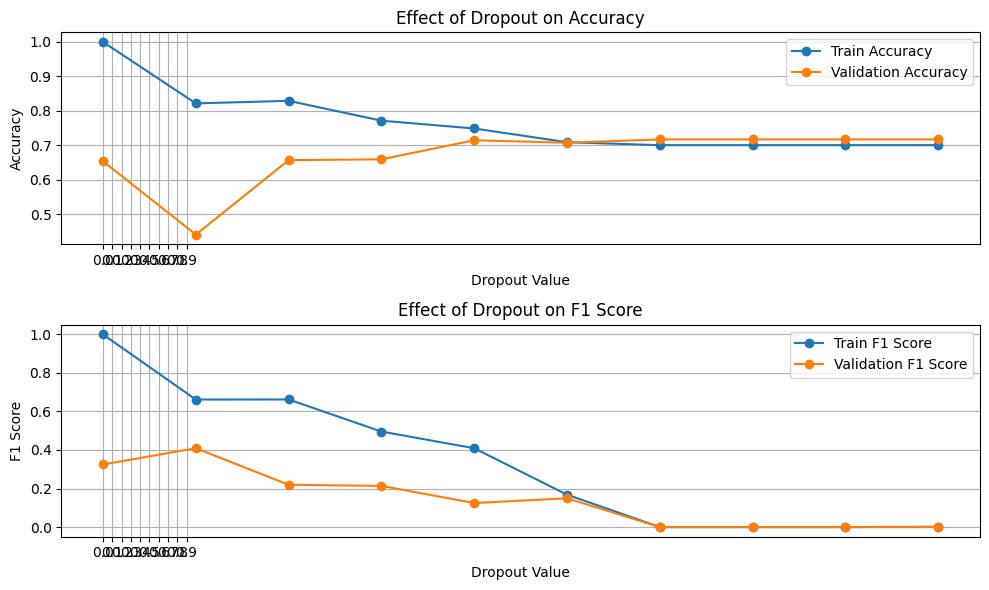

In [ ]:
# Effect of dropout on validation accuracy and F1 score
final_train_acc = []
final_val_acc = []
final_train_f1 = []
final_val_f1 = []

for dropout_val in [x / 10.0 for x in range(10)]:
    # Initialize model with varying dropout
    my_classification_cnn1d = CNN_classification_1d(dropout=dropout_val)

    # Train model
    my_classification_cnn1d, train_accs, val_accs, train_f1s, val_f1s, _, _, _, _ = train_classification_model(
        my_classification_cnn1d, train_classification_df, test_classification_df, patience=25, verbose=False, plot=False
    )

    # Record metrics
    final_train_acc.append(train_accs[-1])
    final_val_acc.append(val_accs[-1])
    final_train_f1.append(train_f1s[-1])
    final_val_f1.append(val_f1s[-1])

    # Print results for each dropout value
    print(f"Dropout: {dropout_val}, Train accuracy: {train_accs[-1]}, Validation accuracy: {val_accs[-1]}, Train F1: {train_f1s[-1]}, Validation F1: {val_f1s[-1]}")

# Plot accuracy and F1 score
plt.figure(figsize=(10, 6))

# Accuracy plot
plt.subplot(2, 1, 1)
plt.plot(final_train_acc, label="Train Accuracy", marker='o')
plt.plot(final_val_acc, label="Validation Accuracy", marker='o')
plt.title("Effect of Dropout on Accuracy")
plt.xlabel("Dropout Value")
plt.ylabel("Accuracy")
plt.xticks(list([x / 10.0 for x in range(10)]))
plt.legend()
plt.grid(which="both")

# F1 Score plot
plt.subplot(2, 1, 2)
plt.plot(final_train_f1, label="Train F1 Score", marker='o')
plt.plot(final_val_f1, label="Validation F1 Score", marker='o')
plt.title("Effect of Dropout on F1 Score")
plt.xlabel("Dropout Value")
plt.xticks(list([x / 10.0 for x in range(10)]))
plt.ylabel("F1 Score")
plt.legend()
plt.grid(which="both")

plt.tight_layout()
plt.show()

Receptive field: 20 Chunk size: 16 Number chunks: 30
cuda


<ipython-input-9-cda7b4e91609>:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_classification_1d.load_state_dict(torch.load(check_point_filename)) # recover the best m

Filter width 1: 5, Train accuracy: 0.8308286666870117, Validation accuracy: 0.6095473766326904, Train F1: 0.664714494875549, Validation F1: 0.37722419928825623
Receptive field: 22 Chunk size: 16 Number chunks: 30
cuda


<ipython-input-9-cda7b4e91609>:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_classification_1d.load_state_dict(torch.load(check_point_filename)) # recover the best m

Filter width 1: 7, Train accuracy: 0.8118670582771301, Validation accuracy: 0.6325061321258545, Train F1: 0.6113092205807438, Validation F1: 0.29310344827586204
Receptive field: 24 Chunk size: 16 Number chunks: 30
cuda


<ipython-input-9-cda7b4e91609>:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_classification_1d.load_state_dict(torch.load(check_point_filename)) # recover the best m

Filter width 1: 9, Train accuracy: 0.8434967994689941, Validation accuracy: 0.6074984669685364, Train F1: 0.6934235976789168, Validation F1: 0.3580952380952381
Receptive field: 26 Chunk size: 16 Number chunks: 30
cuda


<ipython-input-9-cda7b4e91609>:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_classification_1d.load_state_dict(torch.load(check_point_filename)) # recover the best m

Filter width 1: 11, Train accuracy: 0.8285138010978699, Validation accuracy: 0.6799172759056091, Train F1: 0.6704599336178284, Validation F1: 0.35214446952595935
Receptive field: 28 Chunk size: 16 Number chunks: 30
cuda


<ipython-input-9-cda7b4e91609>:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_classification_1d.load_state_dict(torch.load(check_point_filename)) # recover the best m

Filter width 1: 13, Train accuracy: 0.8324019908905029, Validation accuracy: 0.6437270641326904, Train F1: 0.6730769230769231, Validation F1: 0.2691415313225058
Receptive field: 30 Chunk size: 16 Number chunks: 30
cuda


<ipython-input-9-cda7b4e91609>:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_classification_1d.load_state_dict(torch.load(check_point_filename)) # recover the best m

Filter width 1: 15, Train accuracy: 0.8374656438827515, Validation accuracy: 0.6231809258460999, Train F1: 0.6895578551269991, Validation F1: 0.27312775330396477
Receptive field: 32 Chunk size: 16 Number chunks: 30
cuda


<ipython-input-9-cda7b4e91609>:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_classification_1d.load_state_dict(torch.load(check_point_filename)) # recover the best m

Filter width 1: 17, Train accuracy: 0.8595016002655029, Validation accuracy: 0.6045879125595093, Train F1: 0.72943414170233, Validation F1: 0.3153692614770459
Receptive field: 34 Chunk size: 16 Number chunks: 30
cuda


<ipython-input-9-cda7b4e91609>:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_classification_1d.load_state_dict(torch.load(check_point_filename)) # recover the best m

Filter width 1: 19, Train accuracy: 0.8487503528594971, Validation accuracy: 0.6476907134056091, Train F1: 0.7102892366050261, Validation F1: 0.2727272727272727
Receptive field: 36 Chunk size: 16 Number chunks: 30
cuda


<ipython-input-9-cda7b4e91609>:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_classification_1d.load_state_dict(torch.load(check_point_filename)) # recover the best m

Filter width 1: 21, Train accuracy: 0.8394911289215088, Validation accuracy: 0.5620979070663452, Train F1: 0.6846933848382424, Validation F1: 0.3615257048092869
Receptive field: 38 Chunk size: 16 Number chunks: 30
cuda


<ipython-input-9-cda7b4e91609>:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_classification_1d.load_state_dict(torch.load(check_point_filename)) # recover the best m

Filter width 1: 23, Train accuracy: 0.8656774759292603, Validation accuracy: 0.6119600534439087, Train F1: 0.7413383958234456, Validation F1: 0.3683241252302026
Receptive field: 40 Chunk size: 16 Number chunks: 30
cuda


<ipython-input-9-cda7b4e91609>:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_classification_1d.load_state_dict(torch.load(check_point_filename)) # recover the best m

Filter width 1: 25, Train accuracy: 0.8533347845077515, Validation accuracy: 0.5713847875595093, Train F1: 0.7157190635451505, Validation F1: 0.3443478260869565
Receptive field: 42 Chunk size: 16 Number chunks: 30
cuda


<ipython-input-9-cda7b4e91609>:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_classification_1d.load_state_dict(torch.load(check_point_filename)) # recover the best m

Filter width 1: 27, Train accuracy: 0.8652976751327515, Validation accuracy: 0.5640127062797546, Train F1: 0.7402473834443387, Validation F1: 0.3031423290203327
Receptive field: 44 Chunk size: 16 Number chunks: 30
cuda


<ipython-input-9-cda7b4e91609>:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_classification_1d.load_state_dict(torch.load(check_point_filename)) # recover the best m

Filter width 1: 29, Train accuracy: 0.8692943453788757, Validation accuracy: 0.6256510615348816, Train F1: 0.7530288909599254, Validation F1: 0.3438735177865613
Receptive field: 46 Chunk size: 16 Number chunks: 30
cuda


<ipython-input-9-cda7b4e91609>:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_classification_1d.load_state_dict(torch.load(check_point_filename)) # recover the best m

Filter width 1: 31, Train accuracy: 0.8857240676879883, Validation accuracy: 0.6241766214370728, Train F1: 0.7845868152274837, Validation F1: 0.22790697674418606


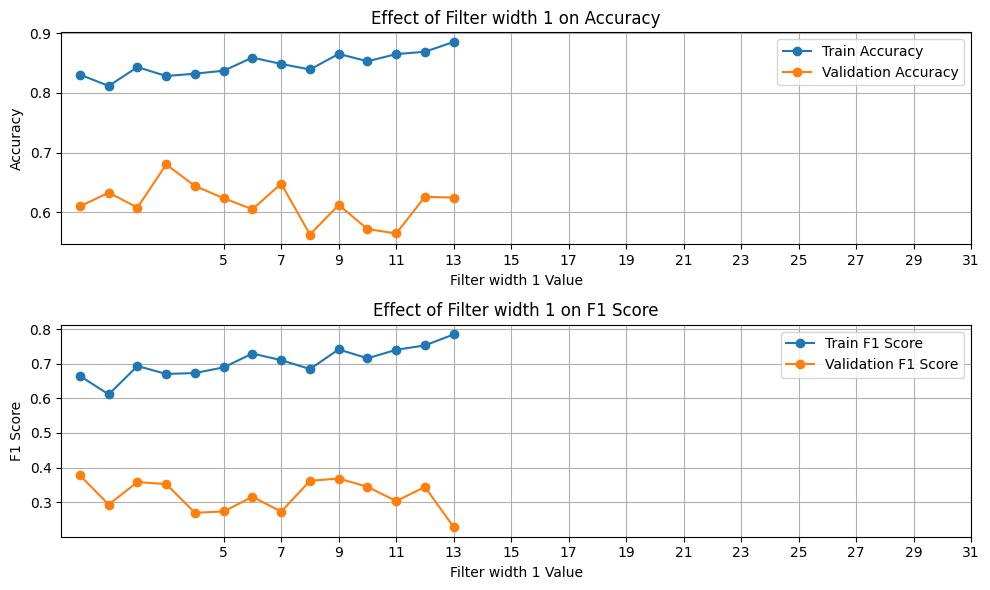

In [ ]:
# Effect of filter_width_1 on validation accuracy and F1 score
final_train_acc = []
final_val_acc = []
final_train_f1 = []
final_val_f1 = []

for filter_width_1 in range(5,32,2):
    # Initialize model with varying filter_width_1
    my_classification_cnn1d = CNN_classification_1d(filter_widths=[filter_width_1,5])

    # Train model
    my_classification_cnn1d, train_accs, val_accs, train_f1s, val_f1s, _, _, _, _ = train_classification_model(
        my_classification_cnn1d, train_classification_df, test_classification_df, patience=25, verbose=False, plot=False
    )

    # Record metrics
    final_train_acc.append(train_accs[-1])
    final_val_acc.append(val_accs[-1])
    final_train_f1.append(train_f1s[-1])
    final_val_f1.append(val_f1s[-1])

    # Print results for each filter_width_1 value
    print(f"Filter width 1: {filter_width_1}, Train accuracy: {train_accs[-1]}, Validation accuracy: {val_accs[-1]}, Train F1: {train_f1s[-1]}, Validation F1: {val_f1s[-1]}")

# Plot accuracy and F1 score
plt.figure(figsize=(10, 6))

# Accuracy plot
plt.subplot(2, 1, 1)
plt.plot(final_train_acc, label="Train Accuracy", marker='o')
plt.plot(final_val_acc, label="Validation Accuracy", marker='o')
plt.title("Effect of Filter width 1 on Accuracy")
plt.xlabel("Filter width 1 Value")
plt.ylabel("Accuracy")
plt.xticks(list(range(5,32,2)))
plt.legend()
plt.grid(which="both")

# F1 Score plot
plt.subplot(2, 1, 2)
plt.plot(final_train_f1, label="Train F1 Score", marker='o')
plt.plot(final_val_f1, label="Validation F1 Score", marker='o')
plt.title("Effect of Filter width 1 on F1 Score")
plt.xlabel("Filter width 1 Value")
plt.ylabel("F1 Score")
plt.xticks(list(range(5,32,2)))
plt.legend()
plt.grid(which="both")

plt.tight_layout()
plt.show()

Receptive field: 8 Chunk size: 16 Number chunks: 30
cuda


<ipython-input-9-cda7b4e91609>:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_classification_1d.load_state_dict(torch.load(check_point_filename)) # recover the best m

Filter width 2: 1, Train accuracy: 0.7621256709098816, Validation accuracy: 0.6207682490348816, Train F1: 0.4872611464968153, Validation F1: 0.35067437379576105
Receptive field: 16 Chunk size: 16 Number chunks: 30
cuda


<ipython-input-9-cda7b4e91609>:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_classification_1d.load_state_dict(torch.load(check_point_filename)) # recover the best m

Filter width 2: 3, Train accuracy: 0.8008536100387573, Validation accuracy: 0.6217256784439087, Train F1: 0.5962981490745373, Validation F1: 0.3299798792756539
Receptive field: 24 Chunk size: 16 Number chunks: 30
cuda


<ipython-input-9-cda7b4e91609>:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_classification_1d.load_state_dict(torch.load(check_point_filename)) # recover the best m

Filter width 2: 5, Train accuracy: 0.8311360478401184, Validation accuracy: 0.6467141509056091, Train F1: 0.6669907632474478, Validation F1: 0.2786516853932584
Receptive field: 32 Chunk size: 16 Number chunks: 30
cuda


<ipython-input-9-cda7b4e91609>:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_classification_1d.load_state_dict(torch.load(check_point_filename)) # recover the best m

Filter width 2: 7, Train accuracy: 0.8590223789215088, Validation accuracy: 0.5992264151573181, Train F1: 0.7298444130127298, Validation F1: 0.34701492537313433


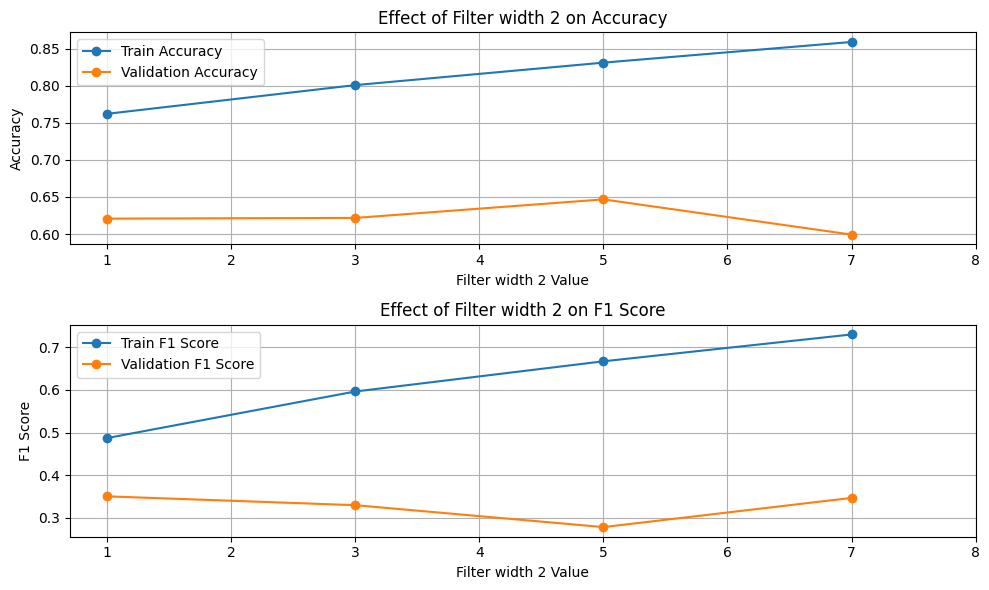

In [ ]:
# Effect of filter_width_2 on validation accuracy and F1 score
final_train_acc = []
final_val_acc = []
final_train_f1 = []
final_val_f1 = []

x = range(1,9,2)
for filter_width_2 in x:
    # Initialize model with varying filter_width_2
    my_classification_cnn1d = CNN_classification_1d(filter_widths=[9,filter_width_2])

    # Train model
    my_classification_cnn1d, train_accs, val_accs, train_f1s, val_f1s, _, _, _, _ = train_classification_model(
        my_classification_cnn1d, train_classification_df, test_classification_df, patience=25, verbose=False, plot=False
    )

    # Record metrics
    final_train_acc.append(train_accs[-1])
    final_val_acc.append(val_accs[-1])
    final_train_f1.append(train_f1s[-1])
    final_val_f1.append(val_f1s[-1])

    # Print results for each filter_width_2 value
    print(f"Filter width 2: {filter_width_2}, Train accuracy: {train_accs[-1]}, Validation accuracy: {val_accs[-1]}, Train F1: {train_f1s[-1]}, Validation F1: {val_f1s[-1]}")

# Plot accuracy and F1 score
plt.figure(figsize=(10, 6))

# Accuracy plot
plt.subplot(2, 1, 1)
plt.plot(x, final_train_acc, label="Train Accuracy", marker='o')
plt.plot(x, final_val_acc, label="Validation Accuracy", marker='o')
plt.title("Effect of Filter width 2 on Accuracy")
plt.xlabel("Filter width 2 Value")
plt.ylabel("Accuracy")
plt.xticks(list(range(1,9)))
plt.legend()
plt.grid(which="both")

# F1 Score plot
plt.subplot(2, 1, 2)
plt.plot(x, final_train_f1, label="Train F1 Score", marker='o')
plt.plot(x, final_val_f1, label="Validation F1 Score", marker='o')
plt.title("Effect of Filter width 2 on F1 Score")
plt.xlabel("Filter width 2 Value")
plt.ylabel("F1 Score")
plt.xticks(list(range(1,9)))
plt.legend()
plt.grid(which="both")

plt.tight_layout()
plt.show()

Receptive field: 22 Chunk size: 4 Number chunks: 120
cuda


<ipython-input-9-cda7b4e91609>:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_classification_1d.load_state_dict(torch.load(check_point_filename)) # recover the best m

Max Pooling: 2, Train accuracy: 0.8645200729370117, Validation accuracy: 0.6671836972236633, Train F1: 0.7315403422982885, Validation F1: 0.16
Receptive field: 26 Chunk size: 9 Number chunks: 60
cuda


<ipython-input-9-cda7b4e91609>:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_classification_1d.load_state_dict(torch.load(check_point_filename)) # recover the best m

Max Pooling: 3, Train accuracy: 0.8478732705116272, Validation accuracy: 0.5835822820663452, Train F1: 0.7077214590241592, Validation F1: 0.35752212389380533
Receptive field: 30 Chunk size: 16 Number chunks: 30
cuda


<ipython-input-9-cda7b4e91609>:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_classification_1d.load_state_dict(torch.load(check_point_filename)) # recover the best m

Max Pooling: 4, Train accuracy: 0.8401963710784912, Validation accuracy: 0.602653980255127, Train F1: 0.6869271587071877, Validation F1: 0.34831460674157305
Receptive field: 34 Chunk size: 25 Number chunks: 20
cuda


<ipython-input-9-cda7b4e91609>:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_classification_1d.load_state_dict(torch.load(check_point_filename)) # recover the best m

Max Pooling: 5, Train accuracy: 0.8361274003982544, Validation accuracy: 0.6383655071258545, Train F1: 0.6795366795366795, Validation F1: 0.24056603773584906
Receptive field: 38 Chunk size: 36 Number chunks: 13
cuda


<ipython-input-9-cda7b4e91609>:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_classification_1d.load_state_dict(torch.load(check_point_filename)) # recover the best m

Max Pooling: 6, Train accuracy: 0.8335051536560059, Validation accuracy: 0.6290786266326904, Train F1: 0.6699314397649363, Validation F1: 0.3319838056680162
Receptive field: 42 Chunk size: 49 Number chunks: 10
cuda


<ipython-input-9-cda7b4e91609>:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_classification_1d.load_state_dict(torch.load(check_point_filename)) # recover the best m

Max Pooling: 7, Train accuracy: 0.8443467617034912, Validation accuracy: 0.6178385615348816, Train F1: 0.6920077972709552, Validation F1: 0.2511013215859031
Receptive field: 46 Chunk size: 64 Number chunks: 8
cuda


<ipython-input-9-cda7b4e91609>:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_classification_1d.load_state_dict(torch.load(check_point_filename)) # recover the best m

Max Pooling: 8, Train accuracy: 0.8187662959098816, Validation accuracy: 0.5718826651573181, Train F1: 0.6419512195121951, Validation F1: 0.32978723404255317
Receptive field: 50 Chunk size: 81 Number chunks: 6
cuda


<ipython-input-9-cda7b4e91609>:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_classification_1d.load_state_dict(torch.load(check_point_filename)) # recover the best m

Max Pooling: 9, Train accuracy: 0.8379539251327515, Validation accuracy: 0.6608455777168274, Train F1: 0.6830443159922929, Validation F1: 0.24875621890547264
Receptive field: 54 Chunk size: 100 Number chunks: 5
cuda


<ipython-input-9-cda7b4e91609>:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_classification_1d.load_state_dict(torch.load(check_point_filename)) # recover the best m

Max Pooling: 10, Train accuracy: 0.8346625566482544, Validation accuracy: 0.6364123821258545, Train F1: 0.6712463199214916, Validation F1: 0.28634361233480177


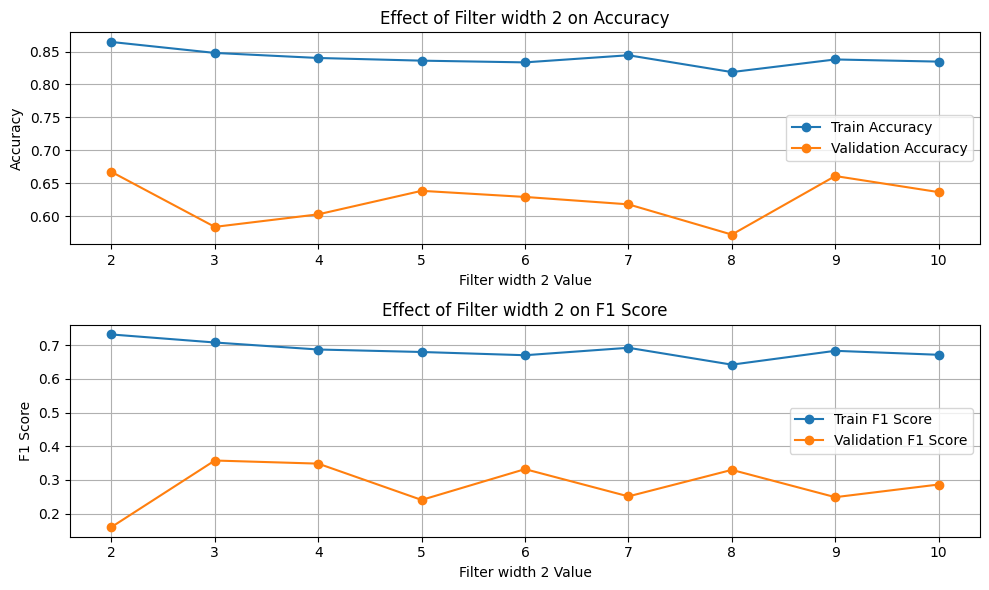

In [ ]:
# Effect of max pooling on validation accuracy
nchunks = [120, 60, 30, 20, 13, 10, 8, 6, 5]
mp = [2, 3, 4, 5, 6, 7, 8, 9, 10]
final_train_acc = []
final_val_acc = []
final_train_f1 = []
final_val_f1 = []

x = mp

for i in range(9):
    # Initialize model with varying filter_width_2
    my_classification_cnn1d = CNN_classification_1d(max_pool_factor=mp[i],num_chunks=nchunks[i])

    # Train model
    my_classification_cnn1d, train_accs, val_accs, train_f1s, val_f1s, _, _, _, _ = train_classification_model(
        my_classification_cnn1d, train_classification_df, test_classification_df, patience=25, verbose=False, plot=False
    )

    # Record metrics
    final_train_acc.append(train_accs[-1])
    final_val_acc.append(val_accs[-1])
    final_train_f1.append(train_f1s[-1])
    final_val_f1.append(val_f1s[-1])

    # Print results for each filter_width_2 value
    print(f"Max Pooling: {mp[i]}, Train accuracy: {train_accs[-1]}, Validation accuracy: {val_accs[-1]}, Train F1: {train_f1s[-1]}, Validation F1: {val_f1s[-1]}")



# Plot accuracy and F1 score
plt.figure(figsize=(10, 6))

# Accuracy plot
plt.subplot(2, 1, 1)
plt.plot(x, final_train_acc, label="Train Accuracy", marker='o')
plt.plot(x, final_val_acc, label="Validation Accuracy", marker='o')
plt.title("Effect of Filter width 2 on Accuracy")
plt.xlabel("Filter width 2 Value")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(which="both")

# F1 Score plot
plt.subplot(2, 1, 2)
plt.plot(x, final_train_f1, label="Train F1 Score", marker='o')
plt.plot(x, final_val_f1, label="Validation F1 Score", marker='o')
plt.title("Effect of Filter width 2 on F1 Score")
plt.xlabel("Filter width 2 Value")
plt.ylabel("F1 Score")
plt.legend()
plt.grid(which="both")

plt.tight_layout()
plt.show()

Receptive field: 32 Chunk size: 8 Number chunks: 60
512
cuda
Epoch 1 took 4.04s. Train loss: 0.6476, Train acc: 0.6862, Train F1: 0.0743, Train Precision: 0.3187, Train Recall: 0.0420. Val loss: 0.6274, Val acc: 0.6790, Val F1: 0.0000, Val Precision: 0.0000, Val Recall: 0.0000. Patience left: 50
Epoch 2 took 3.13s. Train loss: 0.6266, Train acc: 0.7004, Train F1: 0.0000, Train Precision: 0.0000, Train Recall: 0.0000. Val loss: 0.6286, Val acc: 0.6790, Val F1: 0.0000, Val Precision: 0.0000, Val Recall: 0.0000. Patience left: 49
Epoch 3 took 3.14s. Train loss: 0.6161, Train acc: 0.7004, Train F1: 0.0000, Train Precision: 0.0000, Train Recall: 0.0000. Val loss: 0.6252, Val acc: 0.6790, Val F1: 0.0000, Val Precision: 0.0000, Val Recall: 0.0000. Patience left: 50
Epoch 4 took 3.25s. Train loss: 0.6120, Train acc: 0.7004, Train F1: 0.0000, Train Precision: 0.0000, Train Recall: 0.0000. Val loss: 0.6256, Val acc: 0.6790, Val F1: 0.0000, Val Precision: 0.0000, Val Recall: 0.0000. Patience left

<ipython-input-9-cda7b4e91609>:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_classification_1d.load_state_dict(torch.load(check_point_filename)) # recover the best m

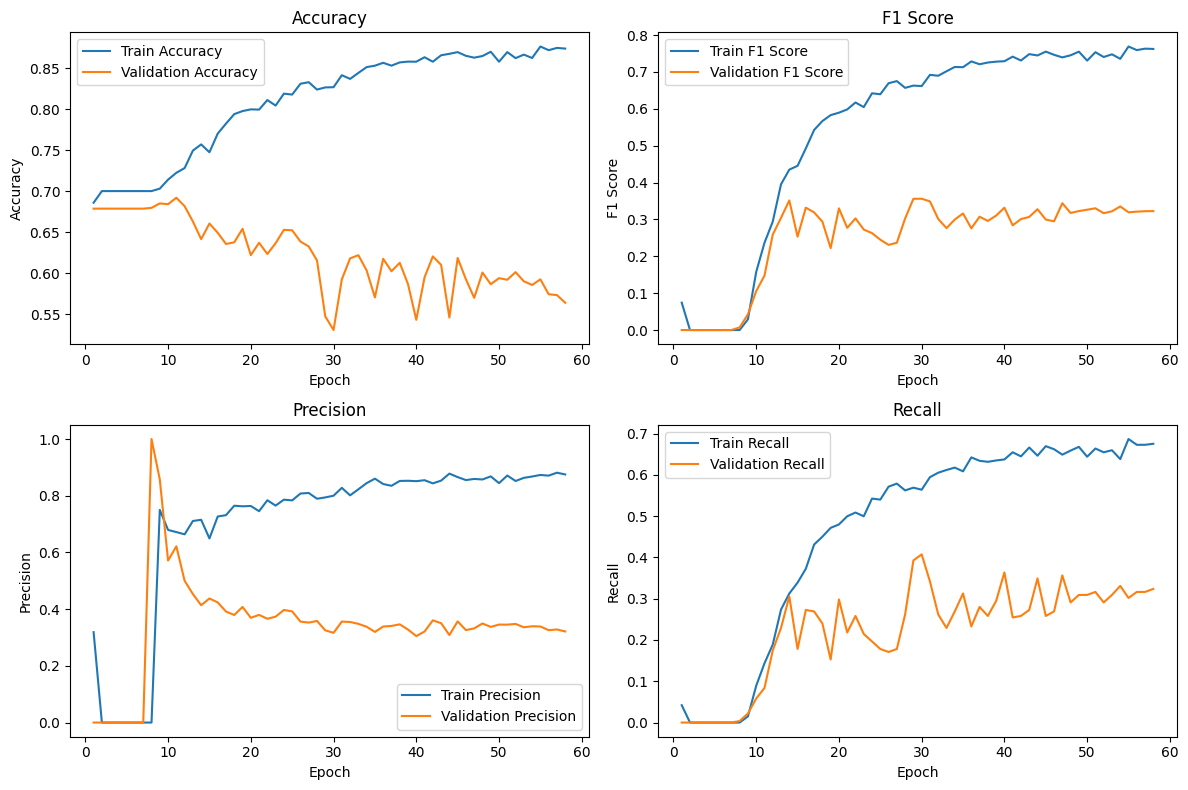

In [ ]:
# increasing number of layers
my_classification_cnn1d = CNN_classification_1d(filter_widths = [9,5, 5],
                 num_chunks = 60,
                 max_pool_factor = 2,
                 nchannels = [4, 32, 32, 32], # tested 16
                 n_hidden=16) # tested 64, 16 (0.32)
print(my_classification_cnn1d.seq_len)
my_classification_cnn1d
my_classification_cnn1d, train_accs, val_accs, train_f1s, val_f1s, train_precisions, val_precisions, train_recalls, val_recalls = train_classification_model(my_classification_cnn1d, train_classification_df, val_classification_df, patience = 50)

Receptive field: 22 Chunk size: 4 Number chunks: 120
cuda


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1545: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn(
<ipython-input-15-48e39ab289bc>:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be 

Max Pooling: 2, Train accuracy: 0.8595805764198303, Validation accuracy: 0.5526794195175171
Receptive field: 26 Chunk size: 9 Number chunks: 60
cuda
Max Pooling: 3, Train accuracy: 0.8842516541481018, Validation accuracy: 0.5919039249420166
Receptive field: 30 Chunk size: 16 Number chunks: 30
cuda
Max Pooling: 4, Train accuracy: 0.8793174624443054, Validation accuracy: 0.6453472375869751
Receptive field: 34 Chunk size: 25 Number chunks: 20
cuda
Max Pooling: 5, Train accuracy: 0.8717105388641357, Validation accuracy: 0.5249594449996948
Receptive field: 38 Chunk size: 36 Number chunks: 13
cuda
Max Pooling: 6, Train accuracy: 0.8605791330337524, Validation accuracy: 0.5240162014961243
Receptive field: 42 Chunk size: 49 Number chunks: 10
cuda
Max Pooling: 7, Train accuracy: 0.8404605388641357, Validation accuracy: 0.6653645634651184
Receptive field: 46 Chunk size: 64 Number chunks: 8
cuda
Max Pooling: 8, Train accuracy: 0.8412829041481018, Validation accuracy: 0.6438946723937988
Receptive 

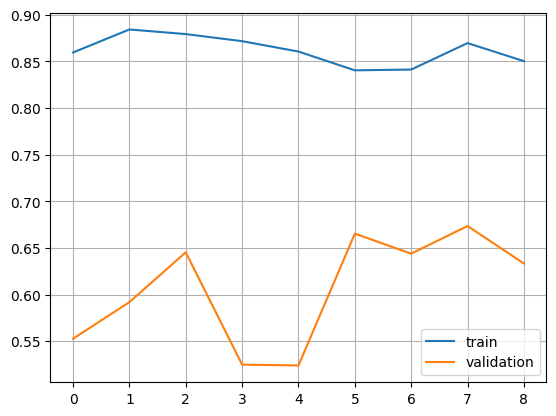

In [ ]:
# Effect of max pooling on validation accuracy
nchunks = [120, 60, 30, 20, 13, 10, 8, 6, 5]
mp = [2, 3, 4, 5, 6, 7, 8, 9, 10]
final_train_acc = []
final_val_acc = []
for i in range(9):
    my_classification_cnn1d = CNN_classification_1d(max_pool_factor=mp[i],num_chunks=nchunks[i])
    my_classification_cnn1d, train_accs, val_accs = train_classification_model(my_classification_cnn1d, train_classification_df, test_classification_df, patience=25,verbose=False)
    final_train_acc.append(train_accs[-1])
    final_val_acc.append(val_accs[-1])
    print(f"Max Pooling: {mp[i]}, Train accuracy: {train_accs[-1]}, Validation accuracy: {val_accs[-1]}")

plt.plot(final_train_acc, label="train")
plt.plot(final_val_acc, label="validation")
plt.legend()
plt.grid(which="both")

Receptive field: 34 Chunk size: 25 Number chunks: 30
cuda


<ipython-input-15-48e39ab289bc>:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_classification_1d.load_state_dict(torch.load(check_point_filename)) # recover the best 

Dropout: 0.0, Train accuracy: 0.9995887875556946, Validation accuracy: 0.6273263692855835
Receptive field: 34 Chunk size: 25 Number chunks: 30
cuda
Dropout: 0.1, Train accuracy: 0.9323601722717285, Validation accuracy: 0.4840393662452698
Receptive field: 34 Chunk size: 25 Number chunks: 30
cuda
Dropout: 0.2, Train accuracy: 0.8770559430122375, Validation accuracy: 0.6299132108688354
Receptive field: 34 Chunk size: 25 Number chunks: 30
cuda
Dropout: 0.3, Train accuracy: 0.8215460777282715, Validation accuracy: 0.579537034034729
Receptive field: 34 Chunk size: 25 Number chunks: 30
cuda
Dropout: 0.4, Train accuracy: 0.7879757881164551, Validation accuracy: 0.6553703546524048
Receptive field: 34 Chunk size: 25 Number chunks: 30
cuda
Dropout: 0.5, Train accuracy: 0.6918761730194092, Validation accuracy: 0.7111862897872925
Receptive field: 34 Chunk size: 25 Number chunks: 30
cuda
Dropout: 0.6, Train accuracy: 0.6926985383033752, Validation accuracy: 0.7111862897872925
Receptive field: 34 Chu

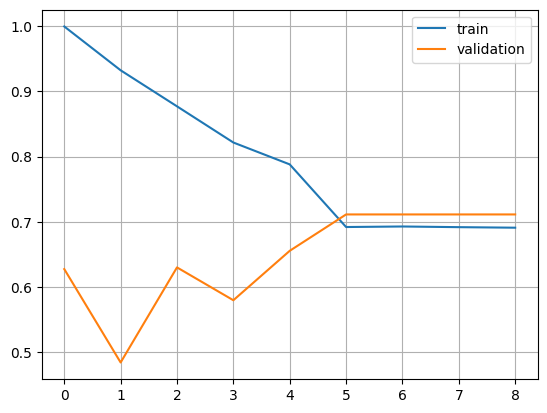

In [ ]:
# Effect of dropout on validation accuracy
final_train_acc = []
final_val_acc = []
for dropout_val in [x/10.0 for x in range(9)]:
    my_classification_cnn1d = CNN_classification_1d(dropout = dropout_val)
    my_classification_cnn1d, train_accs, val_accs = train_classification_model(my_classification_cnn1d, train_classification_df, test_classification_df, patience=25,verbose=False)
    final_train_acc.append(train_accs[-1])
    final_val_acc.append(val_accs[-1])
    print(f"Dropout: {dropout_val}, Train accuracy: {train_accs[-1]}, Validation accuracy: {val_accs[-1]}")

plt.plot(final_train_acc, label="train")
plt.plot(final_val_acc, label="validation")
plt.legend()
plt.grid(which="both")

Receptive field: 34 Chunk size: 25 Number chunks: 30
cuda


<ipython-input-15-48e39ab289bc>:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_classification_1d.load_state_dict(torch.load(check_point_filename)) # recover the best 

n_hidden: 4, Train accuracy: 0.8134398460388184, Validation accuracy: 0.5360590219497681
Receptive field: 34 Chunk size: 25 Number chunks: 30
cuda
n_hidden: 12, Train accuracy: 0.87044757604599, Validation accuracy: 0.5889930725097656
Receptive field: 34 Chunk size: 25 Number chunks: 30
cuda
n_hidden: 20, Train accuracy: 0.8756167888641357, Validation accuracy: 0.6310995221138
Receptive field: 34 Chunk size: 25 Number chunks: 30
cuda
n_hidden: 28, Train accuracy: 0.890625, Validation accuracy: 0.599606454372406
Receptive field: 34 Chunk size: 25 Number chunks: 30
cuda
n_hidden: 36, Train accuracy: 0.8861019611358643, Validation accuracy: 0.6119154691696167
Receptive field: 34 Chunk size: 25 Number chunks: 30
cuda
n_hidden: 44, Train accuracy: 0.8856908082962036, Validation accuracy: 0.6241203546524048
Receptive field: 34 Chunk size: 25 Number chunks: 30
cuda
n_hidden: 52, Train accuracy: 0.8840460777282715, Validation accuracy: 0.6266261339187622
Receptive field: 34 Chunk size: 25 Numb

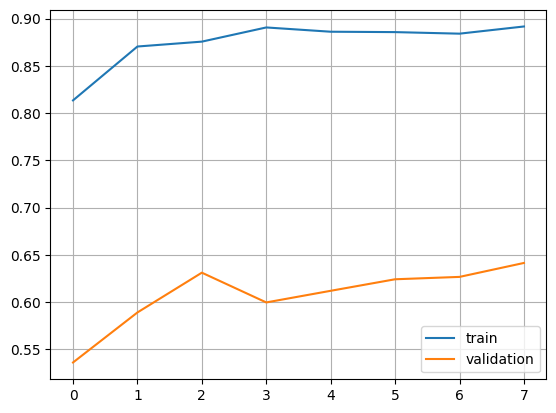

In [ ]:
# Effect of n_hidden on validation accuracy
final_train_acc = []
final_val_acc = []
for nhidden in range(4,64,8):
    my_classification_cnn1d = CNN_classification_1d(n_hidden=nhidden)
    my_classification_cnn1d, train_accs, val_accs = train_classification_model(my_classification_cnn1d, train_classification_df, test_classification_df, patience=25,verbose=False)
    final_train_acc.append(train_accs[-1])
    final_val_acc.append(val_accs[-1])
    print(f"n_hidden: {nhidden}, Train accuracy: {train_accs[-1]}, Validation accuracy: {val_accs[-1]}")

plt.plot(final_train_acc, label="train")
plt.plot(final_val_acc, label="validation")
plt.legend()
plt.grid(which="both")

Receptive field: 34 Chunk size: 25 Number chunks: 30
cuda


<ipython-input-15-48e39ab289bc>:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_classification_1d.load_state_dict(torch.load(check_point_filename)) # recover the best 

nchannels: [4,4,4], Train accuracy: 0.6971040964126587, Validation accuracy: 0.7119675874710083
Receptive field: 34 Chunk size: 25 Number chunks: 30
cuda
nchannels: [4,8,8], Train accuracy: 0.7237723469734192, Validation accuracy: 0.6876157522201538
Receptive field: 34 Chunk size: 25 Number chunks: 30
cuda
nchannels: [4,12,12], Train accuracy: 0.7559328079223633, Validation accuracy: 0.6469907164573669
Receptive field: 34 Chunk size: 25 Number chunks: 30
cuda
nchannels: [4,16,16], Train accuracy: 0.7865954041481018, Validation accuracy: 0.5982060432434082
Receptive field: 34 Chunk size: 25 Number chunks: 30
cuda
nchannels: [4,20,20], Train accuracy: 0.7999588847160339, Validation accuracy: 0.5956192016601562
Receptive field: 34 Chunk size: 25 Number chunks: 30
cuda
nchannels: [4,24,24], Train accuracy: 0.8291236162185669, Validation accuracy: 0.5504976511001587
Receptive field: 34 Chunk size: 25 Number chunks: 30
cuda
nchannels: [4,28,28], Train accuracy: 0.8552631735801697, Validation

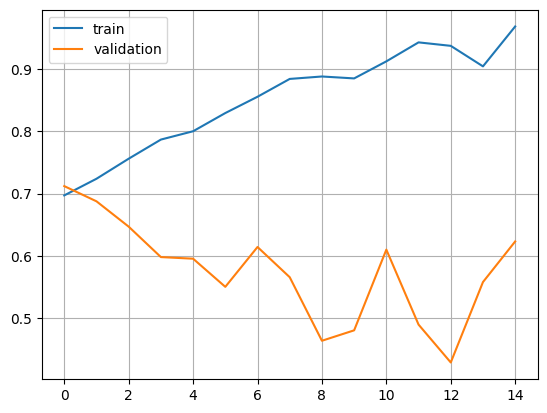

In [ ]:
# Effect of nchannels on validation accuracy
final_train_acc = []
final_val_acc = []
for nchannels in range(4,64,4):
    my_classification_cnn1d = CNN_classification_1d(nchannels=[4,nchannels,nchannels])
    my_classification_cnn1d, train_accs, val_accs = train_classification_model(my_classification_cnn1d, train_classification_df, test_classification_df, patience=25,verbose=False)
    final_train_acc.append(train_accs[-1])
    final_val_acc.append(val_accs[-1])
    print(f"nchannels: [4,{nchannels},{nchannels}], Train accuracy: {train_accs[-1]}, Validation accuracy: {val_accs[-1]}")

plt.plot(final_train_acc, label="train")
plt.plot(final_val_acc, label="validation")
plt.legend()
plt.grid(which="both")

In [ ]:
# Effect of number of convolutional layers on validation accuracy
final_train_acc = []
final_val_acc = []
for n_layers in range(1, 6):
    layer_channels = [4] + [32] * n_layers
    my_classification_cnn1d = CNN_classification_1d(nchannels=layer_channels)
    my_classification_cnn1d, train_accs, val_accs = train_classification_model(my_classification_cnn1d, train_classification_df, test_classification_df, patience=25,verbose=False)
    final_train_acc.append(train_accs[-1])
    final_val_acc.append(val_accs[-1])
    print(f"nchannels: {layer_channels}, Train accuracy: {train_accs[-1]}, Validation accuracy: {val_accs[-1]}")

plt.plot(final_train_acc, label="train")
plt.plot(final_val_acc, label="validation")
plt.legend()
plt.grid(which="both")

In [ ]:
import torch.nn as nn
import torch.nn.init as init

def init_weights(m):
    """
    Initializes the weights of a model using Xavier (Glorot) initialization for weights
    and zeros for biases (common practice in deep learning).
    """
    if isinstance(m, nn.Conv1d):
        init.xavier_uniform_(m.weight)  # Xavier initialization for Conv1D layers
        if m.bias is not None:
            init.zeros_(m.bias)  # Initialize biases to zero
    elif isinstance(m, nn.Linear):
        init.xavier_uniform_(m.weight)  # Xavier initialization for Linear layers
        if m.bias is not None:
            init.zeros_(m.bias)  # Initialize biases to zero
    elif isinstance(m, nn.BatchNorm1d):
        init.ones_(m.weight)  # Initialize BatchNorm weights to 1
        init.zeros_(m.bias)   # Initialize BatchNorm biases to 0


In [ ]:
from sklearn.model_selection import KFold

def train_classification_model_kfold(cnn_classification_1d, data, epochs=100, patience=10, k=5, batch_size=256, verbose=True):
    """
    Train a 1D CNN model using k-fold cross-validation.
    Args:
        cnn_classification_1d: The model to train.
        data: The dataset (DataFrame with features and labels).
        epochs: Number of epochs for each fold.
        patience: Early stopping patience.
        k: Number of folds for cross-validation.
        batch_size: Batch size for the DataLoader.
        verbose: Whether to print training progress.
    Returns:
        mean_train_acc, mean_val_acc: Average training and validation accuracy over all folds.
        all_train_acc, all_val_acc: List of training and validation accuracies for each fold.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    cnn_classification_1d.to(device)

    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    all_train_acc = []
    all_val_acc = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(data)):
        print(f"\nTraining fold {fold + 1}/{k}...")

        # Split data into training and validation sets
        train_data = data.iloc[train_idx]
        val_data = data.iloc[val_idx]

        # Create datasets and dataloaders
        train_dataset = PromoterNoiseClassificationDataset(train_data, cnn_classification_1d.seq_len)
        train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=0)
        val_dataset = PromoterNoiseClassificationDataset(val_data, cnn_classification_1d.seq_len)
        val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

        # Re-initialize the model for each fold
        cnn_classification_1d.apply(init_weights)  # Re-initialize model weights

        optimizer = torch.optim.Adam(cnn_classification_1d.parameters(), amsgrad=True)
        train_accs = []
        val_accs = []
        patience_counter = patience
        best_val_loss = np.inf
        check_point_filename = f'cnn_classification_1d_fold_{fold + 1}_checkpoint.pt'

        # 3. Run the training loop for the current fold
        for epoch in range(epochs):
            start_time = timeit.default_timer()
            train_loss, train_acc = run_one_classification_epoch(True, train_dataloader, cnn_classification_1d, optimizer, device)
            val_loss, val_acc = run_one_classification_epoch(False, val_dataloader, cnn_classification_1d, optimizer, device)
            train_accs.append(train_acc)
            val_accs.append(val_acc)

            if val_loss < best_val_loss:
                torch.save(cnn_classification_1d.state_dict(), check_point_filename)
                best_val_loss = val_loss
                patience_counter = patience
            else:
                patience_counter -= 1
                if patience_counter <= 0:
                    cnn_classification_1d.load_state_dict(torch.load(check_point_filename))  # Recover the best model
                    break

            if verbose:
                elapsed = float(timeit.default_timer() - start_time)
                print(f"Epoch {epoch + 1} took {elapsed:.2f}s. Train loss: {train_loss:.4f} acc: {train_acc:.4f}. Val loss: {val_loss:.4f} acc: {val_acc:.4f}. Patience left: {patience_counter}")

        # Append results for this fold
        all_train_acc.append(train_accs[-1])
        all_val_acc.append(val_accs[-1])

    # Calculate average performance across folds
    mean_train_acc = np.mean(all_train_acc)
    mean_val_acc = np.mean(all_val_acc)

    # Print final results
    print(f"\nAverage Train Accuracy: {mean_train_acc:.4f}")
    print(f"Average Validation Accuracy: {mean_val_acc:.4f}")

    return cnn_classification_1d, mean_train_acc, mean_val_acc, all_train_acc, all_val_acc


In [ ]:
my_classification_cnn1d = CNN_classification_1d()
print(my_classification_cnn1d.seq_len)
my_classification_cnn1d
my_classification_cnn1d, train_accs, val_accs = train_classification_model_kfold(my_classification_cnn1d, df)

Receptive field: 94 Chunk size: 64 Number chunks: 7
542

Training fold 1/5...


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1545: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn(


Epoch 1 took 0.76s. Train loss: 0.7065 acc: 0.6321. Val loss: 0.6397 acc: 0.6894. Patience left: 10
Epoch 2 took 0.75s. Train loss: 0.6529 acc: 0.6688. Val loss: 0.6166 acc: 0.7071. Patience left: 10
Epoch 3 took 0.74s. Train loss: 0.6391 acc: 0.6718. Val loss: 0.6119 acc: 0.7049. Patience left: 10
Epoch 4 took 0.73s. Train loss: 0.6326 acc: 0.6826. Val loss: 0.6102 acc: 0.7056. Patience left: 10
Epoch 5 took 0.72s. Train loss: 0.6291 acc: 0.6807. Val loss: 0.6094 acc: 0.7056. Patience left: 10
Epoch 6 took 0.76s. Train loss: 0.6168 acc: 0.6881. Val loss: 0.6078 acc: 0.7048. Patience left: 10
Epoch 7 took 0.71s. Train loss: 0.6178 acc: 0.6873. Val loss: 0.6088 acc: 0.7048. Patience left: 9
Epoch 8 took 0.74s. Train loss: 0.6063 acc: 0.6938. Val loss: 0.6089 acc: 0.7032. Patience left: 8
Epoch 9 took 0.76s. Train loss: 0.6042 acc: 0.6974. Val loss: 0.6093 acc: 0.7040. Patience left: 7
Epoch 10 took 0.74s. Train loss: 0.5997 acc: 0.6932. Val loss: 0.6095 acc: 0.7048. Patience left: 6
Epo

<ipython-input-72-967868b6cc7a>:64: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_classification_1d.load_state_dict(torch.load(check_point_filename))  # Recover the best


Training fold 2/5...
Epoch 1 took 0.72s. Train loss: 0.9372 acc: 0.6186. Val loss: 0.6444 acc: 0.6666. Patience left: 10
Epoch 2 took 0.73s. Train loss: 0.7150 acc: 0.6133. Val loss: 0.6500 acc: 0.6798. Patience left: 9
Epoch 3 took 0.76s. Train loss: 0.6641 acc: 0.6680. Val loss: 0.6336 acc: 0.6806. Patience left: 10
Epoch 4 took 0.71s. Train loss: 0.6533 acc: 0.6760. Val loss: 0.6371 acc: 0.6814. Patience left: 9
Epoch 5 took 0.73s. Train loss: 0.6240 acc: 0.6800. Val loss: 0.6311 acc: 0.6814. Patience left: 10
Epoch 6 took 0.74s. Train loss: 0.6203 acc: 0.6801. Val loss: 0.6300 acc: 0.6814. Patience left: 10
Epoch 7 took 0.74s. Train loss: 0.6281 acc: 0.6851. Val loss: 0.6338 acc: 0.6821. Patience left: 9
Epoch 8 took 0.74s. Train loss: 0.6173 acc: 0.6908. Val loss: 0.6342 acc: 0.6837. Patience left: 8
Epoch 9 took 0.71s. Train loss: 0.6125 acc: 0.6889. Val loss: 0.6318 acc: 0.6822. Patience left: 7
Epoch 10 took 0.73s. Train loss: 0.6019 acc: 0.7016. Val loss: 0.6350 acc: 0.6791. 

ValueError: too many values to unpack (expected 3)